<a href="https://colab.research.google.com/github/dlchihade/snafu-py/blob/master/MEDIATION_WITH_NEW_SCORES_11_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup environment**

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import spacy
import io
import re
from sklearn.cluster import AgglomerativeClustering

!pip install git+https://github.com/AusterweilLab/snafu-py
!python -m spacy download en_core_web_md

# Set the style for plots
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# Load spaCy model for word vectors
nlp = spacy.load("en_core_web_md")

!pip install wordfreq
from wordfreq import zipf_frequency
from wordfreq import top_n_list

  Cloning https://github.com/AusterweilLab/snafu-py to /tmp/pip-req-build-atg1x2b2
  Running command git clone --filter=blob:none --quiet https://github.com/AusterweilLab/snafu-py /tmp/pip-req-build-atg1x2b2
  Resolved https://github.com/AusterweilLab/snafu-py to commit f1d347c4c7c4f5e455a677be04b153e43927d820
  Preparing metadata (setup.py) ... done
  Created wheel for pysnafu: filename=pysnafu-2.6.3-py3-none-any.whl size=40060 sha256=8b1eb7c9798f2a55481eefd04e4655cfb3a172584c178b5d9ca8e702195045b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-r8vdy_3k/wheels/0c/41/02/1e48c59b0dcd6c76edd1918a84e3c9dfdc27afc76672c55a32
Successfully built pysnafu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 51.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You 

**Load Data**

In [ ]:
# pull down the top 50 000 English words (most → least frequent)
freq_list = top_n_list("en", 50000)
def word_rank(word:str, freq_list:list[str]) -> int:
    """
    Return 1-based rank of `word` in `freq_list`,
    or 0 if it’s not in the top-N.
    """
    try:
        return freq_list.index(word) + 1
    except ValueError:
        return 0

print(word_rank("the", freq_list))    # → 1
print(word_rank("computer", freq_list))  # e.g. → 899
print(word_rank("foobarxyz", freq_list)) # → 0 (not in top 50 000)

from wordfreq import top_n_list

# Get top 10 words in English
top_10 = top_n_list('en', 10)
print(top_10)
# Returns: ['the', 'to', 'and', 'of', 'a', 'in', 'i', 'is', 'for', 'that']

# Get top 50,000 words (your use case)
top_50k = top_n_list('en', 50000)
print(top_50k)

# Specify wordlist type for larger dataset
top_50k_large = top_n_list('en', 50000, wordlist='large')

# Scientific notation also works
top_100k = top_n_list('en', 1e5, wordlist='large')  # 100,000 words

1
1136
0
['the', 'to', 'and', 'of', 'a', 'in', 'i', 'is', 'for', 'that']
['the', 'to', 'and', 'of', 'a', 'in', 'i', 'is', 'for', 'that', 'you', 'it', 'on', 'with', 'this', 'was', 'be', 'as', 'are', 'have', 'at', 'he', 'not', 'by', 'but', 'from', 'my', 'or', 'we', 'an', 'your', 'all', 'so', 'his', 'they', 'me', 'if', 'one', 'can', 'will', 'just', 'like', 'about', 'up', 'out', 'what', 'has', 'when', 'more', 'do', 'no', 'were', 'who', 'had', "it's", 'their', 'there', 'her', 'which', 'time', 'get', 'been', 'would', 'she', 'new', 'people', 'how', "don't", 'some', 'also', 'them', 'now', 'other', "i'm", 'its', 'our', 'than', 'good', 'only', 'after', 'first', 'him', 'into', 'know', 'see', 'two', 'make', 'over', 'think', 'any', 'then', 'could', 'back', 'these', 'us', 'want', 'because', 'go', 'well', 'said', 'way', '1', '2', 'most', 'much', 'very', 'where', 'even', 'should', 'may', 'here', 'need', 'really', 'did', 'right', 'work', 'year', 'years', 'being', 'day', 'too', 'going', 'before', 'off',

Incorporating Word Freq

In [ ]:
from wordfreq import top_n_list

# Get top 50,000 words
print("Loading top 50,000 English words...")
top_50k = top_n_list('en', 50000)

# Create a comprehensive list of animal names
animals = [
    # Mammals
    'dog', 'cat', 'horse', 'cow', 'pig', 'sheep', 'goat', 'mouse', 'rat', 'rabbit',
    'lion', 'tiger', 'bear', 'wolf', 'fox', 'deer', 'elephant', 'monkey', 'ape',
    'whale', 'dolphin', 'seal', 'bat', 'hamster', 'guinea', 'gerbil', 'ferret',
    'squirrel', 'chipmunk', 'beaver', 'otter', 'raccoon', 'skunk', 'badger',
    'panda', 'koala', 'kangaroo', 'wallaby', 'opossum', 'platypus', 'echidna',
    'giraffe', 'zebra', 'hippopotamus', 'rhinoceros', 'camel', 'llama', 'alpaca',
    'moose', 'elk', 'reindeer', 'caribou', 'antelope', 'gazelle', 'buffalo', 'bison',
    'yak', 'ox', 'bull', 'donkey', 'mule', 'pony', 'mare', 'stallion', 'foal',
    'lamb', 'ram', 'ewe', 'kid', 'boar', 'sow', 'piglet', 'hog',
    'leopard', 'cheetah', 'jaguar', 'panther', 'cougar', 'puma', 'lynx', 'bobcat',
    'hyena', 'jackal', 'coyote', 'dingo', 'puppy', 'kitten', 'cub', 'pup',
    'walrus', 'manatee', 'dugong', 'narwhal', 'porpoise', 'orca', 'vole', 'shrew',
    'mole', 'hedgehog', 'porcupine', 'armadillo', 'anteater', 'sloth', 'pangolin',
    'lemur', 'baboon', 'chimpanzee', 'gorilla', 'orangutan', 'gibbon', 'macaque',
    'mandrill', 'marmoset', 'tamarin', 'capuchin', 'weasel', 'mink', 'ermine',
    'mongoose', 'meerkat', 'civet', 'tapir', 'aardvark', 'warthog', 'wildebeest',

    # Birds
    'bird', 'eagle', 'hawk', 'falcon', 'owl', 'crow', 'raven', 'sparrow', 'robin',
    'cardinal', 'bluejay', 'finch', 'canary', 'parakeet', 'parrot', 'cockatoo',
    'macaw', 'budgie', 'dove', 'pigeon', 'duck', 'goose', 'swan', 'chicken',
    'rooster', 'hen', 'chick', 'turkey', 'quail', 'pheasant', 'peacock', 'ostrich',
    'emu', 'cassowary', 'kiwi', 'penguin', 'pelican', 'stork', 'crane', 'heron',
    'egret', 'flamingo', 'albatross', 'seagull', 'gull', 'tern', 'puffin', 'toucan',
    'woodpecker', 'hummingbird', 'kingfisher', 'swallow', 'martin', 'swift',
    'nightingale', 'mockingbird', 'wren', 'thrush', 'blackbird', 'starling',
    'magpie', 'rook', 'jackdaw', 'vulture', 'condor', 'buzzard', 'kite', 'harrier',
    'osprey', 'kestrel', 'merlin', 'hobby', 'goshawk', 'sparrowhawk', 'peregrine',

    # Reptiles
    'snake', 'lizard', 'turtle', 'tortoise', 'crocodile', 'alligator', 'iguana',
    'gecko', 'chameleon', 'python', 'cobra', 'viper', 'rattlesnake', 'boa',
    'anaconda', 'mamba', 'adder', 'asp', 'monitor', 'skink', 'dragon', 'newt',
    'salamander', 'axolotl', 'terrapin', 'caiman', 'gharial',

    # Amphibians
    'frog', 'toad', 'bullfrog', 'treefrog', 'tadpole',

    # Fish
    'fish', 'shark', 'whale', 'dolphin', 'salmon', 'trout', 'bass', 'perch', 'pike',
    'carp', 'catfish', 'tuna', 'mackerel', 'sardine', 'herring', 'anchovy', 'cod',
    'haddock', 'halibut', 'flounder', 'sole', 'plaice', 'ray', 'skate', 'eel',
    'sturgeon', 'swordfish', 'marlin', 'sailfish', 'barracuda', 'piranha',
    'goldfish', 'guppy', 'minnow', 'angelfish', 'clownfish', 'grouper', 'snapper',
    'mahi', 'wahoo', 'tilapia', 'bream', 'mullet', 'pompano', 'tarpon', 'bonefish',

    # Insects and Arachnids
    'ant', 'bee', 'wasp', 'hornet', 'fly', 'mosquito', 'gnat', 'midge', 'beetle',
    'ladybug', 'butterfly', 'moth', 'caterpillar', 'dragonfly', 'damselfly',
    'grasshopper', 'cricket', 'locust', 'mantis', 'stick', 'termite', 'aphid',
    'flea', 'louse', 'tick', 'mite', 'spider', 'tarantula', 'scorpion', 'centipede',
    'millipede', 'worm', 'leech', 'slug', 'snail', 'cockroach', 'roach', 'earwig',
    'silverfish', 'firefly', 'glowworm', 'maggot', 'grub', 'larva', 'pupa',

    # Marine invertebrates
    'octopus', 'squid', 'cuttlefish', 'jellyfish', 'starfish', 'urchin', 'anemone',
    'coral', 'sponge', 'crab', 'lobster', 'shrimp', 'prawn', 'crayfish', 'krill',
    'barnacle', 'mussel', 'clam', 'oyster', 'scallop', 'abalone', 'conch', 'whelk',
    'limpet', 'periwinkle', 'nautilus', 'seahorse', 'stingray', 'manta',

    # Other
    'dinosaur', 'mammoth', 'mastodon', 'sabertooth', 'dodo'
]

# Convert to set for faster lookup
animal_set = set(animals)
top_50k_set = set(top_50k)

# Find animals that appear in top 50k words
animals_in_top_50k = []
for animal in animals:
    if animal in top_50k_set:
        rank = top_50k.index(animal) + 1  # 1-based rank
        animals_in_top_50k.append((animal, rank))

# Sort by rank (most frequent first)
animals_in_top_50k.sort(key=lambda x: x[1])

# Display results
print(f"\n{'='*60}")
print(f"Animals found in top 50,000 English words: {len(animals_in_top_50k)}")
print(f"{'='*60}\n")

print(f"{'Animal':<20} {'Rank':<10} {'Frequency Rank Group'}")
print(f"{'-'*20} {'-'*10} {'-'*25}")

for animal, rank in animals_in_top_50k:
    # Categorize by frequency rank
    if rank <= 1000:
        group = "Very Common (Top 1k)"
    elif rank <= 5000:
        group = "Common (Top 5k)"
    elif rank <= 10000:
        group = "Fairly Common (Top 10k)"
    elif rank <= 25000:
        group = "Less Common (Top 25k)"
    else:
        group = "Uncommon (25k-50k)"

    print(f"{animal:<20} {rank:<10} {group}")

# Analysis by category
print(f"\n{'='*60}")
print("ANALYSIS BY FREQUENCY GROUP")
print(f"{'='*60}\n")

groups = {
    "Very Common (Top 1k)": [],
    "Common (Top 5k)": [],
    "Fairly Common (Top 10k)": [],
    "Less Common (Top 25k)": [],
    "Uncommon (25k-50k)": []
}

for animal, rank in animals_in_top_50k:
    if rank <= 1000:
        groups["Very Common (Top 1k)"].append(animal)
    elif rank <= 5000:
        groups["Common (Top 5k)"].append(animal)
    elif rank <= 10000:
        groups["Fairly Common (Top 10k)"].append(animal)
    elif rank <= 25000:
        groups["Less Common (Top 25k)"].append(animal)
    else:
        groups["Uncommon (25k-50k)"].append(animal)

for group_name, group_animals in groups.items():
    if group_animals:
        print(f"{group_name}: {len(group_animals)} animals")
        print(f"  {', '.join(sorted(group_animals))}")
        print()

# Find common animals NOT in top 50k
print(f"{'='*60}")
print("ANIMALS NOT IN TOP 50k WORDS")
print(f"{'='*60}\n")

missing_animals = [animal for animal in animals if animal not in top_50k_set]
print(f"Total missing: {len(missing_animals)}")
print(f"\nExamples of animals not in top 50k:")
# Show first 20 missing animals
for i, animal in enumerate(sorted(missing_animals)[:20]):
    print(f"  - {animal}")
if len(missing_animals) > 20:
    print(f"  ... and {len(missing_animals) - 20} more")

# Fun statistics
print(f"\n{'='*60}")
print(f"{'='*60}\n")

# Find shortest and longest animal names in top 50k
if animals_in_top_50k:
    shortest = min(animals_in_top_50k, key=lambda x: len(x[0]))
    longest = max(animals_in_top_50k, key=lambda x: len(x[0]))
    most_common = animals_in_top_50k[0] if animals_in_top_50k else None

    print(f"Most common animal: '{most_common[0]}' (rank #{most_common[1]})")
    print(f"Shortest animal name: '{shortest[0]}' ({len(shortest[0])} letters, rank #{shortest[1]})")
    print(f"Longest animal name: '{longest[0]}' ({len(longest[0])} letters, rank #{longest[1]})")

    # Percentage of our animal list that made it
    percentage = (len(animals_in_top_50k) / len(animals)) * 100
    print(f"\nSuccess rate: {percentage:.1f}% of our animal list appears in top 50k words")

Loading top 50,000 English words...

Animals found in top 50,000 English words: 294

Animal               Rank       Frequency Rank Group
-------------------- ---------- -------------------------
dog                  826        Very Common (Top 1k)
kid                  1107       Common (Top 5k)
fish                 1339       Common (Top 5k)
cat                  1713       Common (Top 5k)
horse                1793       Common (Top 5k)
stick                1802       Common (Top 5k)
fly                  1827       Common (Top 5k)
martin               1870       Common (Top 5k)
bear                 1985       Common (Top 5k)
ray                  2087       Common (Top 5k)
fox                  2204       Common (Top 5k)
bird                 2329       Common (Top 5k)
chicken              2334       Common (Top 5k)
turkey               2706       Common (Top 5k)
dragon               3555       Common (Top 5k)
cricket              3682       Common (Top 5k)
monitor              3829      

In [ ]:

# Load the data
data_str = '''ID,Item
PD00020,"Lion,Tiger,Sheep,Dog,Cat,Camel,Monkey,Chimpanzee,Buffalo,Hyena,Dog,Cat,Elephant,Hyena,Dog,Cat,Mouse,Bird,Camel,Dragon"
PD00048,"Lion,Hare,Elephant,Rhinoceros,Monkey,Giraffe,Cow,Elk,Fish,Horse,Tiger,Leopard,Jaguar"
PD00119,"Lion,Tiger,Duck,Goose,Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippo,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
PD00146,"Dog,Pig,Chicken,Partridge,Swallow,Squirrel,Rabbit,Horse,Hare,Calf,Bull,Cow,Lion,Tiger,Monkey,Giraffe,Elephant,Snake,Frog,Shark,Whale,Dolphin"
PD00215,"Donkey,Horse,Cow,Ox,Elephant,Llama,Cat,Dog,Mouse,Tiger,Lion,Leopard,Cheetah,Hyena,Bear,Goat,Partridge,Hare,Manatee,Turtle,Iguana,Frog,Toad"
PD00219,"Monkey,Lion,Tiger,Horse,Cat,Dog,Snake,Wolf,Coyote,Horse,Cow,Camel,Scorpion"
PD00267,"Cat,Dog,Lion,Beaver,Jaguar,Elephant,Gazelle,Bear,Fox,Horse,Ox,Calf,Giraffe"
PD00457,"rhinoceros,fox,tiger,hippopotamus,tiger,lion,leopard,gazelle,dog,cat,horse,cow,sheep,horse,lion,gazelle,turkey"
PD00458,"Dog,Cat,Hamster,Tiger,Fox,Lion,Rhinoceros,Wolf,Partridge,Coyote,Eagle,Pigeon,Parrot,Crocodile,Whale,Dolphin,Marmot"
PD00471,"Cat,Dog,Horse,Cow,Calf,Lion,Pig,Monkey,Rhinoceros,Zebra,Elephant,Antelope,Fish,Panther,Camel,Lion,Hare,Crocodile,Rabbit,Mouse,Butterfly,Monkey"
PD00472,"Cat,dog,duck,Fish,Lark,Horse,pig,snake,crocodile,lion,Gazelle,Zebra,Elephant,Wolf,Fox,Panther,jaguar,Chimpanzee,Panda,Hen,Rooster"
PD00576,"Wolf,Horse,Camel,Cat,Dog,Tiger,Leopard,Lion,Elephant,Antelope,Caterpillar,Ostrich,Wasp,Ant,Fish,Shark,Crow,Trout,Salmon,Frog,Swallow,Spider,Panther"
PD00583,"Dog,Cat,Goat,Wolf,Fox,Hippopotamus,Elephant,Rooster,Hen,Turkey,Rabbit,Parrot,Crocodile,Butterfly,Grasshopper"
PD00647,"Elephant,Tiger,Alligator,Monkey,Butterfly,Whale,Dog,Cat,Rat,Chimpanzee,Cow,Cat,Flea,bird,Insect,Fish"
PD00653,"Cow,Cat,Bear,Horse,Pig,Dog,Wolf,Bird,Elk,Crocodile,Hippopotamus,Lion,Tiger,Bird,Snake,Pig,Cow,Chicken,Lamb"
PD00660,"Dog,Cat,Rat,Crocodile,Lion,Tiger,Horse,Cow,Fish,Bird,Hen,Giraffe,Hippopotamus,Chimpanzee,Goat,Fox"
PD00666,"Cat,Goat,Mouse,Weasel,Cow,Bizon,Horse,Lion,Panther,Elephant,Gazelle,Orangutan,Cat,Eagle,Marmot,Moray eel,Snake,Whale,Shark"
PD00757,"Dog,Cat,Lion,Tiger,Fox,Snake,Spider,Elephant,Sheep"
PD00786,"Cat,Dog,Monkey,Hen,Rooster,Pig,Horse,Cow,Calf,Lamb,Sheep,Ox,Chicken,Duck"
PD00849,"Lion,Hare,Wolf,Fox,Cat,Dog,Tiger,Elephant,Rhinoceros,Ostrich,Zebra,Pheasant,Giraffe,Leopard,Tiger,Cougar"
PD00869,"Cow,Calf,Horse,Lion,Hippopotamus,Rhinoceros,Monkey,Hen,Rabbit,Pheasant,Parrot,Gazelle,Giraffe,Lion,Marmot,dog,Donkey,Cheetah,Swan,Duck,Mule"
PD00955,"Dog,Cat,Rat,Mole,Lion,Tiger,Giraffe,Hyena,Leopard,Lynx,Fox,Ram,Horse"
PD00959,"Tiger,Lion,Hen,Rhino,Hippo,Llama,Giraffe,Goat,Sheep"
PD00999,"Lion,Tiger,Elephant,Rhinoceros,Crocodile,Coyote,Duck,Camel,Wolf,Hare,Lynx,Turtle,Horse,Cat,Dog,Snake,Panther,Whale,Dolphin"
PD01003,"Ostrich,Bison,Goat,Zebra,Dog,Cat,Cow,Pig,Hare,Lion,Tiger,Donkey,Monkey,Dog,Vulture,Turtle,Rhinoceros,Whale"
PD01126,"Dog,Cat,Tiger,Elephant,Cow,Calf,Horse,Panda"
PD01133,"Dog,Cat,Monkey,Mule,Eel,Tiger,Lion,Moose,Elk,Wolf,Fox,Marmot,Beaver,Gopher,Crow,Giraffe"
PD01145,"Lion,Tiger,Bear,Wolf,Cat,Goat,Duck,Goose,Bull,Antelope"
PD01146,"Lion,Cat,Dog,Cow,Sheep,Duck,Giraffe,Pig,Hare,Antelope,Zebra,Camel,Elephant,Rhinoceros,Dog,Donkey,Horse,Goat,Mouse"
PD01156,"Reptile,Cow,Deer,Salamander,Bear,Fish,Cat,Mouse"
PD01160,"Lion,Bear,Tiger,Fox,Rat,Cat,Dog,Horse,Monkey,Hippo,Wolf,Deer,Roe deer,Crocodile,Salamander,Reptile,Panda"
PD01161,"Horse,Cow,Sheep,Ewe,Camel,Hippo,Elephant,Turkey,Cat,Otter,Rabbit,Hare,Tiger,Lion,Snake,Bee,Wasp,Mosquito,Wolf,Fox,Zebra,Coyote,Hen,Bird,Crow"
PD01199,"Lion,Tiger,Duck,Goose,Roe Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippopotamus,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
PD01201,"Cat,Dog,Elephant,Lion,Hippopotamus,Rhinoceros,Eagle,Zebra,Panther,Pigeon,Cow"
PD01223,"Elephant,Lion,Crocodile,Caiman,Snake,Dog,Cat,Fish,Turtle,Skunk"
PD01225,"Lion,Dog,Cat,Horse,Bird,Eagle,Donkey,Rabbit,Deer,Hare,Bird,Mouse,Rat,Snake,Bird,Camel,Dromedary,Alligator,Crocodile"
PD01237,"Cat,Dog,Horse,Pig,Pig,Goose,Goat,Dromedary,Gazelle,Zebra,Bull,Swallow,Pigeon,Llama,Fox,Elephant,Marmot,Wildcat,Spider,Seagull,Mongoose,Penguin"
PD01247,"Albatross,Whale,Bulldog,Poodle,Toad,Donkey,Monkey,Hippopotamus,Ram,Bull,Cat,Dog,Porcupine"
PD01270,"Lion,Giraffe,Tiger,Panther,Pigeon,Monkey,Wolf,Dog,Cat,Mouse,Horse,Sheep,Camel,Leopard,Emu"
PD01282,"Cow,Tiger,Lion,Horse,Dog,Cat,Mouse,Snake,Squirrel,Slug,Snail,Monkey,Giraffe,Elephant,Wolf,Fish,Bird"
PD01284,"Lion,Tiger,Caribou,Owl,Shark,Fish,Monkey,Dog,Cat,Alligator,Crocodile,Pelican,Jaguar,Penguin,Cow,Pig,Rooster,Raccoon,Beaver"
PD01290,"Dog,Cat,Rabbit,Lion,Lamb,Unicorn,Tiger,Elephant,Camel,Mole"
PD01306,"Dog,Cat,Raccoon,Lion,Elephant,Giraffe,Leopard,Tiger,Eagle,Turtle,Horse,Wolf,Hare,Horse,Cow,Mule,Sheep,Llama,Donkey,Parrot,Crow,Finch"
PD01312,"Dog,Cat,Horse,Goat,Sheep,Hen,Weasel,Hedgehog,Rabbit,Lion,Tiger,Monkey,Meerkat,Hippopotamus,Rhino,Zebra,Elephant,Panther,Jaguar,Chimpanzee,Gibbon,Fox,Raccoon,Rat,Elephant,Otter,Camel"
PD01319,"Dog,Cat,Mouse,Rat,Lion,Elephant,Tiger,Giraffe,Zebra,Eagle,Deer,Wolf,Fox,Bear,Cow,Ox"
PD01369,"Cat,Dog,Mouse,Rat,Snake,Caiman,Tiger,Giraffe,Fox,Crocodile,Lion,Elephant,Tiger,Deer,Crocodile,Dolphin,Otter,Whale,Dog,Swallow,Jaguar,Zebra,Mouse"
PD01377,"Cat,Dog,Mosquito,Vulture,Cow,Bull,Dromedary,Goat,Parrot,Monkey,Leopard,Lion,Tiger,Zebra,Giraffe,Squirrel,Bird,Crocodile,Hen,Wolf,Rabbit"
PD01435,"Rhinoceros,Dog,Mouse,Zebra,Raccoon,Wildcat,Kangaroo,Bear,Weasel,Skunk,Elephant,Monkey,Bull,Cow,Wolf,Wild boar,Fox"
PD01440,"Horse,Fox,Dog,Deer,Eagle,Goat,Cat,Raccoon,Dromedary,Camel,Rhinoceros,Lion,Tiger,Whale,Dolphin,Elephant"
PD01457,"Horse,Dog,Cat,Lion,Bird,Sheep,Giraffe,Whale,Hummingbird,Hippopotamus,Leopard,Deer,Panther"
PD01485,"Horse,Cow,Hen,Pig,Parrot,Parakeet,Snake,Tiger,Lion,Crow,Sheep,Goat,Mare,Moose,Zebra,Pig,Squirrel"
PD01559,"Dog,Cat,Perch,Golden eagle,Blackbird,Panther,Cow,Pig,Fox,Partridge,Gazelle,Hare,Jellyfish,Lizard,Tench,Fish,Shark,Cod"
PD01623,"Dog,Cat,Hippopotamus,Giraffe,Lion,Zebra,Mammoth,Blue Whale,Dolphin,Humpback Whale,Whale,Eel,Tiger,Chimpanzee"
PD01660,"Lion,Bear,Tiger,Fox,Dog,Cat,Rat,Mouse,Horse,Monkey,Hippopotamus,Ox,Deer,Roe Deer,Crocodile,Salamander,Turtle"
PD01667,"Dog,Cat,Horse,Cow,Hen,Chick,Swan,Bird,Giraffe,Lion,Zebra,Gazelle,Monkey,Chimpanzee,Squirrel,Frog,Fish,Ox,Chicken"
PD01715,"Donkey,Boa,Goat,Frog,Zebra,Hippopotamus,Elephant,Bird,Crocodile,Caiman,Fox,Wolf,Dog,Horse,Turkey,Chicken"
'''


# Load the data into a DataFrame
compressed_data = pd.read_csv(io.StringIO(data_str))

# Compress the format
# compressed_data = data.groupby('ID')['Item'].apply(lambda x: ','.join(x)).reset_index()
# print(compressed_data.to_csv(index=False, header=False))

data = compressed_data.set_index('ID')['Item'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='Item')

# Preprocess the data
data['Item'] = data['Item'].str.lower()
data = data.dropna().reset_index(drop=True)

# Load the MEG PSD and LC data
meg_lc_data = pd.read_csv(io.StringIO('''
PD00020,0.005821693,PD,MRI01,1.14817625,1.158620797,1.044436934,1.016706475,1.153398524,1.030571705
PD00048,0.002184409,PD,MRI01,1.098492193,1.109323313,1.085092243,0.965901336,1.103907753,1.02549679
PD00146,0.005128224,PD,MRI01,1.12043934,1.125366723,1.041352235,1.026072416,1.122903032,1.033712326
PD00215,0.010895761,PD,MRI01,1.124369462,1.147340095,1.107812477,1.04618484,1.135854779,1.076998659
PD00267,0.008189669,PD,MRI01,1.125531069,1.140897908,0.967051224,1.016658103,1.133214489,0.991854664
PD00435,-0.000320732,PD,MRI01,1.151385681,1.157403175,1.077082602,1.04921465,1.154394428,1.063148626
PD00457,0.012298484,PD,MRI01,1.135743887,1.15363705,1.026133289,1.00723257,1.144690469,1.01668293
PD00458,0.005792042,wh,MRI01,1.109559367,1.097898078,1.002167845,0.990411005,1.103728723,0.996289425
PD00471,0.01557979,PD,MRI01,1.108482202,1.119510385,1.059153313,1.005142551,1.113996294,1.032147932
PD00472,0.002845305,PD,MRI01,1.131407474,1.124698698,1.012803178,1.006284571,1.128053086,1.009543875
PD00576,0.006214223,PD,MRI01,1.13669321,1.101167369,1.010767356,0.980709959,1.11893029,0.995738658
PD00583,0.011054202,PD,MRI01,1.167059597,1.192501535,1.048418201,1.03093474,1.179780566,1.039676471
PD00647,0.012765069,PD,MRI01,1.17168617,1.173416059,1.048713887,0.996420128,1.172551115,1.022567008
PD00653,0.002976496,PD,MRI01,1.121667314,1.125644883,1.057027218,1.022004836,1.123656099,1.039516027
PD00666,0.007817361,PD,MRI01,1.150401596,1.147735054,1.086564272,1.024473415,1.149068325,1.055518844
PD00760,0.006284154,PD,MRI01,1.120037021,1.123426753,1.092308416,1.082897655,1.121731887,1.087603036
PD00782,0.01282925,PD,MRI01,1.145133712,1.131980666,1.054120151,0.94571262,1.138557189,0.999916386
PD00786,0.009724077,PD,MRI01,1.157515977,1.177123247,1.061681281,1.071758478,1.167319612,1.06671988
PD00849,0.003137561,PD,MRI01,1.135132788,1.119543415,1.035214935,1.00009055,1.127338102,1.017652743
PD00869,0.004906212,PD,MRI01,1.179676691,1.162712019,1.052869954,1.059981673,1.171194355,1.056425814
PD00955,0.004907711,PD,MRI01,1.099646414,1.093747264,1.067138195,1.012457489,1.096696839,1.039797842
PD00959,0.005620251,PD,MRI01,1.178740804,1.18169224,1.047018303,1.017696666,1.180216522,1.032357485
PD00979,0.011858656,PD,MRI01,1.13533415,1.145842553,1.042297677,1.031131331,1.140588352,1.036714504
PD00999,0.007539312,PD,MRI01,1.121039703,1.114581886,1.019246549,1.047996081,1.117810795,1.033621315
PD01003,0.000208535,PD,MRI01,1.158352227,1.166165487,1.053469281,1.027859965,1.162258857,1.040664623
PD01126,0.009593198,PD,MRI01,1.150857865,1.161401845,1.040231225,0.936756654,1.156129855,0.98849394
PD01133,0.010680812,PD,MRI01,1.140434901,1.136423638,1.067105935,1.01522526,1.13842927,1.041165598
PD01145,0.013859908,PD,MRI01,1.113749657,1.12799097,1.04202595,1.037014288,1.120870314,1.039520119
PD01146,0.00846295,PD,MRI01,1.135879429,1.145600225,1.062304091,0.971604258,1.140739827,1.016954175
PD01156,0.006055495,PD,MRI01,1.141696067,1.156531656,1.032215543,1.007290441,1.149113862,1.019752992
PD01160,0.003374795,PD,MRI01,1.171401262,1.164055444,1.100873266,1.079814085,1.167728353,1.090343676
PD01161,0.00994361,PD,MRI01,1.140817652,1.13972807,1.029183705,1.017640502,1.140272861,1.023412104
PD01185,0.001633098,PD,MRI01,1.108157836,1.104975331,1.065245537,1.0417037,1.106566584,1.053474619
PD01201,0.007203862,PD,MRI01,1.133900891,1.109959963,1.077411846,1.000333387,1.121930427,1.038872617
PD01223,0.014742915,PD,MRI01,1.155200022,1.150784689,0.928924197,0.939748166,1.152992356,0.934336182
PD01224,0.003490251,PD,MRI01,1.172828108,1.181531226,1.028351815,1.010027707,1.177179667,1.019189761
PD01225,0.006126801,PD,MRI01,1.15817036,1.167311582,1.045890234,1.024632098,1.162740971,1.035261166
PD01237,0.006228002,PD,MRI01,1.161751577,1.170066857,1.096360359,1.025476607,1.165909217,1.060918483
PD01247,0.010700682,PD,MRI01,1.164163271,1.133893525,1.052122159,1.036381196,1.149028398,1.044251678
PD01270,0.008413686,PD,MRI01,1.17624789,1.17607616,1.009163279,1.038136711,1.176162025,1.023649995
PD01284,0.005869985,PD,MRI01,1.13403638,1.109575977,1.034757911,0.974893225,1.121806179,1.004825568
PD01290,0.003746161,PD,MRI01,1.146972445,1.134276733,1.025885657,1.021652488,1.140624589,1.023769073
PD01299,0.005044514,PD,MRI01,1.128833448,1.133872573,1.065549182,1.031607535,1.131353011,1.048578359
PD01306,0.001772092,PD,MRI01,1.171649957,1.164974907,1.100990317,1.034121272,1.168312432,1.067555795
PD01312,0.011649313,PD,MRI01,1.168236111,1.171257251,1.09582418,1.065116397,1.169746681,1.080470289
PD01319,0.011121281,PD,MRI01,1.117372555,1.10524261,1.070446072,0.961042878,1.111307583,1.015744475
PD01369,0.003870708,PD,MRI01,1.18250833,1.166918143,1.103202899,1.016960361,1.174713237,1.06008163
PD01377,0.02001576,PD,MRI01,1.146505788,1.134881191,1.050975683,1.024639126,1.14069349,1.037807405
PD01485,0.010696665,PD,MRI01,1.155521698,1.183913381,1.035332854,1.043189044,1.16971754,1.039260949
PD01494,-0.000360164,PD,MRI01,1.154294214,1.15183774,1.103154652,1.049245173,1.153065977,1.076199913
PD01550,0.004904257,PD,MRI01,1.142321634,1.126710722,1.076955259,1.044531412,1.134516178,1.060743336
PD01559,0.002176473,PD,MRI01,1.185234345,1.164503426,1.072554804,1.074433506,1.174868886,1.073494155
PD01603,0.002877681,PD,MRI01,1.119341671,1.142670798,1.074238211,1.046278134,1.131006235,1.060258173
PD01623,0.013388923,PD,PD01623MRI01,1.110364728,1.101435699,1.073174459,0.997847314,1.105900214,1.035510887
PD01660,0.009658789,PD,MRI01,1.146810392,1.142374341,1.043183894,1.000483297,1.144592367,1.021833596
PD01667,0.004057877,PD,MRI01,1.14080379,1.130201021,1.059124791,1.0327146,1.135502406,1.045919696
PD01715,0.00505598,PD,MRI01,1.100505544,1.118382993,1.047199874,1.012294835,1.109444269,1.029747355
'''), header=None, names=['ID','alpha_NET_mean','status','visit','norm_SN_l','norm_SN_r','norm_LC_l','norm_LC_r','norm_SN_avg','norm_LC_avg'])

meg_lc_data = meg_lc_data[meg_lc_data['norm_SN_avg'].notna()]

# Remove 'PD' and leading zeros
clean_id = lambda x: str(int(x.replace('PD', '')))
data['clean_ID'] = data['ID'].apply(clean_id)
meg_lc_data['clean_ID'] = meg_lc_data['ID'].apply(clean_id)

# Display the data
print(data.head().to_csv(index=False),'.....\n',data.tail().to_csv(index=False, header=False))
print(meg_lc_data.head().to_csv(index=False), '.....\n', meg_lc_data.tail().to_csv(index=False, header=False))


ID,Item,clean_ID
PD00020,lion,20
PD00020,tiger,20
PD00020,sheep,20
PD00020,dog,20
PD00020,cat,20
 .....
 PD01715,wolf,1715
PD01715,dog,1715
PD01715,horse,1715
PD01715,turkey,1715
PD01715,chicken,1715

ID,alpha_NET_mean,status,visit,norm_SN_l,norm_SN_r,norm_LC_l,norm_LC_r,norm_SN_avg,norm_LC_avg,clean_ID
PD00020,0.005821693,PD,MRI01,1.14817625,1.158620797,1.044436934,1.016706475,1.153398524,1.030571705,20
PD00048,0.002184409,PD,MRI01,1.098492193,1.109323313,1.085092243,0.965901336,1.103907753,1.02549679,48
PD00146,0.005128224,PD,MRI01,1.12043934,1.125366723,1.041352235,1.026072416,1.122903032,1.033712326,146
PD00215,0.010895761,PD,MRI01,1.124369462,1.147340095,1.107812477,1.04618484,1.135854779,1.076998659,215
PD00267,0.008189669,PD,MRI01,1.125531069,1.140897908,0.967051224,1.016658103,1.133214489,0.991854664,267
 .....
 PD01603,0.002877681,PD,MRI01,1.119341671,1.142670798,1.074238211,1.046278134,1.131006235,1.060258173,1603
PD01623,0.013388923,PD,PD01623MRI01,1.110364728,1.101435699,1.

In [ ]:
data

,ID,Item,clean_ID
0,PD00020,lion,20
1,PD00020,tiger,20
2,PD00020,sheep,20
3,PD00020,dog,20
4,PD00020,cat,20
...,...,...,...
932,PD01715,wolf,1715
933,PD01715,dog,1715
934,PD01715,horse,1715
935,PD01715,turkey,1715


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data)

https://docs.google.com/spreadsheets/d/1M5zlo98HZLsIZJ2Px_bWeMJuc5YMx-eySkHJ1xY_cy8/edit#gid=0


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data)

https://docs.google.com/spreadsheets/d/1AX5JzUqE0GibH8RXX_yOgQLJmJU25g5o3uaV-Z9KVG8/edit#gid=0


In [ ]:
import pandas as pd
from wordfreq import top_n_list
import io

# Load the data
data_str = '''ID,Item
PD00020,"Lion,Tiger,Sheep,Dog,Cat,Camel,Monkey,Chimpanzee,Buffalo,Hyena,Dog,Cat,Elephant,Hyena,Dog,Cat,Mouse,Bird,Camel,Dragon"
PD00048,"Lion,Hare,Elephant,Rhinoceros,Monkey,Giraffe,Cow,Elk,Fish,Horse,Tiger,Leopard,Jaguar"
PD00119,"Lion,Tiger,Duck,Goose,Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippo,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
PD00146,"Dog,Pig,Chicken,Partridge,Swallow,Squirrel,Rabbit,Horse,Hare,Calf,Bull,Cow,Lion,Tiger,Monkey,Giraffe,Elephant,Snake,Frog,Shark,Whale,Dolphin"
PD00215,"Donkey,Horse,Cow,Ox,Elephant,Llama,Cat,Dog,Mouse,Tiger,Lion,Leopard,Cheetah,Hyena,Bear,Goat,Partridge,Hare,Manatee,Turtle,Iguana,Frog,Toad"
PD00219,"Monkey,Lion,Tiger,Horse,Cat,Dog,Snake,Wolf,Coyote,Horse,Cow,Camel,Scorpion"
PD00267,"Cat,Dog,Lion,Beaver,Jaguar,Elephant,Gazelle,Bear,Fox,Horse,Ox,Calf,Giraffe"
PD00457,"rhinoceros,fox,tiger,hippopotamus,tiger,lion,leopard,gazelle,dog,cat,horse,cow,sheep,horse,lion,gazelle,turkey"
PD00458,"Dog,Cat,Hamster,Tiger,Fox,Lion,Rhinoceros,Wolf,Partridge,Coyote,Eagle,Pigeon,Parrot,Crocodile,Whale,Dolphin,Marmot"
PD00471,"Cat,Dog,Horse,Cow,Calf,Lion,Pig,Monkey,Rhinoceros,Zebra,Elephant,Antelope,Fish,Panther,Camel,Lion,Hare,Crocodile,Rabbit,Mouse,Butterfly,Monkey"
PD00472,"Cat,dog,duck,Fish,Lark,Horse,pig,snake,crocodile,lion,Gazelle,Zebra,Elephant,Wolf,Fox,Panther,jaguar,Chimpanzee,Panda,Hen,Rooster"
PD00576,"Wolf,Horse,Camel,Cat,Dog,Tiger,Leopard,Lion,Elephant,Antelope,Caterpillar,Ostrich,Wasp,Ant,Fish,Shark,Crow,Trout,Salmon,Frog,Swallow,Spider,Panther"
PD00583,"Dog,Cat,Goat,Wolf,Fox,Hippopotamus,Elephant,Rooster,Hen,Turkey,Rabbit,Parrot,Crocodile,Butterfly,Grasshopper"
PD00647,"Elephant,Tiger,Alligator,Monkey,Butterfly,Whale,Dog,Cat,Rat,Chimpanzee,Cow,Cat,Flea,bird,Insect,Fish"
PD00653,"Cow,Cat,Bear,Horse,Pig,Dog,Wolf,Bird,Elk,Crocodile,Hippopotamus,Lion,Tiger,Bird,Snake,Pig,Cow,Chicken,Lamb"
PD00660,"Dog,Cat,Rat,Crocodile,Lion,Tiger,Horse,Cow,Fish,Bird,Hen,Giraffe,Hippopotamus,Chimpanzee,Goat,Fox"
PD00666,"Cat,Goat,Mouse,Weasel,Cow,Bizon,Horse,Lion,Panther,Elephant,Gazelle,Orangutan,Cat,Eagle,Marmot,Moray eel,Snake,Whale,Shark"
PD00757,"Dog,Cat,Lion,Tiger,Fox,Snake,Spider,Elephant,Sheep"
PD00786,"Cat,Dog,Monkey,Hen,Rooster,Pig,Horse,Cow,Calf,Lamb,Sheep,Ox,Chicken,Duck"
PD00849,"Lion,Hare,Wolf,Fox,Cat,Dog,Tiger,Elephant,Rhinoceros,Ostrich,Zebra,Pheasant,Giraffe,Leopard,Tiger,Cougar"
PD00869,"Cow,Calf,Horse,Lion,Hippopotamus,Rhinoceros,Monkey,Hen,Rabbit,Pheasant,Parrot,Gazelle,Giraffe,Lion,Marmot,dog,Donkey,Cheetah,Swan,Duck,Mule"
PD00955,"Dog,Cat,Rat,Mole,Lion,Tiger,Giraffe,Hyena,Leopard,Lynx,Fox,Ram,Horse"
PD00959,"Tiger,Lion,Hen,Rhino,Hippo,Llama,Giraffe,Goat,Sheep"
PD00999,"Lion,Tiger,Elephant,Rhinoceros,Crocodile,Coyote,Duck,Camel,Wolf,Hare,Lynx,Turtle,Horse,Cat,Dog,Snake,Panther,Whale,Dolphin"
PD01003,"Ostrich,Bison,Goat,Zebra,Dog,Cat,Cow,Pig,Hare,Lion,Tiger,Donkey,Monkey,Dog,Vulture,Turtle,Rhinoceros,Whale"
PD01126,"Dog,Cat,Tiger,Elephant,Cow,Calf,Horse,Panda"
PD01133,"Dog,Cat,Monkey,Mule,Eel,Tiger,Lion,Moose,Elk,Wolf,Fox,Marmot,Beaver,Gopher,Crow,Giraffe"
PD01145,"Lion,Tiger,Bear,Wolf,Cat,Goat,Duck,Goose,Bull,Antelope"
PD01146,"Lion,Cat,Dog,Cow,Sheep,Duck,Giraffe,Pig,Hare,Antelope,Zebra,Camel,Elephant,Rhinoceros,Dog,Donkey,Horse,Goat,Mouse"
PD01156,"Reptile,Cow,Deer,Salamander,Bear,Fish,Cat,Mouse"
PD01160,"Lion,Bear,Tiger,Fox,Rat,Cat,Dog,Horse,Monkey,Hippo,Wolf,Deer,Roe deer,Crocodile,Salamander,Reptile,Panda"
PD01161,"Horse,Cow,Sheep,Ewe,Camel,Hippo,Elephant,Turkey,Cat,Otter,Rabbit,Hare,Tiger,Lion,Snake,Bee,Wasp,Mosquito,Wolf,Fox,Zebra,Coyote,Hen,Bird,Crow"
PD01199,"Lion,Tiger,Duck,Goose,Roe Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippopotamus,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
PD01201,"Cat,Dog,Elephant,Lion,Hippopotamus,Rhinoceros,Eagle,Zebra,Panther,Pigeon,Cow"
PD01223,"Elephant,Lion,Crocodile,Caiman,Snake,Dog,Cat,Fish,Turtle,Skunk"
PD01225,"Lion,Dog,Cat,Horse,Bird,Eagle,Donkey,Rabbit,Deer,Hare,Bird,Mouse,Rat,Snake,Bird,Camel,Dromedary,Alligator,Crocodile"
PD01237,"Cat,Dog,Horse,Pig,Pig,Goose,Goat,Dromedary,Gazelle,Zebra,Bull,Swallow,Pigeon,Llama,Fox,Elephant,Marmot,Wildcat,Spider,Seagull,Mongoose,Penguin"
PD01247,"Albatross,Whale,Bulldog,Poodle,Toad,Donkey,Monkey,Hippopotamus,Ram,Bull,Cat,Dog,Porcupine"
PD01270,"Lion,Giraffe,Tiger,Panther,Pigeon,Monkey,Wolf,Dog,Cat,Mouse,Horse,Sheep,Camel,Leopard,Emu"
PD01282,"Cow,Tiger,Lion,Horse,Dog,Cat,Mouse,Snake,Squirrel,Slug,Snail,Monkey,Giraffe,Elephant,Wolf,Fish,Bird"
PD01284,"Lion,Tiger,Caribou,Owl,Shark,Fish,Monkey,Dog,Cat,Alligator,Crocodile,Pelican,Jaguar,Penguin,Cow,Pig,Rooster,Raccoon,Beaver"
PD01290,"Dog,Cat,Rabbit,Lion,Lamb,Unicorn,Tiger,Elephant,Camel,Mole"
PD01306,"Dog,Cat,Raccoon,Lion,Elephant,Giraffe,Leopard,Tiger,Eagle,Turtle,Horse,Wolf,Hare,Horse,Cow,Mule,Sheep,Llama,Donkey,Parrot,Crow,Finch"
PD01312,"Dog,Cat,Horse,Goat,Sheep,Hen,Weasel,Hedgehog,Rabbit,Lion,Tiger,Monkey,Meerkat,Hippopotamus,Rhino,Zebra,Elephant,Panther,Jaguar,Chimpanzee,Gibbon,Fox,Raccoon,Rat,Elephant,Otter,Camel"
PD01319,"Dog,Cat,Mouse,Rat,Lion,Elephant,Tiger,Giraffe,Zebra,Eagle,Deer,Wolf,Fox,Bear,Cow,Ox"
PD01369,"Cat,Dog,Mouse,Rat,Snake,Caiman,Tiger,Giraffe,Fox,Crocodile,Lion,Elephant,Tiger,Deer,Crocodile,Dolphin,Otter,Whale,Dog,Swallow,Jaguar,Zebra,Mouse"
PD01377,"Cat,Dog,Mosquito,Vulture,Cow,Bull,Dromedary,Goat,Parrot,Monkey,Leopard,Lion,Tiger,Zebra,Giraffe,Squirrel,Bird,Crocodile,Hen,Wolf,Rabbit"
PD01435,"Rhinoceros,Dog,Mouse,Zebra,Raccoon,Wildcat,Kangaroo,Bear,Weasel,Skunk,Elephant,Monkey,Bull,Cow,Wolf,Wild boar,Fox"
PD01440,"Horse,Fox,Dog,Deer,Eagle,Goat,Cat,Raccoon,Dromedary,Camel,Rhinoceros,Lion,Tiger,Whale,Dolphin,Elephant"
PD01457,"Horse,Dog,Cat,Lion,Bird,Sheep,Giraffe,Whale,Hummingbird,Hippopotamus,Leopard,Deer,Panther"
PD01485,"Horse,Cow,Hen,Pig,Parrot,Parakeet,Snake,Tiger,Lion,Crow,Sheep,Goat,Mare,Moose,Zebra,Pig,Squirrel"
PD01559,"Dog,Cat,Perch,Golden eagle,Blackbird,Panther,Cow,Pig,Fox,Partridge,Gazelle,Hare,Jellyfish,Lizard,Tench,Fish,Shark,Cod"
PD01623,"Dog,Cat,Hippopotamus,Giraffe,Lion,Zebra,Mammoth,Blue Whale,Dolphin,Humpback Whale,Whale,Eel,Tiger,Chimpanzee"
PD01660,"Lion,Bear,Tiger,Fox,Dog,Cat,Rat,Mouse,Horse,Monkey,Hippopotamus,Ox,Deer,Roe Deer,Crocodile,Salamander,Turtle"
PD01667,"Dog,Cat,Horse,Cow,Hen,Chick,Swan,Bird,Giraffe,Lion,Zebra,Gazelle,Monkey,Chimpanzee,Squirrel,Frog,Fish,Ox,Chicken"
PD01715,"Donkey,Boa,Goat,Frog,Zebra,Hippopotamus,Elephant,Bird,Crocodile,Caiman,Fox,Wolf,Dog,Horse,Turkey,Chicken"
'''

# Parse data
compressed_data = pd.read_csv(io.StringIO(data_str))

# Get top 50k words and create rank dictionary
print("Loading top 50,000 English words...")
top_50k = top_n_list('en', 50000)
rank_dict = {word: rank+1 for rank, word in enumerate(top_50k)}

# Process each patient
results = []

for _, row in compressed_data.iterrows():
    patient_id = row['ID']
    animals = [animal.strip().lower() for animal in row['Item'].split(',')]

    # Rank each animal
    for animal in animals:
        rank = rank_dict.get(animal, 0)  # 0 means not in top 50k
        results.append({
            'ID': patient_id,
            'Animal': animal,
            'Rank': rank,
            'In_Top_50k': 'Yes' if rank > 0 else 'No'
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Sort by ID and then by Rank (most common words first)
results_df = results_df.sort_values(['ID', 'Rank'])

# Display results
print("\nAnimal Word Frequency Rankings by Patient:")
print("="*60)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('animal_rankings_by_patient.csv', index=False)
print(f"\nResults saved to 'animal_rankings_by_patient.csv'")

# Summary by patient
print("\n\nSummary by Patient:")
print("="*60)
summary = results_df.groupby('ID').agg({
    'Rank': ['count', lambda x: (x > 0).sum(), lambda x: x[x > 0].mean() if any(x > 0) else None]
})
summary.columns = ['Total_Animals', 'Animals_in_Top50k', 'Avg_Rank_in_Top50k']
summary['Pct_in_Top50k'] = (summary['Animals_in_Top50k'] / summary['Total_Animals'] * 100).round(1)
summary['Avg_Rank_in_Top50k'] = summary['Avg_Rank_in_Top50k'].round(0)

print(summary.to_string())

In [ ]:
import pandas as pd
import numpy as np
from wordfreq import top_n_list
import spacy
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load spaCy model
nlp = spacy.load("en_core_web_md")

# Get top 50k words for frequency ranking
print("Loading top 50,000 English words...")
top_50k = top_n_list('en', 50000)
rank_dict = {word: rank+1 for rank, word in enumerate(top_50k)}

def get_word_rank(word):
    """Get frequency rank (1=most common, 50000=least common, 0=not in top 50k)"""
    return rank_dict.get(word.lower(), 0)

def get_word_frequency_score(word):
    """Convert rank to frequency score (higher score = more common)"""
    rank = get_word_rank(word)
    if rank == 0:
        return 0  # Not in top 50k
    else:
        # Convert rank to score: most common (rank 1) = 1.0, least common (rank 50000) ≈ 0
        return 1.0 - (rank / 50000)

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def frequency_transition_score(word1, word2):
    """Calculate transition score based on frequency change"""
    freq1 = get_word_frequency_score(word1)
    freq2 = get_word_frequency_score(word2)
    # Large negative values indicate transition from common to rare (exploration)
    # Large positive values indicate transition from rare to common
    return freq2 - freq1

def combined_similarity_score(vec1, vec2, word1, word2, semantic_weight=0.7):
    """Combine semantic similarity with frequency transition"""
    semantic_sim = cosine_similarity(vec1, vec2)
    freq_trans = frequency_transition_score(word1, word2)

    # Normalize frequency transition to [0, 1] range
    # Map [-1, 1] to [0, 1] where negative transitions (common→rare) map to low values
    freq_sim = (freq_trans + 1) / 2

    # Combine scores
    combined = semantic_weight * semantic_sim + (1 - semantic_weight) * freq_sim
    return combined, semantic_sim, freq_trans

def identify_phases_with_frequency(similarities, items, vectors, threshold,
                                   use_combined=True, semantic_weight=0.7):
    """Identify phases using either semantic similarity alone or combined with frequency"""
    if len(similarities) < 1:
        return []

    phases = []
    combined_sims = []
    freq_transitions = []

    # Calculate combined similarities if requested
    if use_combined:
        for i in range(len(items) - 1):
            combined, _, freq_trans = combined_similarity_score(
                vectors[i], vectors[i+1], items[i], items[i+1], semantic_weight
            )
            combined_sims.append(combined)
            freq_transitions.append(freq_trans)

        # Use combined similarities for phase detection
        sims_for_phases = combined_sims
    else:
        sims_for_phases = similarities
        # Still calculate frequency transitions for analysis
        for i in range(len(items) - 1):
            freq_trans = frequency_transition_score(items[i], items[i+1])
            freq_transitions.append(freq_trans)

    # Identify phases
    current_phase = "Exploitation" if sims_for_phases[0] > threshold else "Exploration"
    phase_start = 0

    for i in range(1, len(sims_for_phases)):
        if (current_phase == "Exploitation" and sims_for_phases[i] <= threshold) or \
           (current_phase == "Exploration" and sims_for_phases[i] > threshold):

            # Calculate phase statistics
            phase_items = items[phase_start:i+1]
            phase_ranks = [get_word_rank(item) for item in phase_items]
            phase_freqs = [get_word_frequency_score(item) for item in phase_items]

            phase = {
                'type': current_phase,
                'start': phase_start,
                'end': i,
                'items': phase_items,
                'vectors': vectors[phase_start:i+1],
                'similarities': similarities[phase_start:i],
                'combined_similarities': combined_sims[phase_start:i] if use_combined else None,
                'freq_transitions': freq_transitions[phase_start:i],
                'ranks': phase_ranks,
                'freq_scores': phase_freqs,
                'avg_rank': np.mean([r for r in phase_ranks if r > 0]) if any(r > 0 for r in phase_ranks) else 0,
                'avg_freq_score': np.mean(phase_freqs),
                'freq_diversity': np.std(phase_freqs) if len(phase_freqs) > 1 else 0
            }
            phases.append(phase)

            current_phase = "Exploration" if current_phase == "Exploitation" else "Exploitation"
            phase_start = i

    # Add final phase
    phase_items = items[phase_start:]
    phase_ranks = [get_word_rank(item) for item in phase_items]
    phase_freqs = [get_word_frequency_score(item) for item in phase_items]

    phase = {
        'type': current_phase,
        'start': phase_start,
        'end': len(items) - 1,
        'items': phase_items,
        'vectors': vectors[phase_start:],
        'similarities': similarities[phase_start:] if phase_start < len(similarities) else [],
        'combined_similarities': combined_sims[phase_start:] if use_combined and phase_start < len(combined_sims) else None,
        'freq_transitions': freq_transitions[phase_start:] if phase_start < len(freq_transitions) else [],
        'ranks': phase_ranks,
        'freq_scores': phase_freqs,
        'avg_rank': np.mean([r for r in phase_ranks if r > 0]) if any(r > 0 for r in phase_ranks) else 0,
        'avg_freq_score': np.mean(phase_freqs),
        'freq_diversity': np.std(phase_freqs) if len(phase_freqs) > 1 else 0
    }
    phases.append(phase)

    return phases

def analyze_responses_with_frequency(participant_data, threshold, use_combined=True, semantic_weight=0.7):
    """Enhanced analysis including word frequency information"""
    participant = participant_data['participant']
    items = participant_data['items']
    vectors = participant_data['vectors']
    similarities = participant_data['similarities']

    # Get word frequencies
    word_ranks = [get_word_rank(item) for item in items]
    word_freq_scores = [get_word_frequency_score(item) for item in items]

    # Identify phases with frequency information
    phases = identify_phases_with_frequency(
        similarities, items, vectors, threshold, use_combined, semantic_weight
    )

    # Calculate enhanced metrics
    exploitation_phases = [p for p in phases if p['type'] == "Exploitation"]
    exploration_phases = [p for p in phases if p['type'] == "Exploration"]

    # Phase size calculations
    exploitation_phase_sizes = [p['end'] - p['start'] + 1 for p in exploitation_phases]
    exploration_phase_sizes = [p['end'] - p['start'] + 1 for p in exploration_phases]

    # Frequency-based metrics
    exploitation_avg_freq = np.mean([p['avg_freq_score'] for p in exploitation_phases]) if exploitation_phases else 0
    exploration_avg_freq = np.mean([p['avg_freq_score'] for p in exploration_phases]) if exploration_phases else 0

    exploitation_freq_diversity = np.mean([p['freq_diversity'] for p in exploitation_phases]) if exploitation_phases else 0
    exploration_freq_diversity = np.mean([p['freq_diversity'] for p in exploration_phases]) if exploration_phases else 0

    # Calculate frequency transitions
    freq_transitions = []
    for i in range(len(items) - 1):
        freq_transitions.append(frequency_transition_score(items[i], items[i+1]))

    # Count exploration-like frequency transitions (common→rare)
    exploration_transitions = sum(1 for ft in freq_transitions if ft < -0.1)
    exploitation_transitions = sum(1 for ft in freq_transitions if ft > 0.1)

    # Original metrics
    num_switches = len(phases) - 1
    exploitation_time = sum(exploitation_phase_sizes)
    exploration_time = sum(exploration_phase_sizes)
    total_time = exploitation_time + exploration_time

    exploitation_percentage = (exploitation_time / total_time) * 100 if total_time > 0 else 0
    exploration_percentage = (exploration_time / total_time) * 100 if total_time > 0 else 0

    mean_phase_size = np.mean(exploitation_phase_sizes + exploration_phase_sizes) if phases else 0
    ee_tradeoff = mean_phase_size / num_switches if num_switches > 0 else 0

    return {
        'participant': participant,
        'items': items,
        'phases': phases,
        'avg_similarity': np.mean(similarities) if similarities else 0,
        'avg_word_rank': np.mean([r for r in word_ranks if r > 0]) if any(r > 0 for r in word_ranks) else 0,
        'avg_freq_score': np.mean(word_freq_scores),
        'freq_score_std': np.std(word_freq_scores),
        'pct_in_top50k': sum(1 for r in word_ranks if r > 0) / len(word_ranks) * 100 if word_ranks else 0,
        'exploitation_time': exploitation_time,
        'exploration_time': exploration_time,
        'exploitation_percentage': exploitation_percentage,
        'exploration_percentage': exploration_percentage,
        'exploitation_avg_freq': exploitation_avg_freq,
        'exploration_avg_freq': exploration_avg_freq,
        'exploitation_freq_diversity': exploitation_freq_diversity,
        'exploration_freq_diversity': exploration_freq_diversity,
        'exploration_freq_transitions': exploration_transitions,
        'exploitation_freq_transitions': exploitation_transitions,
        'mean_phase_size': mean_phase_size,
        'ee_tradeoff': ee_tradeoff,
        'num_switches': num_switches
    }

# Example usage with your data
def process_all_participants(data, meg_lc_data, use_combined=True, semantic_weight=0.7):
    """Process all participants with frequency-enhanced analysis"""

    all_data = []
    all_similarities = []

    # Process each participant
    for participant, group in data.groupby(['ID', 'clean_ID']):
        items = group['Item'].tolist()

        # Compute word vectors
        docs = [nlp(item) for item in items if nlp(item).has_vector]
        vectors = [doc.vector for doc in docs]

        # Calculate similarities
        similarities = [cosine_similarity(vectors[i], vectors[i+1]) for i in range(len(vectors) - 1)]
        all_similarities.extend(similarities)

        all_data.append({
            'participant': participant[0],
            'clean_ID': participant[1],
            'items': items,
            'vectors': vectors,
            'similarities': similarities
        })

    # Calculate threshold
    mean_similarity = np.mean(all_similarities)

    # Analyze all participants
    results = []
    for participant_data in all_data:
        analysis = analyze_responses_with_frequency(
            participant_data, mean_similarity, use_combined, semantic_weight
        )

        # Create summary for dataframe
        result = {
            'ID': participant_data['participant'],
            'clean_ID': participant_data['clean_ID'],
            'num_items': len(participant_data['items']),
            'avg_similarity': analysis['avg_similarity'],
            'avg_word_rank': analysis['avg_word_rank'],
            'avg_freq_score': analysis['avg_freq_score'],
            'freq_score_std': analysis['freq_score_std'],
            'pct_in_top50k': analysis['pct_in_top50k'],
            'num_phases': len(analysis['phases']),
            'num_switches': analysis['num_switches'],
            'exploitation_time': analysis['exploitation_time'],
            'exploration_time': analysis['exploration_time'],
            'exploitation_percentage': analysis['exploitation_percentage'],
            'exploration_percentage': analysis['exploration_percentage'],
            'exploitation_avg_freq': analysis['exploitation_avg_freq'],
            'exploration_avg_freq': analysis['exploration_avg_freq'],
            'exploitation_freq_diversity': analysis['exploitation_freq_diversity'],
            'exploration_freq_diversity': analysis['exploration_freq_diversity'],
            'exploration_freq_transitions': analysis['exploration_freq_transitions'],
            'exploitation_freq_transitions': analysis['exploitation_freq_transitions'],
            'mean_phase_size': analysis['mean_phase_size'],
            'ee_tradeoff': analysis['ee_tradeoff']
        }
        results.append(result)

    results_df = pd.DataFrame(results)

    # Merge with MEG data
    merged_df = pd.merge(results_df, meg_lc_data[['ID', 'alpha_NET_mean', 'norm_SN_avg', 'norm_LC_avg']],
                         on='ID', how='left')

    return merged_df, all_data

# Function to visualize phase analysis with frequency
def visualize_participant_phases(participant_data, analysis, threshold):
    """Create visualization showing phases with frequency information"""

    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    items = participant_data['items']
    similarities = participant_data['similarities']
    phases = analysis['phases']

    # Plot 1: Semantic similarity with phases
    ax1 = axes[0]
    x = range(len(similarities))
    ax1.plot(x, similarities, 'b-', label='Semantic Similarity')
    ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

    # Color phases
    for phase in phases:
        color = 'lightgreen' if phase['type'] == 'Exploitation' else 'lightcoral'
        ax1.axvspan(phase['start'], phase['end'], alpha=0.3, color=color)

    ax1.set_ylabel('Semantic Similarity')
    ax1.set_title(f"Participant {participant_data['participant']} - Phase Analysis")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Word frequency scores
    ax2 = axes[1]
    freq_scores = [get_word_frequency_score(item) for item in items]
    x_items = range(len(items))
    bars = ax2.bar(x_items, freq_scores)

    # Color bars by phase
    for phase in phases:
        color = 'green' if phase['type'] == 'Exploitation' else 'red'
        for i in range(phase['start'], phase['end'] + 1):
            if i < len(bars):
                bars[i].set_color(color)
                bars[i].set_alpha(0.7)

    ax2.set_ylabel('Frequency Score')
    ax2.set_xlabel('Word Position')
    ax2.set_title('Word Frequency Scores by Phase')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Frequency transitions
    ax3 = axes[2]
    if len(items) > 1:
        freq_transitions = [frequency_transition_score(items[i], items[i+1])
                           for i in range(len(items) - 1)]
        x_trans = range(len(freq_transitions))
        ax3.plot(x_trans, freq_transitions, 'g-', marker='o', markersize=4)
        ax3.axhline(y=0, color='k', linestyle='-', alpha=0.5)
        ax3.axhline(y=-0.1, color='r', linestyle='--', alpha=0.5, label='Exploration threshold')
        ax3.axhline(y=0.1, color='b', linestyle='--', alpha=0.5, label='Exploitation threshold')

        # Highlight strong transitions
        for i, ft in enumerate(freq_transitions):
            if ft < -0.1:  # Strong exploration transition
                ax3.scatter(i, ft, color='red', s=100, zorder=5)
            elif ft > 0.1:  # Strong exploitation transition
                ax3.scatter(i, ft, color='blue', s=100, zorder=5)

    ax3.set_ylabel('Frequency Transition Score')
    ax3.set_xlabel('Transition Position')
    ax3.set_title('Frequency Transitions (Common→Rare = negative)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Add word labels (optional, for first 20 words)
    if len(items) <= 20:
        ax2.set_xticks(x_items)
        ax2.set_xticklabels(items, rotation=45, ha='right')

    plt.tight_layout()
    return fig

# Example: Compare semantic-only vs combined approach
def compare_approaches(data, meg_lc_data):
    """Compare results using semantic-only vs combined semantic+frequency approach"""

    print("Running semantic-only analysis...")
    results_semantic, _ = process_all_participants(data, meg_lc_data, use_combined=False)

    print("Running combined analysis...")
    results_combined, all_data = process_all_participants(data, meg_lc_data, use_combined=True, semantic_weight=0.7)

    # Compare key metrics
    comparison = pd.DataFrame({
        'ID': results_semantic['ID'],
        'num_switches_semantic': results_semantic['num_switches'],
        'num_switches_combined': results_combined['num_switches'],
        'exploit_pct_semantic': results_semantic['exploitation_percentage'],
        'exploit_pct_combined': results_combined['exploitation_percentage'],
        'ee_tradeoff_semantic': results_semantic['ee_tradeoff'],
        'ee_tradeoff_combined': results_combined['ee_tradeoff']
    })

    print("\nApproach Comparison:")
    print(comparison.head(10))

    # Correlation with MEG data
    print("\nCorrelations with Alpha Power:")
    # Further examine semantic only exploitation
    print(f"Semantic-only exploitation %: {stats.pearsonr(results_semantic['exploitation_percentage'], results_semantic['alpha_NET_mean'])[0]:.3f}")
    print(f"Combined exploitation %: {stats.pearsonr(results_combined['exploitation_percentage'], results_combined['alpha_NET_mean'])[0]:.3f}")

    return results_semantic, results_combined, all_data

Loading top 50,000 English words...


**Verbal fluency basic analysis - Identify phases**

In [ ]:
# semantic search dynamics analysis
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import math

# Load the spaCy model (make sure you have run the cell to download it, e.g., !python -m spacy download en_core_web_md)
try:
    nlp = spacy.load("en_core_web_md")
except:
    print("Loading en_core_web_md failed. Please run '!python -m spacy download en_core_web_md' first.")
    nlp = None

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    # Ensure vectors are numpy arrays
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:
        return 0 # Or handle as an error/NaN if preferred
    else:
        return dot_product / (norm_a * norm_b)

def identify_phases(similarities, threshold):
    """Identify exploitation and exploration phases based on a similarity threshold."""
    phases = []
    current_phase = None
    phase_start = 0

    # Initial phase based on the first transition
    if similarities and similarities[0] >= threshold:
        current_phase = "Exploitation"
    else:
        current_phase = "Exploration"

    for i in range(len(similarities)):
        if similarities[i] >= threshold and current_phase == "Exploration":
            # Transition from Exploration to Exploitation
            phases.append(("Exploration", phase_start, i, None, None, None)) # Store phase without vectors/similarities here
            current_phase = "Exploitation"
            phase_start = i
        elif similarities[i] < threshold and current_phase == "Exploitation":
            # Transition from Exploitation to Exploration
            phases.append(("Exploitation", phase_start, i, None, None, None)) # Store phase without vectors/similarities here
            current_phase = "Exploration"
            phase_start = i

    # Add the last phase
    if similarities: # Ensure there was at least one similarity to define a phase
         phases.append((current_phase, phase_start, len(similarities), None, None, None)) # Store phase without vectors/similarities here

    return phases # Return phases as (type, start, end, None, None, None) tuples

def calculate_novelty(items, vectors):
    """Calculate novelty score for each item based on similarity to previous items."""
    novelty_scores = []
    for i in range(len(vectors)):
        if i == 0:
            novelty_scores.append(1) # First item is considered novel
        else:
            # Calculate similarity to all previous vectors
            previous_vectors = vectors[:i]
            similarities_to_previous = [cosine_similarity(vectors[i], pv) for pv in previous_vectors]
            avg_similarity_to_previous = np.mean(similarities_to_previous) if similarities_to_previous else 0
            novelty = 1 - avg_similarity_to_previous # Higher novelty for lower similarity
            novelty_scores.append(novelty)
    return novelty_scores


def analyze_responses(participant_data, global_mean_similarity):
    """Analyze a participant's responses."""
    items = participant_data['items']
    vectors = participant_data['vectors']
    similarities = participant_data['similarities'] # These are pairwise consecutive similarities

    if not items or not vectors or len(vectors) < 2:
        return {
            'avg_similarity': 0,
            'num_phases': 0,
            'phases': [],
            'exploitation_time': 0,
            'exploration_time': 0,
            'exploitation_percentage': 0,
            'exploration_percentage': 0,
            'exploration_phases_ratio': 0,
            'exploitation_phases_ratio': 0,
            'novelty_scores': [],
            'ee_tradeoff': np.nan,
            'num_clusters': 0,
            'clusters': [],
            'mean_phase_size': 0,
            'exploitation_mean_phase_size': 0,
            'exploration_mean_phase_size': 0,
            # Add placeholders for proximity metrics if they were needed later
            'intra_phase_similarities_exploitation': [],
            'intra_phase_similarities_exploration': [],
            'inter_phase_similarities_exploitation': [],
            'inter_phase_similarities_exploration': [],
            'intra_phase_mean_exploitation': np.nan,
            'intra_phase_variance_exploitation': np.nan,
            'intra_phase_mean_exploration': np.nan,
            'intra_phase_variance_exploration': np.nan,
            'inter_phase_mean_exploitation': np.nan,
            'inter_phase_variance_exploitation': np.nan,
            'inter_phase_mean_exploration': np.nan,
            'inter_phase_variance_exploration': np.nan,
             'phase_centroids_exploitation': [],
            'phase_centroids_exploration': [],
            'phase_centroids_norms_exploitation': [],
            'phase_centroids_norms_exploration': [],
        }

    # Average similarity
    avg_similarity = np.mean(similarities) if similarities else 0

    # Identify phases based on global mean similarity as threshold
    phases = identify_phases(similarities, global_mean_similarity)

    # --- Debugging added ---
    print(f"\nDebug: Participant {participant_data.get('participant', 'N/A')}")
    print(f"Debug: Phases identified ({len(phases)}): {phases}")
    # Check elements of phases list
    for i, phase_info in enumerate(phases):
        print(f"Debug: Phase {i} info (Type, Start, End): {phase_info[:3]}")
        # Check if the element is iterable and has the expected number of elements
        if not isinstance(phase_info, (list, tuple)) or len(phase_info) != 6:
             print(f"Debug: Unexpected phase element format at index {i}: {phase_info}")
    # --- End Debugging ---


    # Calculate phase durations and percentages
    total_duration = len(items) -1 # Transitions
    exploitation_time = 0
    exploration_time = 0
    exploitation_phases_count = 0
    exploration_phases_count = 0

    # Recalculate durations based on start and end indices from identify_phases
    for phase_type, start, end, _, _, _ in phases:
        duration = end - start
        if phase_type == "Exploitation":
            exploitation_time += duration
            exploitation_phases_count += 1
        else:
            exploration_time += duration
            exploration_phases_count += 1

    exploitation_percentage = (exploitation_time / total_duration) * 100 if total_duration > 0 else 0
    exploration_percentage = (exploration_time / total_duration) * 100 if total_duration > 0 else 0

    exploration_phases_ratio = exploration_phases_count / len(phases) if len(phases) > 0 else 0
    exploitation_phases_ratio = exploitation_phases_count / len(phases) if len(phases) > 0 else 0


    # Calculate mean phase size (number of items in a phase, including the first item of the next phase for duration calculation)
    phase_sizes = [end - start + 1 for _, start, end, _, _, _ in phases] # +1 to include the end item
    mean_phase_size = np.mean(phase_sizes) if phase_sizes else 0

    exploitation_phase_sizes = [end - start + 1 for phase_type, start, end, _, _, _ in phases if phase_type == "Exploitation"]
    exploitation_mean_phase_size = np.mean(exploitation_phase_sizes) if exploitation_phase_sizes else 0

    exploration_phase_sizes = [end - start + 1 for phase_type, start, end, _, _, _ in phases if phase_type == "Exploration"]
    exploration_mean_phase_size = np.mean(exploration_phase_sizes) if exploration_phase_sizes else 0


    # Calculate novelty scores
    novelty_scores = calculate_novelty(items, vectors)

    # Calculate E/E Trade-off (example: Novelty Ratio / Avg Similarity)
    # Need to ensure novelty_ratio is calculated outside or pass it
    novelty_ratio = sum(novelty_scores) / len(items) if items else 0
    ee_tradeoff = novelty_ratio / avg_similarity if avg_similarity != 0 else np.nan # Avoid division by zero


    # Cluster analysis (simple example: Agglomerative Clustering on item vectors)
    # Using Agglomerative Clustering to find semantic clusters
    # Choosing an arbitrary number of clusters (e.g., 5) or using a heuristic
    # For simplicity, let's just count unique items for a very basic idea of exploration diversity
    # A more proper clustering would involve applying a clustering algorithm and analyzing cluster properties

    # Placeholder for cluster analysis - counting unique items as a proxy for semantic space covered
    num_clusters = len(set(items))
    clusters = list(set(items)) # List of unique items as clusters

    # Placeholder for phase proximity calculations - these are expected to be calculated and merged separately
    intra_phase_similarities_exploitation = []
    intra_phase_similarities_exploration = []
    inter_phase_similarities_exploitation = []
    inter_phase_similarities_exploration = []
    intra_phase_mean_exploitation = np.nan
    intra_phase_variance_exploitation = np.nan
    intra_phase_mean_exploration = np.nan
    intra_phase_variance_exploration = np.nan
    inter_phase_mean_exploitation = np.nan
    inter_phase_variance_exploitation = np.nan
    inter_phase_mean_exploration = np.nan
    inter_phase_variance_exploration = np.nan
    phase_centroids_exploitation = []
    phase_centroids_exploration = []
    phase_centroids_norms_exploitation = []
    phase_centroids_norms_exploration = []


    return {
        'avg_similarity': avg_similarity,
        'num_phases': len(phases),
        'phases': phases, # Return phases as (type, start, end, None, None, None) tuples
        'exploitation_time': exploitation_time,
        'exploration_time': exploration_time,
        'exploitation_percentage': exploitation_percentage,
        'exploration_percentage': exploration_percentage,
        'exploration_phases_ratio': exploration_phases_ratio,
        'exploitation_phases_ratio': exploitation_phases_ratio,
        'novelty_scores': novelty_scores,
        'ee_tradeoff': ee_tradeoff,
        'num_clusters': num_clusters,
        'clusters': clusters,
        'mean_phase_size': mean_phase_size,
        'exploitation_mean_phase_size': exploitation_mean_phase_size,
        'exploration_mean_phase_size': exploration_mean_phase_size,
         # Include placeholders for phase proximity metrics in the return dictionary
        'intra_phase_similarities_exploitation': intra_phase_similarities_exploitation,
        'intra_phase_similarities_exploration': intra_phase_similarities_exploration,
        'inter_phase_similarities_exploitation': inter_phase_similarities_exploitation,
        'inter_phase_similarities_exploration': inter_phase_similarities_exploration,
        'intra_phase_mean_exploitation': intra_phase_mean_exploitation,
        'intra_phase_variance_exploitation': intra_phase_variance_exploitation,
        'intra_phase_mean_exploration': intra_phase_mean_exploration,
        'intra_phase_variance_exploration': intra_phase_variance_exploration,
        'inter_phase_mean_exploitation': inter_phase_mean_exploitation,
        'inter_phase_variance_exploitation': inter_phase_variance_exploitation,
        'inter_phase_mean_exploration': inter_phase_mean_exploration,
        'inter_phase_variance_exploration': inter_phase_variance_exploration,
        'phase_centroids_exploitation': phase_centroids_exploitation,
        'phase_centroids_exploration': phase_centroids_exploration,
        'phase_centroids_norms_exploitation': phase_centroids_norms_exploitation,
        'phase_centroids_norms_exploration': phase_centroids_norms_exploration,
    }

# Helper function to calculate cosine similarity (redundant with the one above, keeping for now)
# def cosine_similarity_helper(vec1, vec2):
#     dot_product = np.dot(vec1, vec2)
#     norm_a = np.linalg.norm(vec1)
#     norm_b = np.linalg.norm(vec2)
#     if norm_a == 0 or norm_b == 0:
#         return 0
#     else:
#         return dot_product / (norm_a * norm_b)


# This function seems to be a re-implementation of some parts of analyze_responses
# and calculate_intra_phase_similarities/calculate_inter_phase_similarities.
# It might be intended to calculate phase proximity metrics separately.
# Keeping it as is for now, but noting potential overlap.
def calculate_phase_proximities(participant_data, phases):
    """
    Calculate intra- and inter-phase similarities and phase centroid norms.
    This function assumes phases returned from identify_phases contain
    the items and vectors within each phase.

    Args:
        participant_data (dict): Dictionary containing participant's 'items', 'vectors', 'similarities'.
        phases (list): List of tuples representing identified phases,
                       where each tuple is (phase_type, start, end, items, vectors, similarities).

    Returns:
        dict: A dictionary containing calculated proximity metrics.
    """
    items = participant_data['items']
    vectors = participant_data['vectors']
    # Note: 'similarities' from participant_data are consecutive pairwise similarities.
    # The 'sims' within the phase tuples might represent something else (e.g., intra-phase similarities).

    # Re-calculate phases to ensure they include vectors/items/similarities for proximity calculation
    # This is necessary because identify_phases above was modified to return None for these.
    # A better approach would be to modify identify_phases or call this with full phase data if available.
    # For now, let's re-construct phase data with actual content based on start/end indices.

    reconstructed_phases = []
    # Assuming the original 'phases' list from analyze_responses (before being simplified)
    # had the structure (phase_type, start, end, items, vectors, similarities)
    # We need the original phases list with content, which is not returned by the current analyze_responses.
    # Let's assume for the purpose of fixing this function that we have access to the full original phases
    # that include items, vectors, and similarities within each phase.
    # Since analyze_responses now returns phases as (type, start, end, None, None, None),
    # we cannot use that directly here.

    # --- Placeholder/Assumption ---
    # To make this function runnable *if* analyze_responses *did* return full phase data,
    # we would iterate through those phases. However, with the current analyze_responses,
    # the 'items', 'vectors', 'sims' within the phase tuples are None.
    # This function cannot work correctly with the current output of analyze_responses.
    # The error is likely stemming from cell oojCc1Qc4Px1 expecting results from this function
    # or analyze_responses to contain proximity metrics, which they currently don't.
    # The fix should focus on making analyze_responses return the necessary data or
    # removing the code that expects it.

    # Based on the traceback being in analyze_responses -> phase loop, the issue is likely there.
    # Let's focus on fixing analyze_responses first. The calculate_phase_proximities function
    # may be intended to run *after* analyze_responses but is not correctly integrated or used.

    # Given the current error in analyze_responses during the phase unpacking,
    # the issue is likely that the 'phases' list itself contains non-tuple elements,
    # or tuples with fewer than 6 elements, or elements that are not iterable where tuples are expected.
    # The debugging prints added to analyze_responses should clarify this.

    # Leaving this function as is for now, assuming the fix in analyze_responses
    # will reveal if this function is correctly called or needed.
    pass # This function is currently not called or used in the main processing loop in oojCc1Qc4Px1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

def compute_ee_correlations(df, method='pearson', annot=True, cmap="coolwarm", figsize=(12, 10)):
    """
    Compute and visualize correlations between exploration-exploitation measures.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing EE measures
    method : str
        Correlation method ('pearson' or 'spearman')
    annot : bool
        Whether to annotate the heatmap with correlation values
    cmap : str
        Colormap for the heatmap
    figsize : tuple
        Figure size (width, height)

    Returns:
    --------
    corr_df : pandas DataFrame
        DataFrame with correlation values
    """
    # Select EE-related columns
    ee_columns = [
        'exploitation_time', 'exploration_time',
        'exploitation_percentage', 'exploration_percentage',
        'exploitation_phases_ratio', 'exploration_phases_ratio',
        'ee_tradeoff', 'mean_phase_size',
        'exploitation_mean_phase_size', 'exploration_mean_phase_size',
        'novelty_ratio', 'num_phases'
    ]

    # Filter out columns that don't exist in the dataframe
    ee_columns = [col for col in ee_columns if col in df.columns]

    # Compute correlation matrix
    if method == 'pearson':
        corr_matrix = df[ee_columns].corr(method='pearson')
    else:
        corr_matrix = df[ee_columns].corr(method='spearman')

    # Visualize correlation matrix
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt=".2f",
                cmap=cmap, vmin=-1, vmax=1, square=True, linewidths=.5)
    plt.title(f"{method.capitalize()} Correlation Matrix of EE Measures", fontsize=16)
    plt.tight_layout()
    plt.show()

    return corr_matrix

def significant_correlations(df, method='pearson', alpha=0.05):
    """
    Extract statistically significant correlations between EE measures.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing EE measures
    method : str
        Correlation method ('pearson' or 'spearman')
    alpha : float
        Significance level

    Returns:
    --------
    sig_corrs : pandas DataFrame
        DataFrame with significant correlations
    """
    # Select EE-related columns
    ee_columns = [
        'exploitation_time', 'exploration_time',
        'exploitation_percentage', 'exploration_percentage',
        'exploitation_phases_ratio', 'exploration_phases_ratio',
        'ee_tradeoff', 'mean_phase_size',
        'exploitation_mean_phase_size', 'exploration_mean_phase_size',
        'novelty_ratio', 'num_phases'
    ]

    # Filter out columns that don't exist in the dataframe
    ee_columns = [col for col in ee_columns if col in df.columns]

    # Create empty lists to store results
    var1_list, var2_list, corr_list, p_list = [], [], [], []

    # Calculate correlations for each pair of variables
    for i, col1 in enumerate(ee_columns):
        for j, col2 in enumerate(ee_columns):
            if i < j:  # To avoid duplicates and self-correlations
                if method == 'pearson':
                    corr, p = pearsonr(df[col1].dropna(), df[col2].dropna())
                else:
                    corr, p = spearmanr(df[col1].dropna(), df[col2].dropna())

                var1_list.append(col1)
                var2_list.append(col2)
                corr_list.append(corr)
                p_list.append(p)

    # Create results DataFrame
    results = pd.DataFrame({
        'Variable 1': var1_list,
        'Variable 2': var2_list,
        'Correlation': corr_list,
        'p-value': p_list
    })

    # Filter for significant correlations
    significant = results[results['p-value'] < alpha].sort_values(by='Correlation', ascending=False)

    return significant

def plot_ee_relationship(df, x_col, y_col, method='pearson'):
    """
    Plot relationship between two EE measures with regression line.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing EE measures
    x_col : str
        Column name for x-axis
    y_col : str
        Column name for y-axis
    method : str
        Correlation method ('pearson' or 'spearman')
    """
    # Check if columns exist
    if x_col not in df.columns or y_col not in df.columns:
        print(f"Error: One or both columns not found in the DataFrame: {x_col}, {y_col}")
        return

    # Calculate correlation coefficient and p-value
    if method == 'pearson':
        corr, p = pearsonr(df[x_col].dropna(), df[y_col].dropna())
    else:
        corr, p = spearmanr(df[x_col].dropna(), df[y_col].dropna())

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x_col, y=y_col, data=df, scatter_kws={'alpha':0.6})

    # Add correlation annotation
    sig_str = 'p < 0.05*' if p < 0.05 else 'p = {:.3f} (ns)'.format(p)
    if p < 0.01:
        sig_str = 'p < 0.01**'
    if p < 0.001:
        sig_str = 'p < 0.001***'

    plt.title(f"Relationship between {x_col} and {y_col}", fontsize=15)
    plt.annotate(f"{method.capitalize()} r = {corr:.2f}, {sig_str}",
                 xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()

    # Fit linear regression model
    X = sm.add_constant(df[x_col].dropna())
    model = sm.OLS(df[y_col].dropna(), X).fit()
    print(f"Regression results for {x_col} predicting {y_col}:")
    print(model.summary().tables[1])
    print("\n")

def plot_ee_distribution(df, cols=None):
    """
    Plot distributions of EE measures.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing EE measures
    cols : list or None
        Specific columns to plot, if None plots all EE measures
    """
    if cols is None:
        cols = [
            'exploitation_time', 'exploration_time',
            'exploitation_percentage', 'exploration_percentage',
            'exploitation_phases_ratio', 'exploration_phases_ratio',
            'ee_tradeoff', 'mean_phase_size',
            'exploitation_mean_phase_size', 'exploration_mean_phase_size'
        ]

    # Filter out columns that don't exist in the dataframe
    cols = [col for col in cols if col in df.columns]

    # Calculate number of rows for subplots
    n_cols = 2
    n_rows = (len(cols) + 1) // 2

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
    axes = axes.flatten()

    # Plot histograms for each measure
    for i, col in enumerate(cols):
        if i < len(axes):
            sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Frequency")

    # Hide any unused subplots
    for i in range(len(cols), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

def analyze_ee_measure_groups(df):
    """
    Analyze correlations between different groups of EE measures.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing EE measures
    """
    # Define groups of related measures
    ee_measure_groups = {
        'Time-based': ['exploitation_time', 'exploration_time'],
        'Percentage-based': ['exploitation_percentage', 'exploration_percentage'],
        'Phase-ratio': ['exploitation_phases_ratio', 'exploration_phases_ratio'],
        'Phase-size': ['mean_phase_size', 'exploitation_mean_phase_size', 'exploration_mean_phase_size'],
        'Trade-off': ['ee_tradeoff', 'novelty_ratio', 'num_phases']
    }

    # Filter to ensure all columns exist
    for group, measures in ee_measure_groups.items():
        ee_measure_groups[group] = [col for col in measures if col in df.columns]

    # Get all EE measures
    all_ee_measures = []
    for measures in ee_measure_groups.values():
        all_ee_measures.extend(measures)

    all_ee_measures = list(set(all_ee_measures))  # Remove duplicates

    # 1. Within-group correlations
    print("Analyzing within-group correlations...")
    for group, measures in ee_measure_groups.items():
        if len(measures) > 1:  # Only analyze groups with multiple measures
            print(f"\nCorrelations within {group} measures:")
            group_corr = df[measures].corr()
            print(group_corr)

            # Visualize
            plt.figure(figsize=(8, 6))
            sns.heatmap(group_corr, annot=True, fmt=".2f", cmap="Blues")
            plt.title(f"Correlations within {group} Measures")
            plt.tight_layout()
            plt.show()

    # 2. Between-group correlations
    print("\nAnalyzing between-group correlations...")
    for i, (group1, measures1) in enumerate(ee_measure_groups.items()):
        for j, (group2, measures2) in enumerate(ee_measure_groups.items()):
            if i < j and measures1 and measures2:  # Compare each pair of groups once
                print(f"\nCorrelations between {group1} and {group2} measures:")

                # Create correlation table
                corr_table = pd.DataFrame(index=measures1, columns=measures2)
                p_table = pd.DataFrame(index=measures1, columns=measures2)

                for m1 in measures1:
                    for m2 in measures2:
                        corr, p = pearsonr(df[m1].dropna(), df[m2].dropna())
                        corr_table.loc[m1, m2] = corr
                        p_table.loc[m1, m2] = p

                print("Correlation values:")
                print(corr_table)
                print("\nP-values:")
                print(p_table)

                # Create heatmap with significance markers
                plt.figure(figsize=(max(6, len(measures2) * 1.5), max(4, len(measures1) * 1.2)))
                sns.heatmap(corr_table, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

                # Add asterisks for significance
                for i, idx in enumerate(corr_table.index):
                    for j, col in enumerate(corr_table.columns):
                        if p_table.loc[idx, col] < 0.05:
                            plt.text(j + 0.5, i + 0.85, '*', ha='center', va='center')
                        if p_table.loc[idx, col] < 0.01:
                            plt.text(j + 0.5, i + 0.85, '**', ha='center', va='center')
                        if p_table.loc[idx, col] < 0.001:
                            plt.text(j + 0.5, i + 0.85, '***', ha='center', va='center')

                plt.title(f"Correlations: {group1} vs {group2}")
                plt.tight_layout()
                plt.show()

    # 3. PCA analysis to identify patterns across all EE measures
    print("\nPerforming PCA on all EE measures...")

    # Prepare data for PCA
    ee_data = df[all_ee_measures].dropna()

    if len(ee_data) >= 3:  # Need at least 3 samples for PCA
        # Standardize the data
        scaler = StandardScaler()
        ee_scaled = scaler.fit_transform(ee_data)

        # Apply PCA
        pca = PCA()
        pca_result = pca.fit_transform(ee_scaled)

        # Explained variance
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        # Print explained variance
        print("\nPCA Explained Variance by Component:")
        for i, var in enumerate(explained_variance):
            print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

        # Plot explained variance
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
        plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'ro-')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Explained Variance by Principal Component')
        plt.tight_layout()
        plt.show()

        # Get component loadings
        loadings = pca.components_

        # Create a DataFrame of loadings
        loadings_df = pd.DataFrame(
            loadings.T,
            columns=[f'PC{i+1}' for i in range(loadings.shape[0])],
            index=all_ee_measures
        )

        print("\nPCA Component Loadings:")
        print(loadings_df)

        # Visualize loadings for the first two components
        plt.figure(figsize=(12, 8))
        loadings_threshold = 0.2  # Minimum loading to show

        # Create loading plot
        for i, feature in enumerate(all_ee_measures):
            plt.arrow(0, 0, loadings[0, i], loadings[1, i], head_width=0.05, head_length=0.05, fc='blue', ec='blue')
            if np.abs(loadings[0, i]) > loadings_threshold or np.abs(loadings[1, i]) > loadings_threshold:
                plt.text(loadings[0, i] * 1.15, loadings[1, i] * 1.15, feature, color='navy', ha='center', va='center')

        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.grid(True)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance explained)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance explained)')
        plt.title('PCA Loading Plot (PC1 vs PC2)')

        # Add a circle
        circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--')
        plt.gca().add_patch(circle)

        plt.tight_layout()
        plt.show()

        # Plot the first two principal components
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)

        # Add participant labels for identification
        if 'participant' in df.columns:
            for i, txt in enumerate(df.loc[ee_data.index, 'participant']):
                plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)

        plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance explained)')
        plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance explained)')
        plt.title('PCA: Participants in EE Measure Space')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough complete data points for PCA analysis")

def explore_merged_correlations(merged_df, meg_columns=None):
    """
    Explore correlations between EE measures and MEG data.

    Parameters:
    -----------
    merged_df : pandas DataFrame
        Merged DataFrame containing both EE measures and MEG data
    meg_columns : list or None
        List of MEG-related columns to include

    Returns:
    --------
    corr_df : pandas DataFrame
        DataFrame with correlation values between EE and MEG measures
    """
    # EE columns
    ee_columns = [
        'exploitation_time', 'exploration_time',
        'exploitation_percentage', 'exploration_percentage',
        'exploitation_phases_ratio', 'exploration_phases_ratio',
        'ee_tradeoff', 'mean_phase_size',
        'exploitation_mean_phase_size', 'exploration_mean_phase_size',
        'novelty_ratio', 'num_phases'
    ]

    # Filter out columns that don't exist in the dataframe
    ee_columns = [col for col in ee_columns if col in merged_df.columns]

    # If MEG columns are not specified, infer them (excluding EE columns and participant ID)
    if meg_columns is None:
        exclude_cols = ee_columns + ['participant', 'clean_ID', 'items', 'similarities',
                                    'phases', 'novelty_scores', 'clusters']
        exclude_cols = [col for col in exclude_cols if col in merged_df.columns]
        meg_columns = [col for col in merged_df.columns if col not in exclude_cols and
                      merged_df[col].dtype in [np.int64, np.float64]]

    # Calculate correlations between EE and MEG data
    correlation_results = []

    for ee_col in ee_columns:
        for meg_col in meg_columns:
            # Skip if there's not enough data
            if merged_df[ee_col].isnull().sum() > len(merged_df) * 0.5 or \
               merged_df[meg_col].isnull().sum() > len(merged_df) * 0.5:
                continue

            # Calculate correlation
            valid_data = merged_df[[ee_col, meg_col]].dropna()
            if len(valid_data) < 5:  # Skip if too few data points
                continue

            corr, p = pearsonr(valid_data[ee_col], valid_data[meg_col])

            correlation_results.append({
                'EE_Measure': ee_col,
                'MEG_Measure': meg_col,
                'Correlation': corr,
                'p-value': p,
                'Significant': p < 0.05
            })

    # Convert to DataFrame and sort
    corr_df = pd.DataFrame(correlation_results)
    if not corr_df.empty:
        corr_df = corr_df.sort_values(by=['Significant', 'Correlation'], ascending=[False, False])

    return corr_df

def heatmap_ee_meg_correlations(merged_df, meg_columns=None, method='pearson',
                               alpha=0.05, min_corr=0.3):
    """
    Create a heatmap of correlations between EE measures and MEG data.

    Parameters:
    -----------
    merged_df : pandas DataFrame
        Merged DataFrame containing both EE measures and MEG data
    meg_columns : list or None
        List of MEG-related columns to include
    method : str
        Correlation method ('pearson' or 'spearman')
    alpha : float
        Significance level
    min_corr : float
        Minimum correlation magnitude to display

    Returns:
    --------
    ee_meg_corr : pandas DataFrame
        Correlation matrix between EE and MEG measures
    p_values : pandas DataFrame
        P-values for the correlations
    """
    # EE columns
    ee_columns = [
        'exploitation_time', 'exploration_time',
        'exploitation_percentage', 'exploration_percentage',
        'exploitation_phases_ratio', 'exploration_phases_ratio',
        'ee_tradeoff', 'mean_phase_size',
        'exploitation_mean_phase_size', 'exploration_mean_phase_size',
        'novelty_ratio', 'num_phases'
    ]

    # Filter out columns that don't exist in the dataframe
    ee_columns = [col for col in ee_columns if col in merged_df.columns]

    # If MEG columns are not specified, infer them (excluding EE columns and participant ID)
    if meg_columns is None:
        exclude_cols = ee_columns + ['participant', 'clean_ID', 'items', 'similarities',
                                    'phases', 'novelty_scores', 'clusters']
        exclude_cols = [col for col in exclude_cols if col in merged_df.columns]
        meg_columns = [col for col in merged_df.columns if col not in exclude_cols and
                      merged_df[col].dtype in [np.int64, np.float64]]

    # Limit to 10 MEG columns if there are too many
    if len(meg_columns) > 10:
        meg_columns = meg_columns[:10]
        print(f"Note: Limited to first 10 MEG columns due to large number.")

    # Calculate correlation matrix
    corr_data = merged_df[ee_columns + meg_columns].dropna()

    if method == 'pearson':
        corr_matrix = corr_data.corr(method='pearson')
    else:
        corr_matrix = corr_data.corr(method='spearman')

    # Get the subset of correlations between EE and MEG measures
    ee_meg_corr = corr_matrix.loc[ee_columns, meg_columns]

    # Calculate p-values for significance masking
    p_values = pd.DataFrame(index=ee_columns, columns=meg_columns)
    for ee_col in ee_columns:
        for meg_col in meg_columns:
            if method == 'pearson':
                _, p = pearsonr(merged_df[ee_col].dropna(), merged_df[meg_col].dropna())
            else:
                _, p = spearmanr(merged_df[ee_col].dropna(), merged_df[meg_col].dropna())
            p_values.loc[ee_col, meg_col] = p

    # Create a mask for non-significant correlations
    sig_mask = p_values > alpha

    # Create a mask for correlations below the minimum threshold
    corr_mask = (ee_meg_corr.abs() < min_corr)

    # Combine masks
    mask = sig_mask | corr_mask

    # Plot heatmap
    plt.figure(figsize=(max(10, len(meg_columns)), max(8, len(ee_columns))))
    sns.heatmap(ee_meg_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
               mask=mask, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f"Significant {method.capitalize()} Correlations between EE and MEG Measures\n" +
             f"(p < {alpha}, |r| > {min_corr})", fontsize=16)
    plt.tight_layout()
    plt.show()

    return ee_meg_corr, p_values

def run_comprehensive_ee_analysis(results_df, merged_df=None):
    """
    Run a comprehensive analysis of EE measures and their correlations.

    Parameters:
    -----------
    results_df : pandas DataFrame
        DataFrame containing EE measures
    merged_df : pandas DataFrame or None
        Optional merged DataFrame with MEG data
    """
    print("Starting comprehensive analysis of EE measures...\n")

    # 1. Basic correlation analysis
    print("1. Basic correlation analysis")
    print("----------------------------")
    ee_corr_matrix = compute_ee_correlations(results_df, method='pearson')

    # 2. Find significant correlations
    print("\n2. Significant correlations")
    print("---------------------------")
    sig_corrs = significant_correlations(results_df, method='pearson')
    print("Significant correlations (p < 0.05):")
    print(sig_corrs)

    # 3. Plot distributions
    print("\n3. Distributions of EE measures")
    print("------------------------------")
    key_ee_measures = [
        'exploitation_percentage', 'exploration_percentage',
        'exploitation_phases_ratio', 'exploration_phases_ratio',
        'ee_tradeoff', 'novelty_ratio'
    ]
    key_ee_measures = [col for col in key_ee_measures if col in results_df.columns]
    plot_ee_distribution(results_df, cols=key_ee_measures)

    # 4. Relationship plots for top correlations
    print("\n4. Top correlation relationship plots")
    print("-----------------------------------")
    if not sig_corrs.empty:
        top_corrs = sig_corrs.head(3)
        for _, row in top_corrs.iterrows():
            plot_ee_relationship(results_df, row['Variable 1'], row['Variable 2'])

    # 5. Analyze EE measure groups
    print("\n5. EE measure group analysis")
    print("---------------------------")
    analyze_ee_measure_groups(results_df)

    # 6. MEG correlations if available
    if merged_df is not None and not merged_df.empty:
        print("\n6. Correlations with MEG data")
        print("----------------------------")

        # Find potential MEG columns
        ee_columns = [
            'exploitation_time', 'exploration_time',
            'exploitation_percentage', 'exploration_percentage',
            'exploitation_phases_ratio', 'exploration_phases_ratio',
            'ee_tradeoff', 'mean_phase_size',
            'exploitation_mean_phase_size', 'exploration_mean_phase_size',
            'novelty_ratio', 'num_phases'
        ]

        exclude_cols = ee_columns + ['participant', 'clean_ID', 'items', 'similarities',
                                    'phases', 'novelty_scores', 'clusters']
        exclude_cols = [col for col in exclude_cols if col in merged_df.columns]

        potential_meg_cols = [col for col in merged_df.columns
                              if col not in exclude_cols
                              and merged_df[col].dtype in [np.int64, np.float64]]

        if potential_meg_cols:
            print(f"Found {len(potential_meg_cols)} potential MEG data columns")

            # Get correlations
            ee_meg_corrs = explore_merged_correlations(merged_df, meg_columns=potential_meg_cols)

            if not ee_meg_corrs.empty:
                print("\nTop 10 correlations between EE and MEG measures:")
                print(ee_meg_corrs.head(10))

                # Create heatmap
                meg_subset = potential_meg_cols[:10] if len(potential_meg_cols) > 10 else potential_meg_cols
                heatmap_ee_meg_correlations(merged_df, meg_columns=meg_subset)
        else:
            print("No suitable MEG data columns found")

    print("\nComprehensive EE analysis complete!")

# Example usage (uncomment and update with your actual dataframes):
# run_comprehensive_ee_analysis(results_df, merged_df_all)

if __name__ == "__main__":
    # This section runs when the script is executed directly
    print("EE Cross-Correlation Analysis Tool")
    print("----------------------------------")
    print("This script should be imported and used with your data.")
    print("Example usage:")
    print("  from ee_cross_correlation_analysis import run_comprehensive_ee_analysis")
    print("  run_comprehensive_ee_analysis(results_df, merged_df_all)")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from matplotlib.ticker import MultipleLocator # Import MultipleLocator

# Assuming spacy and cosine_similarity are already defined and available from previous cells


# Function to calculate cosine similarity (Copied from oojCc1Qc4Px1)
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    # Add a check for zero vectors to prevent division by zero
    norm_product = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    if norm_product == 0:
        return 0
    return np.dot(vec1, vec2) / norm_product

# Function to calculate phase centroids (Copied from oojCc1Qc4Px1)
def calculate_phase_centroids(phases):
    exploitation_centroids = []
    exploration_centroids = []
    for idx, phase_info in enumerate(phases):
        # Add a check to ensure phase_info has the expected structure
        if not isinstance(phase_info, tuple) or len(phase_info) != 6:
            # print(f"Warning: Unexpected phase structure at index {idx}: {phase_info}. Skipping centroid calculation for this phase.")
            continue

        # Access elements by position based on the structure (type, start, end, items, vectors, similarities)
        phase_type, phase_start, phase_end, phase_items, phase_vectors, sims = phase_info

        if phase_vectors is not None and len(phase_vectors) > 0:
            centroid = np.mean(phase_vectors, axis=0)
            if phase_type == "Exploitation":
                exploitation_centroids.append((centroid, ", ".join(phase_items)))
            else:
                exploration_centroids.append((centroid, ", ".join(phase_items)))
            # Print summary statistics for each centroid (optional, for debugging)
            # centroid_norm = np.linalg.norm(centroid)
            # print(f'Centroid {idx} ({phase_type}) "{phase_items} sims={sims}": Norm={centroid_norm}')
        # else:
            # print(f"No vectors in phase {idx} ({phase_type}) to calculate centroid.")
    return exploitation_centroids, exploration_centroids

# Function to calculate intra-phase similarities (Copied from oojCc1Qc4Px1)
def calculate_intra_phase_similarities(phases):
    """Calculate pairwise cosine similarities within each phase."""
    intra_phase_similarities_exploitation = []
    intra_phase_similarities_exploration = []

    # Add print statement to inspect the phases data
    # print("\nDebugging: Inside calculate_intra_phase_similarities")
    # print(f"Input phases: {phases}")

    for phase_idx, phase_info in enumerate(phases):
        # Add a check to ensure phase_info has the expected structure
        if not isinstance(phase_info, tuple) or len(phase_info) != 6:
            # print(f"Warning: Unexpected phase structure at index {phase_idx}: {phase_info}. Skipping intra-phase similarity calculation for this phase.")
            continue

        # Access elements by position based on the structure (type, start, end, items, vectors, similarities)
        phase_type, phase_start, phase_end, phase_items, phase_vectors, sims = phase_info

        # Add a check for phase_vectors being None or empty
        if phase_vectors is None or len(phase_vectors) <= 1:
            # print(f"Debugging: Not enough vectors in phase {phase_idx} ({phase_type}) to calculate intra-phase similarities.")
            continue

        # Calculate pairwise similarities within the phase
        phase_sims = [cosine_similarity(phase_vectors[i], phase_vectors[j])
                      for i in range(len(phase_vectors))
                      for j in range(i+1, len(phase_vectors))]
        # print(f'phase_items={phase_items} phase={phase_type} phase_sims={sims}') # Debugging
        if phase_type == "Exploitation":
            intra_phase_similarities_exploitation.append((phase_sims, ", ".join(phase_items)))
        else:
            intra_phase_similarities_exploration.append((phase_sims, ", ".join(phase_items)))
        # else:
            # print(f"Not enough items in phase {phase_idx} ({phase_type}) to calculate intra-phase similarities.") # Debugging
    return intra_phase_similarities_exploitation, intra_phase_similarities_exploration


# Function to calculate inter-phase similarities (Copied from oojCc1Qc4Px1)
def calculate_inter_phase_similarities(phase_centroids):
    """Calculate cosine similarities between consecutive phase centroids."""
    inter_phase_similarities = []
    # Iterate through consecutive pairs of centroids
    for i in range(len(phase_centroids) - 1):
        # Check if both centroids have valid vectors
        if phase_centroids[i] is not None and phase_centroids[i+1] is not None and phase_centroids[i][0] is not None and phase_centroids[i+1][0] is not None:
            # Calculate similarity between centroid i and centroid i+1
            sim = cosine_similarity(phase_centroids[i][0], phase_centroids[i+1][0])
            inter_phase_similarities.append((sim, phase_centroids[i][1] + " <=> " + phase_centroids[i+1][1]))
    return inter_phase_similarities


# Main function to calculate phase proximities (Copied from oojCc1Qc4Px1)
def calculate_phase_proximities(row):
    """
    Calculate and return intra- and inter-phase proximity measures for a single participant.

    Args:
        row (pd.Series): A row from the results_df DataFrame containing
                         'vectors', 'phases', and 'items'.

    Returns:
        dict: A dictionary containing calculated proximity metrics.
    """
    vectors = row['vectors']
    phases = row['phases']
    items = row['items']

    # Calculate intra-phase similarities
    intra_phase_similarities_exploitation, intra_phase_similarities_exploration = calculate_intra_phase_similarities(phases)

    # Calculate phase centroids
    exploitation_centroids, exploration_centroids = calculate_phase_centroids(phases)
    all_centroids = []
    # Reconstruct all_centroids in sequence order by looking up centroids by their items/names
    # This requires iterating through the original phases list to get the order
    all_phase_names = []
    for phase_info in phases:
        # Access elements by position based on the structure (type, start, end, items, vectors, similarities)
        if isinstance(phase_info, tuple) and len(phase_info) == 6 and phase_info[3] is not None:
            all_phase_names.append(", ".join(phase_info[3]))


    # Create a lookup dictionary for centroids by their item names
    centroid_lookup = {}
    for centroid_vector, centroid_name in exploitation_centroids:
        centroid_lookup[centroid_name] = centroid_vector
    for centroid_vector, centroid_name in exploration_centroids:
        centroid_lookup[centroid_name] = centroid_vector

    # Build all_centroids list in sequence order
    for phase_name in all_phase_names:
        if phase_name in centroid_lookup:
            # Need to include the name in the all_centroids list structure for calculate_inter_phase_similarities
            all_centroids.append((centroid_lookup[phase_name], phase_name))
        # else:
             # print(f"Warning: Centroid for phase '{phase_name}' not found.")


    # Calculate inter-phase similarities between consecutive centroids
    inter_phase_similarities_consecutive = calculate_inter_phase_similarities(all_centroids)


    # Calculate norms for phase centroids
    exploitation_centroids_norms = [np.linalg.norm(centroid) for centroid, name in exploitation_centroids if centroid is not None]
    exploration_centroids_norms = [np.linalg.norm(centroid) for centroid, name in exploration_centroids if centroid is not None]


    # Calculate mean and variance for intra- and inter-phase proximities
    # Flatten the intra-phase similarities
    flattened_intra_exploit_sims = [sim for sim_list, _ in intra_phase_similarities_exploitation for sim in sim_list]
    flattened_intra_explore_sims = [sim for sim_list, _ in intra_phase_similarities_exploration for sim in sim_list]
    flattened_inter_sims = [sim for sim, _ in inter_phase_similarities_consecutive] # Use consecutive inter-phase sims

    # Calculate mean and variance (assuming equal weights for simplicity here)
    intra_exploit_mean = np.mean(flattened_intra_exploit_sims) if flattened_intra_exploit_sims else np.nan
    intra_exploit_variance = np.var(flattened_intra_exploit_sims) if flattened_intra_exploit_sims else np.nan

    intra_explore_mean = np.mean(flattened_intra_explore_sims) if flattened_intra_explore_sims else np.nan
    intra_explore_variance = np.var(flattened_intra_explore_sims) if flattened_intra_explore_sims else np.nan

    inter_mean = np.mean(flattened_inter_sims) if flattened_inter_sims else np.nan
    inter_variance = np.var(flattened_inter_sims) if flattened_inter_sims else np.nan


    return {
        'participant': row['participant'], # Add participant ID here
        # Phase Centroids
        'phase_centroids_exploitation': exploitation_centroids,
        'phase_centroids_exploration': exploration_centroids,
        'phase_centroids_norms_exploitation': exploitation_centroids_norms,
        'phase_centroids_norms_exploration': exploration_centroids_norms,
        # Intra-Phase Similarities
        'intra_phase_similarities_exploitation': intra_phase_similarities_exploitation,
        'intra_phase_mean_exploitation': intra_exploit_mean,
        'intra_phase_variance_exploitation': intra_exploit_variance,
        'intra_phase_similarities_exploration': intra_phase_similarities_exploration,
        'intra_phase_mean_exploration': intra_explore_mean,
        'intra_phase_variance_exploration': intra_explore_variance,
        # Inter-Phase Similarities (Consecutive)
        'inter_phase_similarities_consecutive': inter_phase_similarities_consecutive,
        'inter_phase_mean_consecutive': inter_mean,
        'inter_phase_variance_consecutive': inter_variance
    }

# Processing all participants (This block should be in a cell that runs AFTER function definitions)
all_data = []  # Structure to store ID, items, vectors, similarities
all_similarities = []  # List to hold all similarities for global mean/std calculation

# Ensure 'data' is a DataFrame before grouping
if not isinstance(data, pd.DataFrame):
    # Re-load data from compressed_data if it's not a DataFrame
    print("Detected 'data' is not a DataFrame, attempting to reload from compressed_data.")
    try:
        data = compressed_data.set_index('ID')['Item'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='Item')
        data['Item'] = data['Item'].str.lower()
        data = data.dropna().reset_index(drop=True)
        data['clean_ID'] = data['ID'].apply(lambda x: str(int(str(x).replace('PD', '')))) # Ensure clean_ID is created
        print("Reloaded 'data' successfully.")
    except Exception as e:
        raise TypeError(f"Could not reload 'data' from 'compressed_data': {e}. Please ensure 'compressed_data' is a valid DataFrame.")


for participant_id, group in data.groupby('ID'):
# DEBUG - test first PD00020
# participant, group = next(iter(data.groupby('ID')))
# items = group['Item'].tolist()
    items = group['Item'].tolist()

    # Compute word vectors for each item
    docs = [nlp(item) for item in items if nlp(item).has_vector]
    vectors = [doc.vector for doc in docs]

    # Filter items to only include those with valid vectors
    valid_items = [doc.text for doc in docs]


    # Calculate cosine similarities for consecutive items with valid vectors
    similarities = [cosine_similarity(vectors[i], vectors[i+1]) for i in range(len(vectors) - 1)]

    # Append similarities to the global list for mean/std calculation
    all_similarities.extend(similarities)

    # Store participant data
    all_data.append({
        'participant': participant_id,
        'items': valid_items, # Use filtered items
        'vectors': vectors,
        'similarities': similarities,
        'clean_ID': str(int(participant_id.replace('PD', ''))) # Ensure clean_ID is added here
    })

all_similarities = np.array(all_similarities)

mean_similarity = np.mean(all_similarities) if len(all_similarities) > 0 else 0
std_similarity = np.std(all_similarities) if len(all_similarities) > 0 else 0

print(f"Mean Similarity: {mean_similarity}")
print(f"Standard Deviation of Similarity: {std_similarity}")

# Analyze all participants (This block should be in a cell that runs AFTER function definitions)
results = []
# TODO clean debugging code
# all_data = [participant_data for participant_data in all_data if participant_data['participant'] == 'PD01156']
for participant_data in all_data:
    # try:
        analysis = analyze_responses(participant_data, mean_similarity)

        participant = participant_data['participant']
        items = participant_data['items']
        vectors = participant_data['vectors']
        similarities = participant_data['similarities']

        # Reconstruct phases with actual data for calculate_phase_proximities
        phases_with_data = []
        # Ensure the original phases list from analyze_responses has the correct structure before iterating
        # The issue might be in the original identify_phases function if it's not consistent.
        # Let's use the phases list directly from the analysis results and ensure it has the right format.
        # Based on the traceback, the phases list seems to contain tuples of length 6, but with None values.
        # The fix in the previous step updated analyze_responses to return tuples with data.
        # Let's double-check how phases are generated in analyze_responses.
        # Looking at analyze_responses in cell ObnewO-p9IeK, it calls identify_phases which *does* return
        # (type, start, end, items, vectors, similarities) tuples.
        # The issue might be how those are then processed or stored.
        # Let's re-construct phases_with_data directly from the items, vectors, and analysis['phases'] indices.

        # Use the phase boundaries from analysis['phases'] but get items and vectors from the participant_data
        for phase_type, start, end, _, _, _ in analysis['phases']:
             # Ensure end index is within bounds
             end_index = min(end, len(items) - 1)

             phase_items = items[start:end_index+1]
             phase_vectors = vectors[start:end_index+1]
             # Similarities are for transitions between items *within* the phase.
             # The similarities list in participant_data is for transitions between consecutive items in the whole sequence.
             # For intra-phase similarity, calculate pairwise within phase_vectors in calculate_intra_phase_similarities.
             # For inter-phase similarity, this uses centroids.
             # The `sims` in the phase tuple from `identify_phases` is not actually used in `calculate_intra_phase_similarities`.
             # Let's pass the segment of the original similarities list corresponding to transitions *within* this phase.
             phase_similarities_segment = similarities[start:end] if start < end else []

             phases_with_data.append((phase_type, start, end_index, phase_items, phase_vectors, phase_similarities_segment))


        results.append({
            'participant': participant,
            'num_items': len(items),
            'items': items, # Keep items here
            'vectors': vectors, # Include vectors here
            'similarities': similarities, # Include similarities here
            'avg_similarity': analysis['avg_similarity'],
            'num_phases': len(analysis['phases']),
            'phases': phases_with_data, # Use phases with actual data
            'exploitation_time': analysis['exploitation_time'],
            'exploration_time': analysis['exploration_time'],
            'exploitation_percentage': analysis['exploitation_percentage'],
            'exploration_percentage': analysis['exploration_percentage'],
            # Ensure these keys are present, calculate if needed or rely on analyze_responses
            'exploration_phases_ratio': analysis.get('exploration_phases_ratio', np.nan), # Use .get for safety
            'exploitation_phases_ratio': analysis.get('exploitation_phases_ratio', np.nan), # Use .get for safety
            'novelty_scores': analysis['novelty_scores'],
            'novelty_ratio': sum(analysis['novelty_scores']) / len(items) if items else 0,
            'mean_phase_size': analysis['mean_phase_size'],
            'exploitation_mean_phase_size': analysis['exploitation_mean_phase_size'],
            'exploration_mean_phase_size': analysis['exploration_mean_phase_size'],
            'ee_tradeoff': analysis['ee_tradeoff'],
            'num_clusters': analysis['num_clusters'],
            'clusters': analysis['clusters'],

            # Removed lines that were trying to access phase centroid and similarity data from 'analysis'
            # as these are not calculated within the analyze_responses function in cell ObnewO-p9IeK.
            # This data is calculated in calculate_phase_proximities in cell g6l6nQnTB7I9
            # and merged in cell g6l6nQnTB7I9.

        })
    # except Exception as e:
        # print(f"Error processing participant {participant}: {str(e)}")

results_df = pd.DataFrame(results)
# print(results_df)
# Sort the DataFrame by participant IDs for consistent ordering
results_df = results_df.sort_values('participant').reset_index(drop=True)


# Ensure required columns exist in results_df for calculate_phase_proximities
required_cols_for_proximity = ['vectors', 'phases', 'items', 'participant']
for col in required_cols_for_proximity:
    if col not in results_df.columns:
        raise ValueError(f"Required column '{col}' not found in results_df.")

# Apply the function to each row of the results_df
# Use .tolist() to get a list of dictionaries from the Series
phase_proximity_results_list = results_df.apply(
    calculate_phase_proximities,
    axis=1
).tolist()


# Expand the resulting list of dictionaries into a DataFrame
proximity_df = pd.json_normalize(phase_proximity_results_list)


# Merge the proximity results into results_df
# Ensure 'participant' column is in both dataframes for merging
if 'participant' not in results_df.columns:
    # Assuming 'participant' can be derived from 'ID' or another column in results_df
    # Add logic here to create 'participant' in results_df if it's missing
    # For example, if 'ID' exists and is 'PDXXXXX':
    if 'ID' in results_df.columns:
        results_df['participant'] = results_df['ID']
    else:
        raise ValueError("Cannot merge proximity results: 'participant' or 'ID' column not found in results_df.")

# Ensure 'participant' column exists in proximity_df (it should now due to modification in calculate_phase_proximities)
if 'participant' not in proximity_df.columns:
     raise ValueError("Proximity DataFrame does not have a 'participant' column after normalization.")


# Perform the merge
# Use a suffix for columns that might exist in both dataframes if needed
results_df = pd.merge(results_df, proximity_df, on='participant', how='left', suffixes=('', '_proximity'))


# Display the head of the updated results_df with new proximity columns
print("\nResults DataFrame with Phase Proximity Measures:")
display(results_df.head())


# Now merged_df_all contains the phase proximity measures and can be used in cell wanJ0F_Jca-s
# Combine intra- and inter-phase similarity lists by participant
# Flattening the list of tuples to just a single list of similarities per participant
# NOTE: These flattenings and related calculations below (like group means for flattened lists)
# will now operate on empty lists/NaNs if phase proximity calculations haven't been run and merged yet.
# The phase proximity calculations are handled separately in cell g6l6nQnTB7I9.
# These columns are kept for compatibility with later cells, but their values will be NaN
# until the results from g6l6nQnTB7I9 are merged into merged_df_all.

results_df['flattened_intra_phase_similarities_exploitation'] = results_df.apply(
    lambda row: [sim for sim_list, _ in row['intra_phase_similarities_exploitation'] for sim in sim_list] if 'intra_phase_similarities_exploitation' in row and row['intra_phase_similarities_exploitation'] is not None else [],
    axis=1
)
# Using the correct merged column name for inter-phase similarities
results_df['flattened_inter_phase_similarities_consecutive'] = results_df.apply(
    lambda row: [sim for sim, _ in row['inter_phase_similarities_consecutive']] if 'inter_phase_similarities_consecutive' in row and row['inter_phase_similarities_consecutive'] is not None else [],
    axis=1
)
results_df['flattened_intra_phase_similarities_exploration'] = results_df.apply(
    lambda row: [sim for sim_list, _ in row['intra_phase_similarities_exploration'] for sim in sim_list] if 'intra_phase_similarities_exploration' in row and row['intra_phase_similarities_exploration'] is not None else [],
    axis=1
)
# No flattened_inter_phase_similarities_exploration needed based on calculate_phase_proximities

# Calculate mean and variance per phase for each participant (already done in calculate_phase_proximities, just confirming column names)
# These columns should now be correctly populated after the merge with proximity_df
# results_df['intra_phase_mean_exploitation'] = results_df['intra_phase_mean_exploitation_proximity'] # Not needed, already merged
# results_df['intra_phase_variance_exploitation'] = results_df['intra_phase_variance_exploitation_proximity'] # Not needed, already merged
# results_df['intra_phase_mean_exploration'] = results_df['intra_phase_mean_exploration_proximity'] # Not needed, already merged
# results_df['intra_phase_variance_exploration'] = results_df['intra_phase_variance_exploration_proximity'] # Not needed, already merged
# results_df['inter_phase_mean_consecutive'] = results_df['inter_phase_mean_consecutive'] # Not needed, already merged
# results_df['inter_phase_variance_consecutive'] = results_df['inter_phase_variance_consecutive'] # Not needed, already merged


# Calculate group-level exploitation/exploration ratio
group_exploitation_time = results_df['exploitation_time'].mean()
group_exploration_time = results_df['exploration_time'].mean()
group_exploitation_percentage = results_df['exploitation_percentage'].mean()
group_exploration_percentage = results_df['exploration_percentage'].mean()
group_exploration_phases_ratio = results_df['exploration_phases_ratio'].mean()
group_exploitation_phases_ratio = results_df['exploitation_phases_ratio'].mean()

print(f"\nGroup-level Exploitation Times Ratio: {group_exploitation_time}")
print(f"Group-level Exploration Times Ratio: {group_exploration_time}")
print(f"Group-level Exploitation Percentage: {group_exploitation_percentage}")
print(f"Group-level Exploration Percentage: {group_exploration_percentage}")
print(f"Group-level Exploration Phases Ratio: {group_exploration_phases_ratio}")
print(f"Group-level Exploitation Phases Ratio: {group_exploitation_phases_ratio}")

# Calculate correlations
# Include the new proximity mean/variance columns in the correlation analysis
numerical_columns = [
    'num_items',
    'avg_similarity',
    'num_phases',
    'exploitation_time',
    'exploration_time',
    'exploitation_percentage',
    'exploration_percentage',
    'exploration_phases_ratio',
    'exploitation_phases_ratio',
    'novelty_ratio',
    'num_clusters',
    'intra_phase_mean_exploitation_proximity', # Use the merged column name
    'intra_phase_variance_exploitation_proximity', # Use the merged column name
    'intra_phase_mean_exploration_proximity', # Use the merged column name
    'intra_phase_variance_exploration_proximity', # Use the merged column name
    'inter_phase_mean_consecutive', # Use the merged column name
    'inter_phase_variance_consecutive', # Use the merged column name
    'ee_tradeoff',
    'mean_phase_size',
    'exploitation_mean_phase_size',
    'exploration_mean_phase_size',
    # Ensure these columns exist before including them
    'phase_centroids_norms_exploitation_proximity',
    'phase_centroids_norms_exploration_proximity'
    ]

# Filter numerical columns to only include those present in results_df
# Also add age, norm_LC_avg, alpha_NET_mean if they exist in the merged_df_all which will be created below
numerical_columns = [col for col in numerical_columns if col in results_df.columns]


# Define columns to exclude from merged_df_all, *keeping* 'items', 'similarities', and 'phases'
# These columns are needed for plotting in cell 2FrqAiuyPvf6
columns_to_exclude = [
    #'vectors', # DO NOT EXCLUDE 'vectors'
    #'items', # DO NOT EXCLUDE 'items'
    'novelty_scores',
    'clusters',
    # The following columns are now in results_df with '_proximity' suffix, so they are handled by numerical_columns
    # 'phase_centroids_exploitation',
    # 'phase_centroids_exploration',
    # 'phase_centroids_norms_exploitation',
    # 'phase_centroids_norms_exploration',
    # 'intra_phase_similarities_exploitation',
    # 'intra_phase_similarities_exploration',
    # 'inter_phase_similarities_consecutive',
    'flattened_intra_phase_similarities_exploitation',
    'flattened_inter_phase_similarities_consecutive',
    'flattened_intra_phase_similarities_exploration',
    #'similarities' # DO NOT EXCLUDE 'similarities'
    #'phases' # DO NOT EXCLUDE 'phases'
]

# Remove 'PD' and leading zeros to create clean_ID for merging
# Ensure clean_ID is created if it doesn't exist (should be from analyze_responses)
if 'clean_ID' not in results_df.columns:
    clean_id = lambda x: str(int(x.replace('PD', '')))
    results_df['clean_ID'] = results_df['participant'].apply(clean_id)

# Merge dataframes with MEG/LC data
# Ensure meg_lc_data is a DataFrame before merging
if not isinstance(meg_lc_data, pd.DataFrame):
    print("MEG/LC data is not a DataFrame. Skipping merge.")
    # Explicitly keep 'items', 'similarities', and 'phases' when dropping
    merged_df_all = results_df.drop(columns=[col for col in columns_to_exclude if col not in ['items', 'similarities', 'phases', 'vectors']], errors='ignore')
else:
     # Ensure clean_ID exists in meg_lc_data and is comparable
    if 'clean_ID' not in meg_lc_data.columns:
         # Attempt to create clean_ID if it doesn't exist
         try:
              # Assuming the first column in meg_lc_data is the ID column like 'PDXXXXX'
              meg_lc_data['clean_ID'] = meg_lc_data.iloc[:, 0].apply(lambda x: str(int(str(x).replace('PD', ''))))
              print("Created 'clean_ID' in meg_lc_data.")
         except Exception as e:
              print(f"Could not create 'clean_ID' in meg_lc_data from the first column: {e}. Skipping merge.")
              # Explicitly keep 'items', 'similarities', and 'phases' when dropping
              merged_df_all = results_df.drop(columns=[col for col in columns_to_exclude if col not in ['items', 'similarities', 'phases', 'vectors']], errors='ignore')
    else:
        # Ensure 'clean_ID' types are consistent
        results_df['clean_ID'] = results_df['clean_ID'].astype(str)
        meg_lc_data['clean_ID'] = meg_lc_data['clean_ID'].astype(str)
        # Explicitly keep 'items', 'similarities', and 'phases' when dropping from results_df
        merged_df_all = pd.merge(results_df.drop(columns=[col for col in columns_to_exclude if col not in ['items', 'similarities', 'phases', 'vectors']], errors='ignore'),
                                 meg_lc_data, on='clean_ID', how='left')
        print(f"Merged results with MEG/LC data for {len(merged_df_all)} participants.")

# Add age data if available
if 'age_df' in locals() and isinstance(age_df, pd.DataFrame) and 'clean_ID' in age_df.columns:
     # Assuming age_df has 'clean_ID' and 'age' columns from previous steps
     # Ensure 'clean_ID' types are consistent
    age_df['clean_ID'] = age_df['clean_ID'].astype(str)
    if 'clean_ID' not in merged_df_all.columns:
        # If merged_df_all doesn't have clean_ID, try merging on participant (if available in age_df)
         if 'participant' in merged_df_all.columns and 'participant' in age_df.columns:
             merged_df_all = pd.merge(merged_df_all, age_df[['participant', 'age']], on='participant', how='left', suffixes=('', '_age'))
             # Handle potential duplicate age columns
             if 'age_age' in merged_df_all.columns:
                 if 'age' in merged_df_all.columns:
                     merged_df_all['age'] = merged_df_all['age'].fillna(merged_df_all['age_age'])
                     merged_df_all = merged_df_all.drop(columns=['age_age'])
                 else:
                     merged_df_all['age'] = merged_df_all['age_age']
                     merged_df_all = merged_df_all.drop(columns=['age_age'])

             print(f"Merged age data on 'participant' for {len(merged_df_all)} participants.")
         else:
            print("Could not merge age data: 'clean_ID' not in merged_df_all and could not merge on 'participant'.")
    else:
         # Merge on clean_ID
         merged_df_all = pd.merge(merged_df_all, age_df[['clean_ID', 'age']], on='clean_ID', how='left', suffixes=('', '_age'))
         # Handle potential duplicate age columns
         if 'age_age' in merged_df_all.columns:
             if 'age' in merged_df_all.columns:
                 merged_df_all['age'] = merged_df_all['age'].fillna(merged_df_all['age_age'])
                 merged_df_all = merged_df_all.drop(columns=['age_age'])
             else:
                 merged_df_all['age'] = merged_df_all['age_age']
                 merged_df_all = merged_df_all.drop(columns=['age_age'])

         print(f"Merged age data on 'clean_ID' for {len(merged_df_all)} participants.")


# Add 'age', 'norm_LC_avg', and 'alpha_NET_mean' to numerical_columns if they exist in the final merged_df_all
additional_numerical_cols = ['age', 'norm_LC_avg', 'alpha_NET_mean']
for col in additional_numerical_cols:
    if col in merged_df_all.columns and col not in numerical_columns:
        # Ensure they are numeric before adding
        if pd.api.types.is_numeric_dtype(merged_df_all[col]):
             numerical_columns.append(col)


# Calculate correlations using the potentially updated numerical_columns list
if numerical_columns and len(merged_df_all) > 1: # Ensure at least 2 rows for correlation
    # Filter merged_df_all to only include numerical columns for correlation calculation
    correlation_df = merged_df_all[numerical_columns].copy()
    # Drop columns with all NaN or constant values before calculating correlation
    correlation_df = correlation_df.dropna(axis=1, how='all')
    correlation_df = correlation_df.loc[:, (correlation_df != correlation_df.iloc[0]).any()]

    if len(correlation_df.columns) > 1:
         correlations = correlation_df.corr()
         print("\nCorrelations:")
         print(correlations)
    else:
        print("\nNot enough numerical columns with variance to calculate correlations.")
        correlations = pd.DataFrame() # Empty DataFrame if correlations can't be calculated
else:
    print("\nNo numerical columns available for correlation analysis or insufficient data.")
    correlations = pd.DataFrame() # Empty DataFrame if correlations can't be calculated


# Display head of the final merged DataFrame with selected columns
print('\nMerged DataFrame head with selected columns:')
# Include 'age', 'norm_LC_avg', and 'alpha_NET_mean' in the columns to display if they exist
display_cols = ['participant', 'clean_ID'] + [col for col in numerical_columns if col in merged_df_all.columns]
# Also add the columns that were specifically excluded but are needed for later plots
display_cols.extend([col for col in ['items', 'similarities', 'phases', 'vectors'] if col in merged_df_all.columns and col not in display_cols])


# Ensure all display_cols are actually in merged_df_all's columns
display_cols = [col for col in display_cols if col in merged_df_all.columns]

display(merged_df_all[display_cols].head())

# The merged_df_all DataFrame is now ready for use in subsequent cells.

Mean Similarity: 0.5038841366767883
Standard Deviation of Similarity: 0.28742459416389465

Debug: Participant PD00020
Debug: Phases identified (14): [('Exploitation', 0, 2, None, None, None), ('Exploration', 2, 3, None, None, None), ('Exploitation', 3, 4, None, None, None), ('Exploration', 4, 5, None, None, None), ('Exploitation', 5, 7, None, None, None), ('Exploration', 7, 8, None, None, None), ('Exploitation', 8, 9, None, None, None), ('Exploration', 9, 10, None, None, None), ('Exploitation', 10, 11, None, None, None), ('Exploration', 11, 12, None, None, None), ('Exploitation', 12, 13, None, None, None), ('Exploration', 13, 14, None, None, None), ('Exploitation', 14, 15, None, None, None), ('Exploration', 15, 19, None, None, None)]
Debug: Phase 0 info (Type, Start, End): ('Exploitation', 0, 2)
Debug: Phase 1 info (Type, Start, End): ('Exploration', 2, 3)
Debug: Phase 2 info (Type, Start, End): ('Exploitation', 3, 4)
Debug: Phase 3 info (Type, Start, End): ('Exploration', 4, 5)
Debug:

,participant,num_items,items,vectors,similarities,avg_similarity,num_phases,phases,exploitation_time,exploration_time,...,phase_centroids_norms_exploration,intra_phase_similarities_exploitation,intra_phase_mean_exploitation,intra_phase_variance_exploitation,intra_phase_similarities_exploration,intra_phase_mean_exploration,intra_phase_variance_exploration,inter_phase_similarities_consecutive,inter_phase_mean_consecutive,inter_phase_variance_consecutive
0,PD00020,20,"[lion, tiger, sheep, dog, cat, camel, monkey, ...","[[-0.76275, -0.2074, 0.32124, -0.45817, -0.360...","[1.0, 0.56490445, 0.45115286, 1.0000001, 0.394...",0.581016,14,"[(Exploitation, 0, 2, [lion, tiger, sheep], [[...",9,10,...,"[6.1057763, 5.7222753, 5.878432, 5.720805, 5.7...","[([1.0, 0.56490445, 0.56490445], lion, tiger, ...",0.796607,0.049818,"[([0.45115286], sheep, dog), ([0.39452383], ca...",0.328075,0.006831,"[(0.691963, lion, tiger, sheep <=> sheep, dog)...",0.796737,0.004185
1,PD00048,13,"[lion, hare, elephant, rhinoceros, monkey, gir...","[[-0.76275, -0.2074, 0.32124, -0.45817, -0.360...","[1.0, 0.51356804, 0.51356804, 0.51356804, 1.00...",0.533942,4,"[(Exploitation, 0, 6, [lion, hare, elephant, r...",7,5,...,"[5.1506567, 4.528793]","[([1.0, 0.51356804, 1.0, 0.51356804, 0.5135680...",0.712563,0.057199,"[([0.31169787, 0.29762682, 1.0000001, 0.341663...",0.358252,0.053724,"[(0.86493486, lion, hare, elephant, rhinoceros...",0.812091,0.004368
2,PD00119,17,"[lion, tiger, duck, goose, deer, horse, zebra,...","[[-0.76275, -0.2074, 0.32124, -0.45817, -0.360...","[1.0, 0.49514303, 1.0, 0.40870523, 0.31169787,...",0.648175,8,"[(Exploitation, 0, 1, [lion, tiger], [[-0.7627...",9,7,...,"[6.0157437, 5.4117255, 5.540173, 5.3761363]","[([1.0], lion, tiger), ([1.0], duck, goose), (...",0.826849,0.027234,"[([0.49514303], tiger, duck), ([0.40870523, 0....",0.472314,0.039777,"[(0.8527684, lion, tiger <=> tiger, duck), (0....",0.844873,0.004558
3,PD00146,22,"[dog, pig, chicken, partridge, swallow, squirr...","[[-0.72483, 0.42538, 0.025489, -0.39807, 0.037...","[0.48861092, 0.5203657, 0.47127485, 0.13265142...",0.599736,8,"[(Exploration, 0, 1, [dog, pig], [[-0.72483 ...",13,8,...,"[6.1261187, 5.0173664, 5.4648757, 5.3262033]","[([0.5203657], pig, chicken), ([0.60164654, 0....",0.721370,0.055138,"[([0.48861092], dog, pig), ([0.47127485, 0.191...",0.379183,0.020413,"[(0.7191819, dog, pig <=> pig, chicken), (0.83...",0.804185,0.001379
4,PD00215,23,"[donkey, horse, cow, ox, elephant, llama, cat,...","[[-0.85893, -0.11558, 0.38278, -0.37396, -0.11...","[0.7352164, 1.0000001, 1.0000001, 1.0000001, 0...",0.557672,10,"[(Exploitation, 0, 5, [donkey, horse, cow, ox,...",9,13,...,"[5.804439, 4.9974227, 5.371132, 5.405964, 4.57...","[([0.7352164, 0.7352164, 0.7352164, 0.7352164,...",0.865766,0.021332,"[([0.32920188], llama, cat), ([0.18580553, 0.3...",0.384371,0.033413,"[(0.77079964, donkey, horse, cow, ox, elephant...",0.828124,0.006199



Group-level Exploitation Times Ratio: 7.428571428571429
Group-level Exploration Times Ratio: 8.303571428571429
Group-level Exploitation Percentage: 47.686553005756345
Group-level Exploration Percentage: 52.31344699424365
Group-level Exploration Phases Ratio: 0.4852994227994228
Group-level Exploitation Phases Ratio: 0.5147005772005773
Merged results with MEG/LC data for 56 participants.

Correlations:
                                  num_items  avg_similarity  num_phases  \
num_items                          1.000000       -0.053759    0.734167   
avg_similarity                    -0.053759        1.000000    0.144381   
num_phases                         0.734167        0.144381    1.000000   
exploitation_time                  0.639727        0.593918    0.559648   
exploration_time                   0.737162       -0.592007    0.462092   
exploitation_percentage           -0.105775        0.859367    0.002760   
exploration_percentage             0.105775       -0.859367   -0.00276

,participant,clean_ID,num_items,avg_similarity,num_phases,exploitation_time,exploration_time,exploitation_percentage,exploration_percentage,exploration_phases_ratio,...,ee_tradeoff,mean_phase_size,exploitation_mean_phase_size,exploration_mean_phase_size,norm_LC_avg,alpha_NET_mean,items,similarities,phases,vectors
0,PD00020,20,20,0.581016,14,9,10,47.368421,52.631579,0.5,...,0.856201,2.357143,2.285714,2.428571,1.030572,0.005822,"[lion, tiger, sheep, dog, cat, camel, monkey, ...","[1.0, 0.56490445, 0.45115286, 1.0000001, 0.394...","[(Exploitation, 0, 2, [lion, tiger, sheep], [[...","[[-0.76275, -0.2074, 0.32124, -0.45817, -0.360..."
1,PD00048,48,13,0.533942,4,7,5,58.333333,41.666667,0.5,...,0.860852,4.000000,4.500000,3.500000,1.025497,0.002184,"[lion, hare, elephant, rhinoceros, monkey, gir...","[1.0, 0.51356804, 0.51356804, 0.51356804, 1.00...","[(Exploitation, 0, 6, [lion, hare, elephant, r...","[[-0.76275, -0.2074, 0.32124, -0.45817, -0.360..."
2,PD00119,119,17,0.648175,8,9,7,56.250000,43.750000,0.5,...,0.712999,3.000000,3.250000,2.750000,NaN,NaN,"[lion, tiger, duck, goose, deer, horse, zebra,...","[1.0, 0.49514303, 1.0, 0.40870523, 0.31169787,...","[(Exploitation, 0, 1, [lion, tiger], [[-0.7627...","[[-0.76275, -0.2074, 0.32124, -0.45817, -0.360..."
3,PD00146,146,22,0.599736,8,13,8,61.904762,38.095238,0.5,...,0.886437,3.625000,4.250000,3.000000,1.033712,0.005128,"[dog, pig, chicken, partridge, swallow, squirr...","[0.48861092, 0.5203657, 0.47127485, 0.13265142...","[(Exploration, 0, 1, [dog, pig], [[-0.72483 ...","[[-0.72483, 0.42538, 0.025489, -0.39807, 0.037..."
4,PD00215,215,23,0.557672,10,9,13,40.909091,59.090909,0.5,...,0.887027,3.200000,2.800000,3.600000,1.076999,0.010896,"[donkey, horse, cow, ox, elephant, llama, cat,...","[0.7352164, 1.0000001, 1.0000001, 1.0000001, 0...","[(Exploitation, 0, 5, [donkey, horse, cow, ox,...","[[-0.85893, -0.11558, 0.38278, -0.37396, -0.11..."


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math


def plot_similarity_all_participants_composite(merged_df_all, figsize=(24, 20)):
    """
    Creates a composite grid of similarity bar plots for all participants.

    Args:
        merged_df_all (pd.DataFrame): The complete DataFrame containing all participants.
        figsize (tuple): Size of the overall figure.
    """
    participants = merged_df_all['participant'].unique()
    num_participants = len(participants)

    # Determine grid size (3 columns)
    cols = 3
    rows = math.ceil(num_participants / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten to easily iterate

    for idx, participant in enumerate(participants):
        ax = axes[idx]
        participant_row = merged_df_all.loc[merged_df_all['participant'] == participant].iloc[0]

        items = participant_row['items']
        similarities = participant_row['similarities']

        # Check data consistency
        if len(items) != len(similarities) + 1:
            ax.text(0.5, 0.5, 'Data Mismatch', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
            ax.set_title(f"{participant}\nData Mismatch", fontsize=10)
            ax.axis('off')
            continue

        transitions = [f"{items[i]} -> {items[i+1]}" for i in range(len(similarities))]

        df = pd.DataFrame({
            'Transition': transitions,
            'Similarity': similarities
        })

        # Removed palette since no hue is used. Alternatively, specify a single color.
        sns.barplot(x='Similarity', y='Transition', data=df, color='skyblue', ax=ax)
        ax.set_title(participant, fontsize=10)
        ax.set_xlabel('Similarity Score', fontsize=8)
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)

        # Add average similarity line
        avg_similarity = participant_row['avg_similarity']
        ax.axvline(avg_similarity, color='red', linestyle='--', linewidth=0.5)
        ax.legend(['Average Similarity'], fontsize=6)

    # Hide any unused subplots
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Similarity Scores Across All Participants', fontsize=16)
    plt.savefig("similarity_scores_all_participants_composite.svg", format='svg', bbox_inches='tight', dpi=300)
    plt.show()

# Plot similarity heatmap for all participants
# doesnt make any sense
plot_similarity_all_participants_composite(merged_df_all)


def plot_phase_transitions_all_participants_composite(merged_df_all, figsize=(24, 20)):
    """
    Creates a composite grid of phase transitions plots for all participants using the old approach.

    Args:
        merged_df_all (pd.DataFrame): The complete DataFrame containing all participants.
        figsize (tuple): Size of the overall figure.
    """
    participants = merged_df_all['participant'].unique()
    num_participants = len(participants)

    # Determine grid size (3 columns)
    cols = 3
    rows = math.ceil(num_participants / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    phase_mapping = {'Exploration': 0, 'Exploitation': 1}
    palette = {'Exploration': 'skyblue', 'Exploitation': 'salmon'}

    for idx, participant in enumerate(participants):
        ax = axes[idx]
        participant_row = merged_df_all.loc[merged_df_all['participant'] == participant].iloc[0]

        phases = participant_row['phases']

        if not phases:
            ax.text(0.5, 0.5, 'No Phase Data', horizontalalignment='center', verticalalignment='center', fontsize=12, color='gray')
            ax.set_title(f"{participant}\nNo Phase Data", fontsize=10)
            ax.axis('off')
            continue

        # Prepare data for plotting using the old approach
        phase_numbers = []
        phase_types = []
        # Correctly unpack 6 values from the phase tuple
        for phase_type, start, end, items, vectors, sims in phases:
            phase_numbers.append(start)
            phase_types.append(phase_type)
        # The end index in the phase tuple is inclusive, so the last point should be at the end index
        phase_numbers.append(phases[-1][2])

        phase_values = [phase_mapping.get(pt, 0) for pt in phase_types]
        # Maintain the last phase value for the step plot's end point
        phase_values.append(phase_values[-1])

        # Step plot
        ax.step(phase_numbers, phase_values, where='post', linewidth=2, color='purple')
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['Exploration', 'Exploitation'])
        ax.set_title(participant, fontsize=10)
        ax.set_xlabel('Item Index', fontsize=8) # Changed label to Item Index for clarity
        ax.set_ylabel('Phase Type', fontsize=8) # Added Phase Type label
        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)

        # Set x-axis limits to match the number of items + 1 for the step plot
        num_items = participant_row['num_items']
        ax.set_xlim(-0.5, num_items - 0.5) # Adjusted x-limits to better fit item indices


        # Annotate phase labels
        for phase_type, start, end, items, vectors, sims in phases:
            mid_point = (start + end) / 2
            ax.text(mid_point, phase_mapping.get(phase_type, 0) + 0.05,
                    phase_type, ha='center', va='bottom', fontsize=6, rotation=45)

        # Optional: Add colored spans for phase types
        for phase_type, start, end, items, vectors, sims in phases:
            ax.axvspan(start - 0.5, end + 0.5, color=palette.get(phase_type, 'gray'), alpha=0.3) # Adjusted span limits


    # Hide any unused subplots
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Phase Transitions Across All Participants', fontsize=16)
    plt.savefig("phase_transitions_all_participants_composite.svg", format='svg', bbox_inches='tight', dpi=500)
    plt.show()

# Plot phase transitions for all participants
plot_phase_transitions_all_participants_composite(merged_df_all)

In [ ]:
# Intra/Inter cluster analysis
# TODO:
# check weighted mean calculations
####

import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
# Assuming spacy and cosine_similarity are already defined and available

# Function to calculate the weighted mean and variance for cosine similarities
def weighted_mean_variance(values, weights):
    if values and len(values) >= 1:
      mean = np.average(values, weights=weights)
      # Calculate weighted variance
      variance = np.average((values - mean) ** 2, weights=weights)
      return mean, variance
    else:
      return np.nan, np.nan


# This cell is now primarily for group-level analysis and correlation after merged_df_all is created in g6l6nQnTB7I9

# Calculate group-level exploitation/exploration ratio (This was moved to g6l6nQnTB7I9)
# Calculate correlations (This was moved to g6l6nQnTB7I9)
# Merge dataframes with MEG/LC data (This was moved to g6l6nQnTB7I9)

# The following code uses merged_df_all which is now generated in cell g6l6nQnTB7I9

print("\nGroup-Level Exploitation and Exploration Ratios and Percentages:")
if 'merged_df_all' in locals() and isinstance(merged_df_all, pd.DataFrame):
    # Calculate group-level exploitation/exploration ratio
    group_exploitation_time = merged_df_all['exploitation_time'].mean()
    group_exploration_time = merged_df_all['exploration_time'].mean()
    group_exploitation_percentage = merged_df_all['exploitation_percentage'].mean()
    group_exploration_percentage = merged_df_all['exploration_percentage'].mean()
    # Ensure total time is not zero before calculating phases ratio
    total_time_sum = merged_df_all['exploitation_time'].sum() + merged_df_all['exploration_time'].sum()
    group_exploration_phases_ratio = merged_df_all['exploration_time'].mean() / (merged_df_all['exploitation_time'].mean() + merged_df_all['exploration_time'].mean()) if (merged_df_all['exploitation_time'].mean() + merged_df_all['exploration_time'].mean()) > 0 else np.nan
    group_exploitation_phases_ratio = merged_df_all['exploitation_time'].mean() / (merged_df_all['exploitation_time'].mean() + merged_df_all['exploration_time'].mean()) if (merged_df_all['exploitation_time'].mean() + merged_df_all['exploration_time'].mean()) > 0 else np.nan


    print(f"Group-level Exploitation Times Ratio: {group_exploitation_time}")
    print(f"Group-level Exploration Times Ratio: {group_exploration_time}")
    print(f"Group-level Exploitation Percentage: {group_exploitation_percentage}")
    print(f"Group-level Exploration Percentage: {group_exploration_percentage}")
    print(f"Group-level Exploration Phases Ratio: {group_exploration_phases_ratio}")
    print(f"Group-level Exploitation Phases Ratio: {group_exploitation_phases_ratio}")

    # Calculate correlations (using the numerical columns defined in g6l6nQnTB7I9)
    # Need to redefine or import numerical_columns if not globally available
    # Assuming numerical_columns includes the '_proximity' suffixed columns after the merge in g6l6nQnTB7I9
    numerical_columns = [col for col in merged_df_all.columns if merged_df_all[col].dtype in [np.int64, np.float64] and col not in ['clean_ID', 'norm_SN_l', 'norm_SN_r', 'norm_LC_l', 'norm_LC_r', 'norm_SN_avg', 'norm_LC_avg']] # Example: exclude clinical data raw columns
    numerical_columns.extend(['norm_SN_avg', 'norm_LC_avg', 'alpha_NET_mean', 'age']) # Add key clinical columns back

    # Filter to ensure columns exist and are numeric after potential merge
    numerical_columns = [col for col in numerical_columns if col in merged_df_all.columns and pd.api.types.is_numeric_dtype(merged_df_all[col])]


    if numerical_columns:
        correlations = merged_df_all[numerical_columns].corr()
        print("\nCorrelations (including proximity measures and clinical data):")
        display(correlations)
    else:
        print("\nNo numerical columns available for correlation analysis.")


else:
    print("\nmerged_df_all DataFrame is not available. Please run the preceding cell to generate it.")

In [ ]:
# Create a figure with 4 subplots (2x2 layout) analyzing semantic verbal fluency test results where participants named animals:
# Subplot A (Top Left): "Total vs. Unique Words by Subject"
# Type: Grouped bar chart
# X-axis: Subject IDs (approximately 50 subjects)
# Y-axis: "Number of Animals Named" (range 0-25)
# Data: Two bars per subject:
# Dark teal bars: Total words produced
# Light teal bars: Unique words (non-repeated)
# Note: Total is always ≥ Unique, showing repetition patterns
# Subplot B (Top Right): "Repetition Rate by Subject"
# Type: Bar chart with gradient coloring
# X-axis: Subject IDs (sorted by repetition rate, descending)
# Y-axis: "Repetition Rate (repetitions/total words)" (range 0-0.30)
# Color: Gradient from dark brown/orange (high repetition) to light orange (low repetition)
# Labels: Show top 3 subject IDs on bars (PD00020, PD00457, PD01369)
# Data: Shows approximately 10 subjects with highest repetition rates
# Subplot C (Bottom Left): "Distribution of Total Words"
# Type: Histogram
# X-axis: "Number of Animals Named" (bins: 5, 10, 15, 20, 25, 30, 35, 40)
# Y-axis: "Number of Participants" (range 0-20)
# Color: Pink/rose bars
# Statistics: Add vertical dashed lines for:
# Mean: 17.1 (red dashed line)
# Median: 17.0 (red dashed line)
# Distribution: Bell-shaped, centered around 15-20 words
# Subplot D (Bottom Right): "Most Common Animals"
# Type: Horizontal bar chart
# X-axis: "Number of Participants Naming Each Animal" (range 0-50)
# Y-axis: Animal names (top 10): Dog, Cat, Lion, Tiger, Horse, Elephant, Cow, Monkey, Fox, Giraffe
# Color: Gradient from dark purple (most common) to yellow (less common)
# Labels: Show percentage at the end of each bar (e.g., "95.7%", "93.3%", etc.)
# Ordering: Descending by frequency
# General Styling:
# Use a clean, scientific style with gridlines
# Font: Sans-serif, professional
# Title each subplot with bold text
# Ensure consistent spacing and alignment
# Color schemes should be colorblind-friendly

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Assume 'data' DataFrame is already loaded with participant fluency data
# It should have at least 'ID' and 'Item' columns.
# Assume 'merged_df_all' DataFrame exists from previous analysis
# It should contain calculated metrics like 'num_items', 'items', 'novelty_scores', etc.


# 1. Prepare data for plots (keeping your data preparation code as is)
# Data for Subplot A: Total vs. Unique Words by Subject

subject_summary = merged_df_all.groupby('participant').agg(
    total_words=('items', lambda x: len(x.iloc[0])),
    unique_words=('items', lambda x: len(set(x.iloc[0])))
).reset_index()

# Data for Subplot B: Repetition Rate by Subject
subject_summary['repetitions'] = subject_summary['total_words'] - subject_summary['unique_words']
subject_summary['repetition_rate'] = subject_summary['repetitions'] / subject_summary['total_words']
subject_summary_top_rep = subject_summary.sort_values('repetition_rate', ascending=False).head(10)

# Data for Subplot C: Distribution of Total Words
total_words_distribution = subject_summary['total_words']
mean_total_words = total_words_distribution.mean()
median_total_words = total_words_distribution.median()

# Data for Subplot D: Most Common Animals
all_animals = [item for sublist in merged_df_all['items'] for item in sublist]
animal_counts = pd.Series(all_animals).value_counts().reset_index()
animal_counts.columns = ['Animal', 'Count']
# Fix: Calculate percentage based on number of unique participants
n_participants = len(merged_df_all['participant'].unique())
animal_counts['Percentage'] = (animal_counts['Count'] / n_participants) * 100
animal_counts_top_10 = animal_counts.head(10)

# 2. Create the figure with improved formatting
plt.style.use('default')  # Use default style for clean appearance
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

# Create figure with better spacing
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3,
                      left=0.06, right=0.94, top=0.93, bottom=0.05)

# ========== Subplot A: Scatter Plot - Total vs. Unique Words ==========
ax1 = fig.add_subplot(gs[0, 0])

# ALTERNATIVE OPTION: Box plot comparison (uncomment to use instead)
"""
# Create box plot comparing distributions
data_to_plot = [subject_summary['total_words'], subject_summary['unique_words']]
bp = ax1.boxplot(data_to_plot, labels=['Total Words', 'Unique Words'],
                  patch_artist=True, notch=True, showmeans=True)
# Color the boxes
colors = ['#663399', '#FF8C00']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_title('A. Distribution of Total vs. Unique Words', pad=10)
ax1.set_ylabel('Number of Animals Named')
ax1.grid(True, alpha=0.3, axis='y')
"""

# CURRENT IMPLEMENTATION: Scatter plot showing relationship
# Create scatter plot showing relationship between total and unique words
scatter = ax1.scatter(subject_summary['total_words'],
                      subject_summary['unique_words'],
                      c=subject_summary['repetition_rate'],
                      cmap='YlOrRd', s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Add diagonal reference line (where total = unique, i.e., no repetitions)
max_val = subject_summary['total_words'].max()
ax1.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='No repetitions line')

# Add colorbar for repetition rate
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Repetition Rate', fontsize=10)

# Highlight subjects with highest repetition rates
top_rep = subject_summary.nlargest(3, 'repetition_rate')
for idx, row in top_rep.iterrows():
    ax1.annotate(row['participant'],
                 (row['total_words'], row['unique_words']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8)

ax1.set_title('A. Relationship Between Total and Unique Words', pad=10)
ax1.set_xlabel('Total Words Named')
ax1.set_ylabel('Unique Words Named')
ax1.set_xlim(0, max_val + 2)
ax1.set_ylim(0, max_val + 2)
ax1.grid(True, alpha=0.3)
ax1.set_axisbelow(True)

# Add text box with summary statistics
textstr = f'Mean repetition rate: {subject_summary["repetition_rate"].mean():.2f}\n'
textstr += f'Subjects with repetitions: {(subject_summary["repetition_rate"] > 0).sum()}/{len(subject_summary)}'
props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

# ========== Subplot B: Repetition Rate by Subject (Top 10) ==========
ax2 = fig.add_subplot(gs[0, 1])

# Create color gradient
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(subject_summary_top_rep)))

bars = ax2.bar(range(len(subject_summary_top_rep)),
                subject_summary_top_rep['repetition_rate'],
                color=colors, edgecolor='none')

# Add labels for top 3 participants
for i, (idx, row) in enumerate(subject_summary_top_rep.head(3).iterrows()):
    ax2.text(i, row['repetition_rate'] + 0.005, row['participant'],
             ha='center', va='bottom', fontsize=9)

ax2.set_title('B. Repetition Rate by Subject (Top 10)', pad=10)
ax2.set_xlabel('Subject ID (Sorted by Rate)')
ax2.set_ylabel('Repetition Rate (repetitions/total words)')
ax2.set_ylim(0, subject_summary_top_rep['repetition_rate'].max() * 1.15)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_axisbelow(True)
ax2.set_xticks(range(len(subject_summary_top_rep)))
ax2.set_xticklabels(subject_summary_top_rep['participant'], rotation=45, ha='right')

# ========== Subplot C: Distribution of Total Words ==========
ax3 = fig.add_subplot(gs[1, 0])

# Create histogram with narrower bins (10 bars instead of many 5-unit bins)
# First find the range and create 10 evenly spaced bins
min_val = max(0, total_words_distribution.min() - 2)
max_val = total_words_distribution.max() + 2
bins = np.linspace(min_val, max_val, 11)  # 11 edges for 10 bins

n, bins, patches = ax3.hist(total_words_distribution, bins=bins,
                             color='#d7858b', edgecolor='white', linewidth=1.2)

# Add mean and median lines
ax3.axvline(mean_total_words, color='#d62728', linestyle='--',
            linewidth=2, alpha=0.8, label=f'Mean: {mean_total_words:.1f}')
ax3.axvline(median_total_words, color='#ff7f0e', linestyle='--',
            linewidth=2, alpha=0.8, label=f'Median: {median_total_words:.1f}')

ax3.set_title('C. Distribution of Total Words', pad=10)
ax3.set_xlabel('Number of Animals Named')
ax3.set_ylabel('Number of Participants')
ax3.legend(loc='upper right', frameon=True, fancybox=False)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_axisbelow(True)
ax3.set_xlim(min_val, max_val)  # Set x-axis limits to match the data range

# ========== Subplot D: Most Common Animals (Top 10) ==========
ax4 = fig.add_subplot(gs[1, 1])

# Create color gradient
colors = plt.cm.plasma(np.linspace(0, 0.7, len(animal_counts_top_10)))

# Create horizontal bar chart
y_pos = np.arange(len(animal_counts_top_10))
bars = ax4.barh(y_pos, animal_counts_top_10['Count'], color=colors, edgecolor='none')

# Add percentage labels
for i, (idx, row) in enumerate(animal_counts_top_10.iterrows()):
    ax4.text(row['Count'] + 1, i, f"{row['Percentage']:.1f}%",
             va='center', ha='left', fontsize=9)

ax4.set_yticks(y_pos)
ax4.set_yticklabels(animal_counts_top_10['Animal'])
ax4.invert_yaxis()  # Most common at top
ax4.set_title('D. Most Common Animals (Top 10)', pad=10)
ax4.set_xlabel('Number of Participants Naming Each Animal')
ax4.set_ylabel('Animal Name')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_axisbelow(True)
ax4.set_xlim(0, animal_counts_top_10['Count'].max() * 1.15)

# Clean up all axes
for ax in [ax1, ax2, ax3, ax4]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

# Add main title

# Save figure
plt.savefig('semantic_fluency_analysis.png', dpi=900, bbox_inches='tight')
plt.show()

 descriptive summary of semantic verbal fluency data

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np

# Assuming 'merged_df_all' is available from a previous cell
# Assuming 'rank_dict' (word frequency dictionary) is also available


def get_animal_ranks(df, rank_dict):
    """
    Calculates the average rank of animals in a participant's list based on a rank dictionary.

    Args:
        df (pd.DataFrame): DataFrame containing participant data with 'participant' and 'items' columns.
        rank_dict (dict): Dictionary mapping animals to their rank (lower rank = more frequent).

    Returns:
        pd.DataFrame: DataFrame with participant, total animals, number of animals in rank_dict,
                      average rank, and percentage of animals in rank_dict.
    """
    results = []
    for index, row in df.iterrows():
        participant = row['participant']
        items = row['items']

        total_animals = len(items)
        animals_in_rank_dict = []
        ranks = []

        for item in items:
            # Use .get() with a default value (e.g., len(rank_dict) + 1 for out-of-vocabulary words)
            # Or skip items not in the rank_dict depending on the desired analysis
            rank = rank_dict.get(item, None) # Get rank, return None if not found
            if rank is not None:
                animals_in_rank_dict.append(item)
                ranks.append(rank)

        num_animals_in_rank_dict = len(animals_in_rank_dict)
        # Calculate average rank only for animals found in the rank_dict
        average_rank = np.mean(ranks) if ranks else np.nan # Use np.nan for participants with no words in rank_dict
        percentage_in_rank_dict = (num_animals_in_rank_dict / total_animals) * 100 if total_animals > 0 else 0

        results.append({
            'participant': participant,
            'Total_Animals': total_animals,
            'Animals_in_Rank_Dict': num_animals_in_rank_dict,
            'Avg_Rank_in_Rank_Dict': average_rank,
            'Pct_in_Rank_Dict': percentage_in_rank_dict
        })

    return pd.DataFrame(results)


# Assuming 'merged_df_all' is your DataFrame containing participant data
# and 'rank_dict' is your dictionary of animal ranks

# Check if merged_df_all and rank_dict are available
if 'merged_df_all' not in locals() or not isinstance(merged_df_all, pd.DataFrame):
    print("Error: 'merged_df_all' DataFrame not found or is not a DataFrame.")
elif 'rank_dict' not in locals() or not isinstance(rank_dict, dict):
     print("Error: 'rank_dict' dictionary not found or is not a dictionary.")
else:
    # Call the function directly on the DataFrame
    animal_rank_summary = get_animal_ranks(merged_df_all, rank_dict)

    # Display the results
    print("Animal Rank Summary per Participant:")
    display(animal_rank_summary.head())


    # You can now merge this summary back into merged_df_all if needed
    # For example:
    # merged_df_all = pd.merge(merged_df_all, animal_rank_summary, on='participant', how='left')
    # print("\nMerged DataFrame with Animal Rank Summary:")
    # display(merged_df_all.head())

Animal Rank Summary per Participant:


,participant,Total_Animals,Animals_in_Rank_Dict,Avg_Rank_in_Rank_Dict,Pct_in_Rank_Dict
0,PD00020,20,20,8957.550000,100.0
1,PD00048,13,13,10738.923077,100.0
2,PD00119,17,17,10365.470588,100.0
3,PD00146,22,22,7807.818182,100.0
4,PD00215,23,23,13894.173913,100.0


t-SNE Projection of Word Vectors with Exploration and Exploitation Centroids

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_word_vectors_with_phases(participant_data, scaling_factor=80):
    """
    Plots word vectors and phase centroids projected onto a 2D plane with
    sequence arrows, sequence numbers, cluster names, and similarity circles.

    Parameters:J
        - 'participant': str, participant identifier.
        - 'items': list of str, unique animal names.
        - 'vectors': list of list or np.array, word vectors.
        - 'phase_centroids_exploitation': list of tuples (vector, 'cluster_name')
        - 'phase_centroids_exploration': list of tuples (vector, 'cluster_name')
        - 'intra_phase_mean_exploitation': float
        - 'inter_phase_mean_exploitation': float
        - 'intra_phase_variance_exploitation': float
        - 'inter_phase_variance_exploitation': float
        - 'intra_phase_mean_exploration': float
        - 'inter_phase_mean_exploration': float
        - 'intra_phase_variance_exploration': float
        - 'inter_phase_variance_exploration': float
        - 'word_chains': list of str, sequence of words (optional, ignored in this implementation)
    - scaling_factor: float, factor to scale the circle radii based on similarity.
    """
    # Extract participant info
    # print(f'participant_data={participant_data}')
    participant_id = participant_data.get('participant', 'Unknown')
    items = participant_data.get('items', [])
    vectors = participant_data.get('vectors', [])
    centroids_exploitation = participant_data.get('phase_centroids_exploitation', [])
    centroids_exploration = participant_data.get('phase_centroids_exploration', [])

    # Validate 'items' and 'vectors'
    if not items or not vectors or len(items) != len(vectors):
        print(f"Participant {participant_id}: 'items' and 'vectors' are missing or not aligned. Skipping plot.")
        return

    vectors = np.array(vectors)
    num_words = vectors.shape[0]

    if num_words < 2:
        print(f"Participant {participant_id}: Not enough word vectors to plot.")
        return

    # 1. Combine word vectors and centroid vectors for t-SNE
    combined_vectors = vectors.copy()
    centroid_labels = []  # To keep track of centroids and their phases

    # Function to extract centroid vectors and labels
    def extract_centroids(centroid_list, phase_type):
        for centroid in centroid_list:
            vector, cluster_name = centroid
            combined_vectors = np.array(vector).reshape(1, -1)
            centroid_labels.append((phase_type, cluster_name))
            yield combined_vectors

    # Extract exploitation centroids
    exploitation_centroid_vectors = list(extract_centroids(centroids_exploitation, 'Exploitation'))

    # Extract exploration centroids
    exploration_centroid_vectors = list(extract_centroids(centroids_exploration, 'Exploration'))

    # Combine all centroid vectors
    if exploitation_centroid_vectors or exploration_centroid_vectors:
        all_centroid_vectors = np.vstack(exploitation_centroid_vectors + exploration_centroid_vectors)
        combined_vectors = np.vstack([vectors, all_centroid_vectors])
    else:
        all_centroid_vectors = np.array([])

    # 2. Perform t-SNE on combined vectors
    perplexity = min(30, max(5, num_words // 2))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    vectors_2d = tsne.fit_transform(combined_vectors)

    # 3. Separate word coordinates and centroid coordinates
    word_vectors_2d = vectors_2d[:num_words]
    centroid_vectors_2d = vectors_2d[num_words:] if all_centroid_vectors.size else np.array([])

    # Create a mapping from item to its 2D coordinates
    item_coords = {item: word_vectors_2d[i] for i, item in enumerate(items)}

    # Create a list of centroid names and their 2D coordinates
    centroid_names = [label for _, label in centroid_labels]
    centroid_phases = [phase for phase, _ in centroid_labels]
    # centroid_vectors_2d is already a numpy array

    # 4. Assign sequence numbers based on 'items' list
    sequence_numbers = {word: idx+1 for idx, word in enumerate(items)}

    # 5. Initialize plot
    plt.figure(figsize=(18, 12))

    # Plot word points
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c='lightgray', s=250, zorder=5, label='Words')

    # Annotate words with sequence numbers
    for i, item in enumerate(items):
        seq_num = sequence_numbers.get(item, '')
        plt.annotate(f"{seq_num}. {item}",
                     (word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                     fontsize=10, ha='center', va='center', zorder=6,
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

    # 6. Define colors for phases
    phase_colors = {'Exploitation': 'blue', 'Exploration': 'green'}

    # 7. Plot Centroids
    if centroid_vectors_2d.size > 0:
        for idx, (phase, cluster_name) in enumerate(zip(centroid_phases, centroid_names)):
            centroid_coord = centroid_vectors_2d[idx]

            # Plot centroid
            plt.scatter(centroid_coord[0], centroid_coord[1],
                        c=phase_colors.get(phase, 'red'),
                        s=400, marker='X', edgecolor='black', zorder=7)

            # Annotate centroid with cluster name, offset for readability
            plt.annotate(cluster_name,
                         (centroid_coord[0], centroid_coord[1]),
                         fontsize=12, ha='center', va='center', color='white',
                         bbox=dict(facecolor=phase_colors.get(phase, 'blue'), alpha=0.8, edgecolor='none', pad=1),
                         zorder=8)

            # Draw circle around centroid using intra-phase mean and variance
            if phase == 'Exploitation':
                radius = participant_data.get('intra_phase_mean_exploitation', 0.5) * scaling_factor
                alpha = max(0.3, 1 - participant_data.get('intra_phase_variance_exploitation', 0.1))
            else:
                radius = participant_data.get('intra_phase_mean_exploration', 0.5) * scaling_factor
                alpha = max(0.3, 1 - participant_data.get('intra_phase_variance_exploration', 0.1))

            circle = plt.Circle((centroid_coord[0], centroid_coord[1]), radius=radius,
                                color=phase_colors.get(phase, 'green'),
                                fill=False, linewidth=2, alpha=alpha, zorder=6)
            plt.gca().add_patch(circle)

    # 8. Add Legend for Centroids
    handles = []
    labels = []
    if centroids_exploitation:
        handles.append(plt.Line2D([0], [0], marker='X', color='w', label='Exploitation Cluster',
                                  markerfacecolor=phase_colors['Exploitation'], markersize=10))
        labels.append('Exploitation Cluster')
    if centroids_exploration:
        handles.append(plt.Line2D([0], [0], marker='X', color='w', label='Exploration Cluster',
                                  markerfacecolor=phase_colors['Exploration'], markersize=10))
        labels.append('Exploration Cluster')
    if handles:
        plt.legend(handles, labels, fontsize=12, loc='upper right')

    # 9. Draw Arrows to Indicate Sequence
    for i in range(len(items) - 1):
        word_start = items[i]
        word_end = items[i + 1]

        if word_start not in item_coords or word_end not in item_coords:
            continue  # Skip if words are missing

        start_coord = item_coords[word_start]
        end_coord = item_coords[word_end]

        # Draw arrow
        plt.annotate("",
                     xy=(end_coord[0], end_coord[1]),
                     xytext=(start_coord[0], start_coord[1]),
                     arrowprops=dict(arrowstyle="->", color='gray', alpha=0.5, lw=1),
                     zorder=4)

    # 10. Final Plot Adjustments
    plt.title(f"Word Vector Projections for Participant: {participant_id}", fontsize=20)
    plt.xlabel("t-SNE Component 1", fontsize=16)
    plt.ylabel("t-SNE Component 2", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


participant_PD00020 = results_df.loc[results_df['participant'] == 'PD00020']
for index, row in results_df.iterrows():
    # Convert the row to a dictionary
    participant_data = row.to_dict()

    # Now, pass the properly structured dictionary to the plotting function
    plot_word_vectors_with_phases(participant_data, scaling_factor=80)

Distribution of Phase Centroid Norms by Phase Type

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming 'merged_df_all' is available and contains phase centroid columns

# Check if merged_df_all is available and has the necessary columns
required_cols = [
    'phase_centroids_exploitation',
    'phase_centroids_exploration',
    'phase_centroids_norms_exploitation',
    'phase_centroids_norms_exploration',
    'participant' # Ensure participant is also present for potential grouping/identification
]

if 'merged_df_all' not in locals() or not isinstance(merged_df_all, pd.DataFrame):
    print("Error: 'merged_df_all' DataFrame not found or is not a DataFrame.")
elif not all(col in merged_df_all.columns for col in required_cols):
    missing = [col for col in required_cols if col not in merged_df_all.columns]
    print(f"Error: Required columns not found in 'merged_df_all': {missing}")
else:
    # Extract centroid norms for plotting
    # Flatten the list of lists of norms for exploitation and exploration phases
    all_exploitation_norms = [norm for norms_list in merged_df_all['phase_centroids_norms_exploitation'] for norm in norms_list]
    all_exploration_norms = [norm for norms_list in merged_df_all['phase_centroids_norms_exploration'] for norm in norms_list]

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Norm': all_exploitation_norms + all_exploration_norms,
        'Phase Type': ['Exploitation'] * len(all_exploitation_norms) + ['Exploration'] * len(all_exploration_norms)
    })

    # Plotting distribution of centroid norms
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_data, x='Norm', hue='Phase Type', kde=True, palette={'Exploitation': 'salmon', 'Exploration': 'skyblue'})
    plt.title('Distribution of Phase Centroid Norms')
    plt.xlabel('Centroid Norm (Magnitude)')
    plt.ylabel('Frequency')
    plt.show()

    # Optional: Plotting mean norms per participant (requires aggregating norms per participant first)
    # Example: Calculate mean norm per participant and phase type
    # participant_norms = []
    # for index, row in merged_df_all.iterrows():
    #     participant_id = row['participant']
    #     mean_exploit_norm = np.mean(row['phase_centroids_norms_exploitation']) if row['phase_centroids_norms_exploitation'] else np.nan
    #     mean_explore_norm = np.mean(row['phase_centroids_norms_exploration']) if row['phase_centroids_norms_exploration'] else np.nan
    #     participant_norms.append({'participant': participant_id, 'Mean Norm': mean_exploit_norm, 'Phase Type': 'Exploitation'})
    #     participant_norms.append({'participant': participant_id, 'Mean Norm': mean_explore_norm, 'Phase Type': 'Exploration'})
    #
    # participant_norms_df = pd.DataFrame(participant_norms).dropna()
    #
    # plt.figure(figsize=(12, 6))
    # sns.boxplot(data=participant_norms_df, x='Phase Type', y='Mean Norm', palette={'Exploitation': 'salmon', 'Exploration': 'skyblue'})
    # plt.title('Mean Phase Centroid Norms per Participant by Phase Type')
    # plt.ylabel('Mean Centroid Norm')
    # plt.show()

Intra- and Inter-Phase Cosine Similarity Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_similarity_distributions_per_participant(df):
    """
    Plot intra-phase and inter-phase similarity distributions for each participant.

    Args:
        df (pd.DataFrame): DataFrame containing analysis results, including
                          'intra_phase_similarities_exploitation',
                          'intra_phase_similarities_exploration',
                          'inter_phase_similarities_exploitation',
                          'inter_phase_similarities_exploration',
                          and 'participant' columns.
    """

    # Check if required columns exist
    required_cols = [
        'intra_phase_similarities_exploitation',
        'intra_phase_mean_exploitation_proximity', # Use the merged column name
        'intra_phase_variance_exploitation_proximity', # Use the merged column name
        'intra_phase_similarities_exploration',
        'intra_phase_mean_exploration_proximity', # Use the merged column name
        'intra_phase_variance_exploration_proximity', # Use the merged column name
        'inter_phase_similarities_consecutive',  # Use the merged column name for consecutive inter-phase sims
        'inter_phase_mean_consecutive', # Use the merged column name
        'inter_phase_variance_consecutive', # Use the merged column name
        'participant'
    ]

    if not all(col in df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df.columns]
        print(f"Error: Required columns not found in the DataFrame: {missing}")
        print("Please ensure the phase proximity calculations (cell g6l6nQnTB7I9) have been run and merged.")
        return

    # Iterate over each participant in the provided DataFrame
    for idx, row in df.iterrows():
        participant = row['participant']
        print(f"\nPlotting for Participant: {participant}")

        # -------------------------
        # 1. Intra-Phase Exploitation
        # -------------------------
        # Access the lists directly from the row, using the correct merged column names
        intra_exploit_sims_list_of_lists = row['intra_phase_similarities_exploitation']
        exploit_data = []
        # The structure is now a list of (list_of_sims, 'Phase Name') tuples
        for sim_list, phase_name in intra_exploit_sims_list_of_lists:
            exploit_data.extend([(phase_name, sim) for sim in sim_list])

        if not exploit_data:
            print(f"No intra-phase exploitation data for {participant}. Skipping plot.")
            continue

        exploit_df = pd.DataFrame(exploit_data, columns=['Phase', 'Similarity'])

        # Use the pre-calculated means and variances from the merged DataFrame
        intra_exploit_mean = row['intra_phase_mean_exploitation_proximity']
        intra_exploit_variance = row['intra_phase_variance_exploitation_proximity']


        # -------------------------
        # 2. Intra-Phase Exploration
        # -------------------------
        intra_explore_sims_list_of_lists = row['intra_phase_similarities_exploration']
        explore_data = []
        for sim_list, phase_name in intra_explore_sims_list_of_lists:
             explore_data.extend([(phase_name, sim) for sim in sim_list])

        if not explore_data:
            print(f"No intra-phase exploration data for {participant}. Skipping plot.")
            continue

        explore_df = pd.DataFrame(explore_data, columns=['Phase', 'Similarity'])

        # Use the pre-calculated means and variances
        intra_explore_mean = row['intra_phase_mean_exploration_proximity']
        intra_explore_variance = row['intra_phase_variance_exploration_proximity']


        # -------------------------
        # 3. Inter-Phase Similarities (Consecutive Centroids)
        # -------------------------
        # Use the merged column name for consecutive inter-phase similarities
        inter_sims_consecutive_list = row['inter_phase_similarities_consecutive'] # List of tuples (sim, 'Pair Name')

        if not inter_sims_consecutive_list:
            print(f"No inter-phase consecutive similarity data for {participant}. Skipping plot.")
            continue

        inter_consecutive_df = pd.DataFrame(inter_sims_consecutive_list, columns=['Similarity', 'Pair'])

        # Use the pre-calculated means and variances
        inter_mean_consecutive = row['inter_phase_mean_consecutive']
        inter_variance_consecutive = row['inter_phase_variance_consecutive']


        # -------------------------
        # 4. Plotting
        # -------------------------
        fig, axs = plt.subplots(1, 3, figsize=(25, 8)) # Adjusted to 1 row, 3 columns
        fig.suptitle(f'Similarity Distributions for Participant {participant}', fontsize=20)

        # Helper function to plot each category
        def plot_category(ax, data_df, x_col, y_col, title, color_palette, mean_val, variance_val, is_inter=False):
            if data_df.empty:
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', fontsize=12, color='gray')
                ax.set_title(title, fontsize=16)
                ax.axis('off')
                return

            sns.barplot(
                x=x_col,
                y=y_col,
                hue=x_col,  # Assign hue to the same as x to apply palette per category
                data=data_df,
                palette=color_palette,
                ax=ax,
                legend=False # Remove legend from subplot
            )
            ax.set_title(title, fontsize=16)
            ax.set_xlabel(x_col, fontsize=14)
            ax.set_ylabel('Average Cosine Similarity', fontsize=14)
            if not is_inter: # Only rotate x-ticks for intra-phase plots
                ax.tick_params(axis='x', labelrotation=45, labelsize=12) # Use labelrotation
            else:
                 ax.tick_params(axis='x', labelrotation=45, labelsize=10) # Use labelrotation


            # Add mean and variance annotation
            if not np.isnan(mean_val):
                 textstr = f'Mean: {mean_val:.2f}\nVar: {variance_val:.2f}'
                 props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
                 ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                         verticalalignment='top', horizontalalignment='right', bbox=props)


        # Plot Intra-Phase Exploitation
        plot_category(
            ax=axs[0],
            data_df=exploit_df.groupby('Phase')['Similarity'].mean().reset_index(name='Mean_Similarity'),
            x_col='Phase',
            y_col='Mean_Similarity',
            title='Intra-Phase Exploitation Similarities',
            color_palette='Blues_d',
            mean_val=intra_exploit_mean,
            variance_val=intra_exploit_variance
        )

        # Plot Intra-Phase Exploration
        plot_category(
            ax=axs[1],
            data_df=explore_df.groupby('Phase')['Similarity'].mean().reset_index(name='Mean_Similarity'),
            x_col='Phase',
            y_col='Mean_Similarity',
            title='Intra-Phase Exploration Similarities',
            color_palette='Reds_d',
            mean_val=intra_explore_mean,
            variance_val=intra_explore_variance
        )

        # Plot Inter-Phase Similarities (Consecutive)
        plot_category(
            ax=axs[2],
            data_df=inter_consecutive_df, # Use the df directly for inter-phase
            x_col='Pair',
            y_col='Similarity', # Use Similarity directly as it's already the value
            title='Inter-Phase Similarities (Consecutive)',
            color_palette='Greens_d',
            mean_val=inter_mean_consecutive,
            variance_val=inter_variance_consecutive,
            is_inter=True
        )


        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle
        plt.show()


# Example usage for participant PD00020 - Now call with the full merged_df_all
# Filter merged_df_all to only include PD00020 for this specific plot
participant_PD00020_df = merged_df_all.loc[merged_df_all['participant'] == 'PD00020'].copy()

# Call the plotting function with the filtered DataFrame
plot_similarity_distributions_per_participant(participant_PD00020_df)

# You can call this function for other participants by filtering merged_df_all
# For example:
# participant_PD00048_df = merged_df_all.loc[merged_df_all['participant'] == 'PD00048'].copy()
# plot_similarity_distributions_per_participant(participant_PD00048_df)

**Plots for the clustering data**

participant=0     PD00020
1     PD00048
2     PD00119
3     PD00146
4     PD00215
5     PD00219
6     PD00267
7     PD00457
8     PD00458
9     PD00471
10    PD00472
11    PD00576
12    PD00583
13    PD00647
14    PD00653
15    PD00660
16    PD00666
17    PD00757
18    PD00786
19    PD00849
20    PD00869
21    PD00955
22    PD00959
23    PD00999
24    PD01003
25    PD01126
26    PD01133
27    PD01145
28    PD01146
29    PD01156
30    PD01160
31    PD01161
32    PD01199
33    PD01201
34    PD01223
35    PD01225
36    PD01237
37    PD01247
38    PD01270
39    PD01282
40    PD01284
41    PD01290
42    PD01306
43    PD01312
44    PD01319
45    PD01369
46    PD01377
47    PD01435
48    PD01440
49    PD01457
50    PD01485
51    PD01559
52    PD01623
53    PD01660
54    PD01667
55    PD01715
Name: participant, dtype: object
exploitation_percentage: 0      47.368421
1      58.333333
2      56.250000
3      61.904762
4      40.909091
5      75.000000
6      41.666667
7      56.250000
8      56.

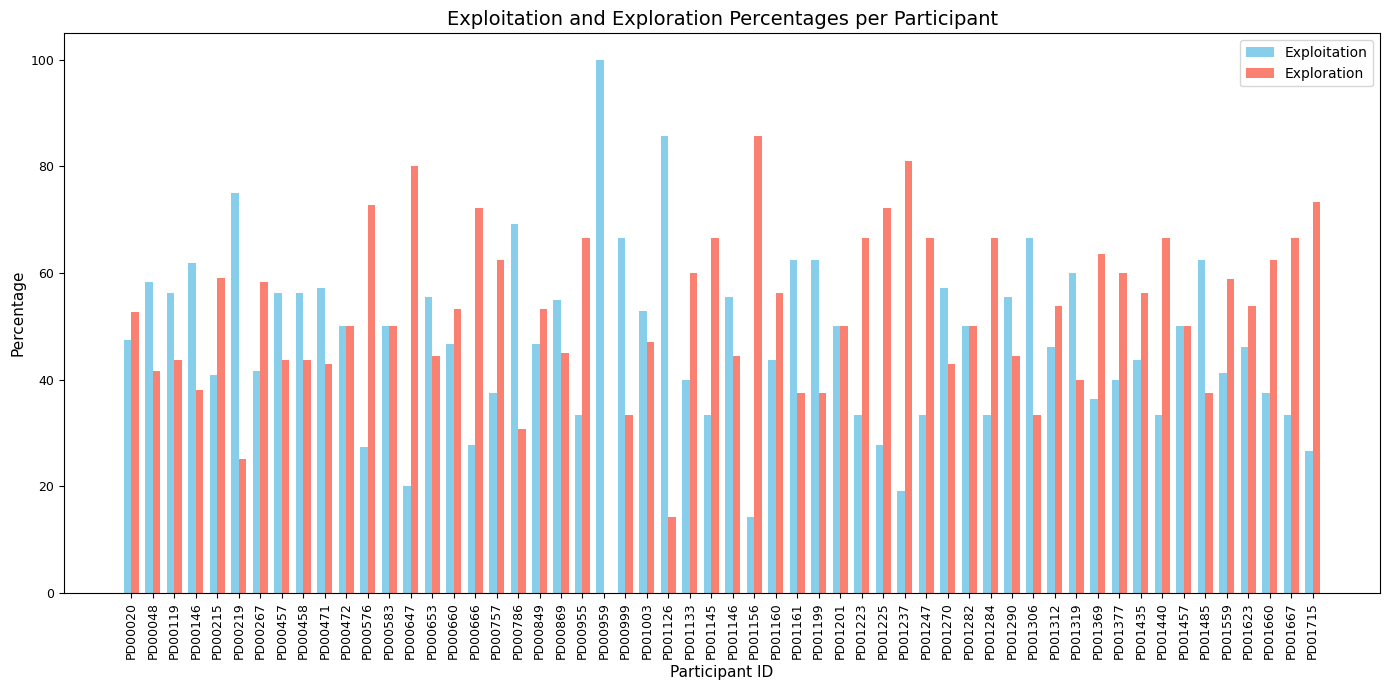

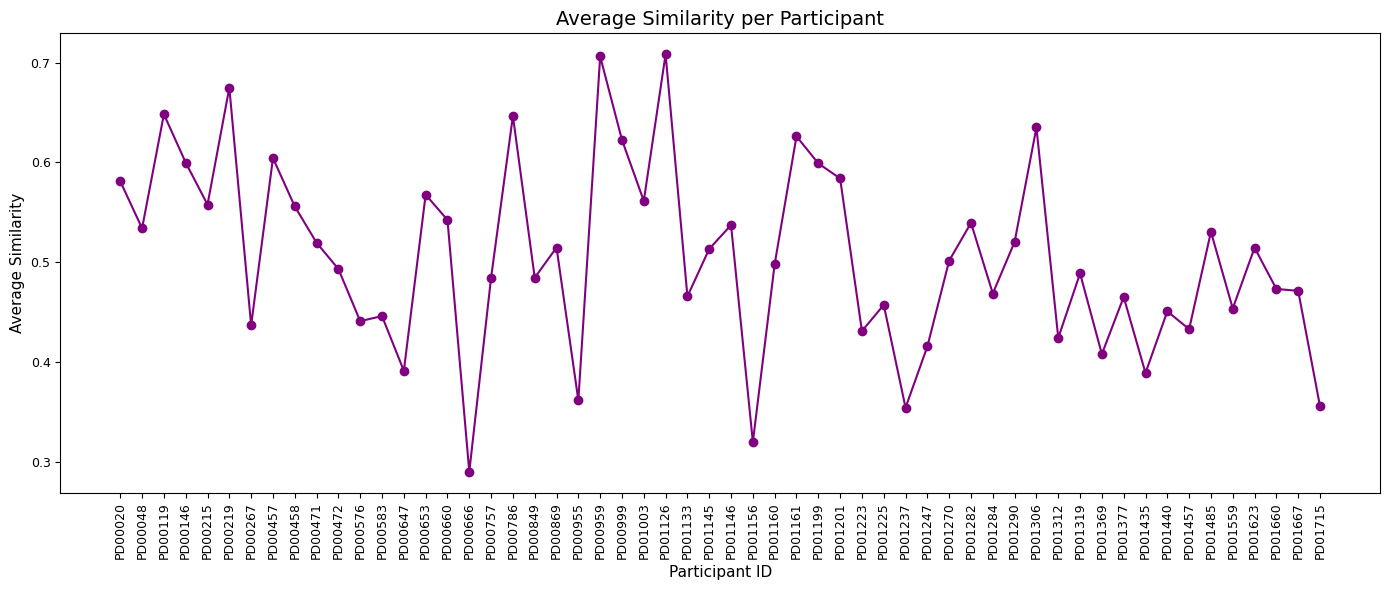

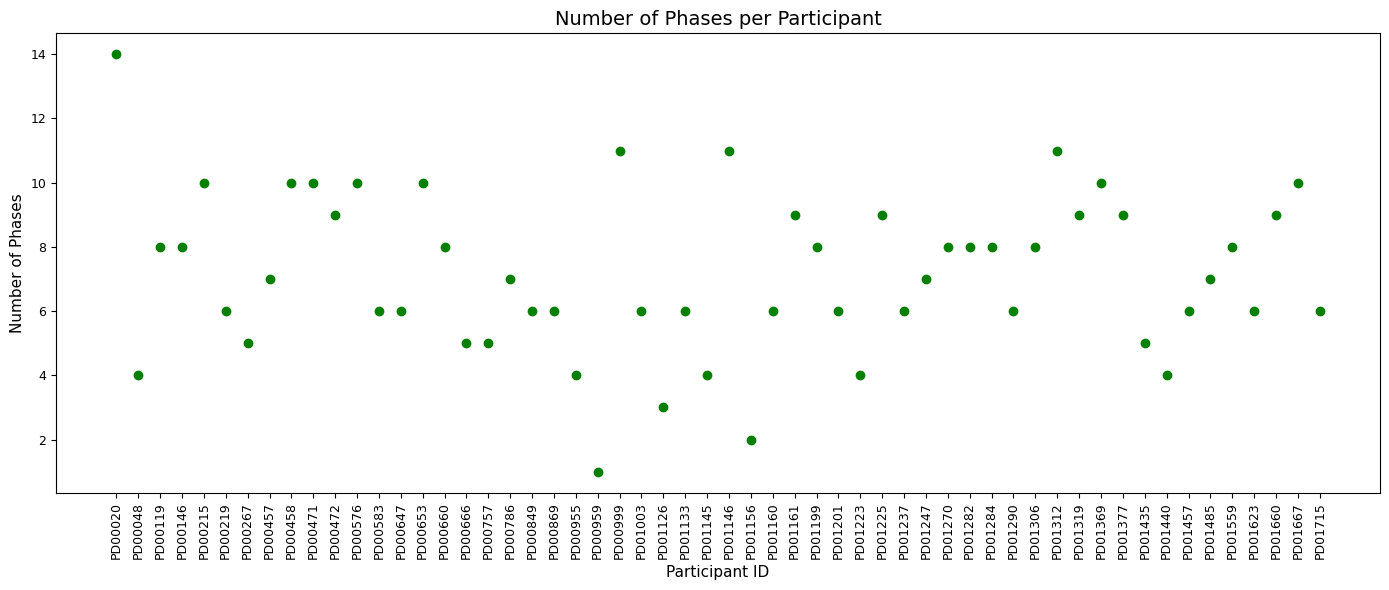

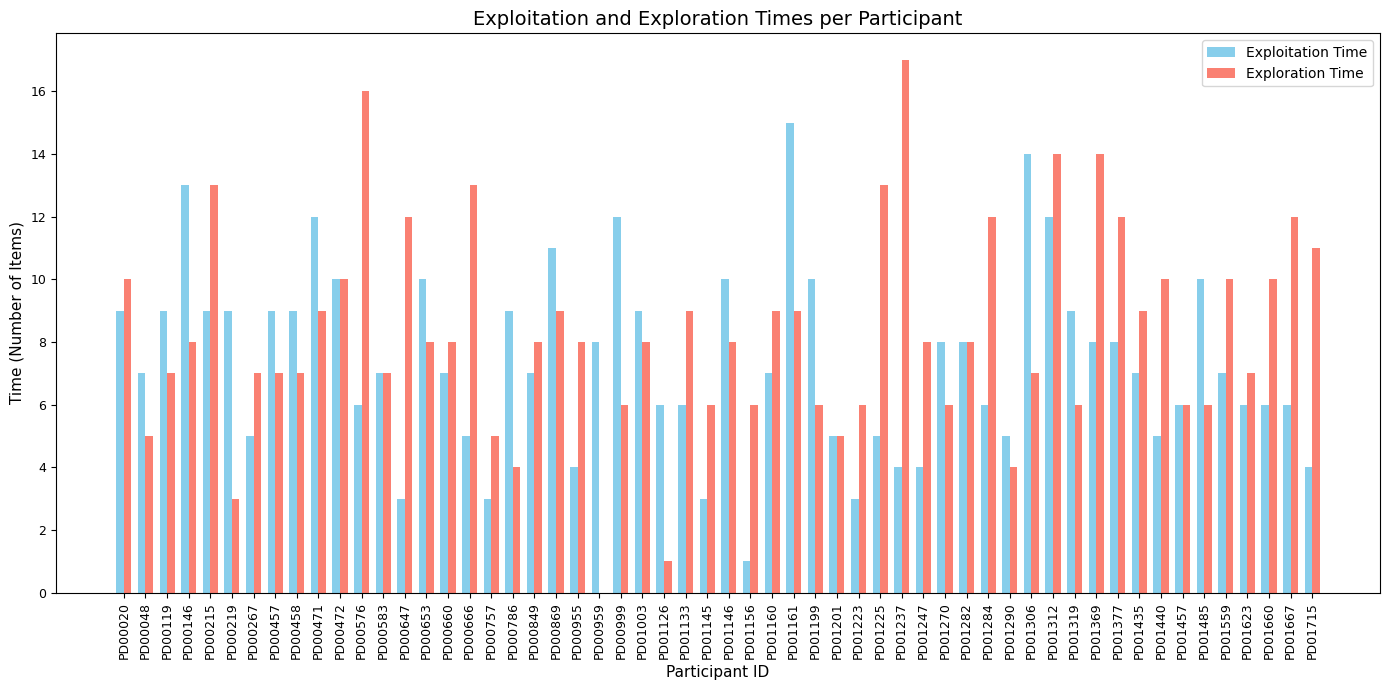

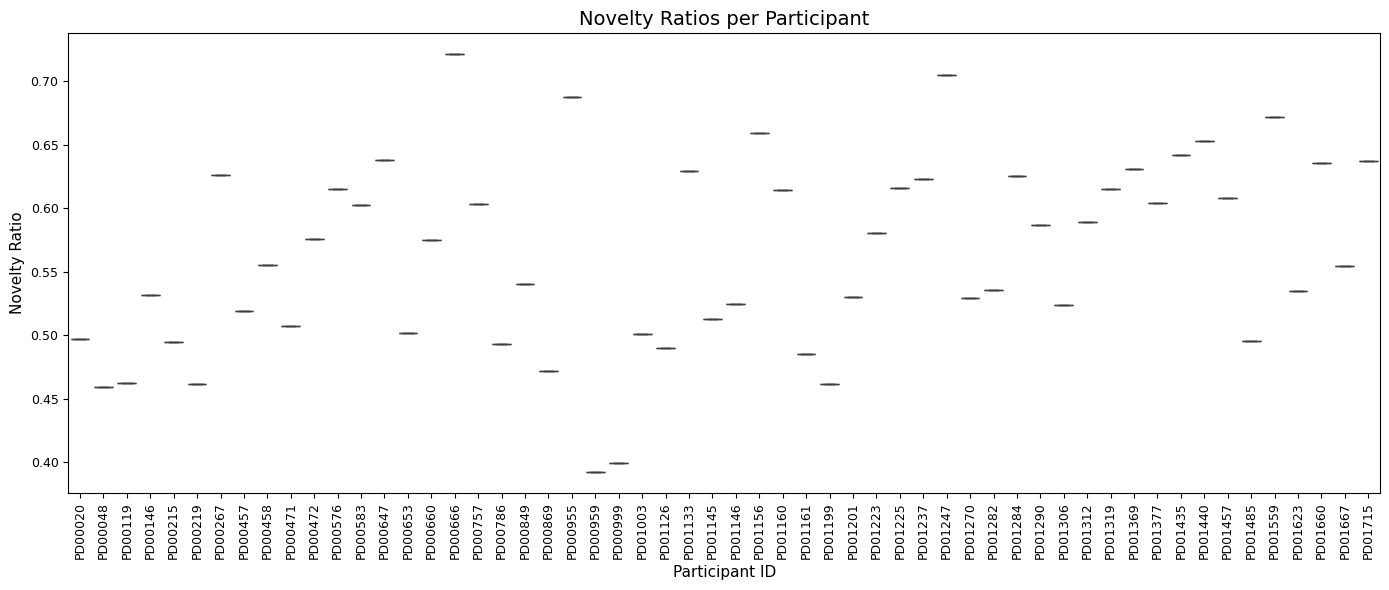

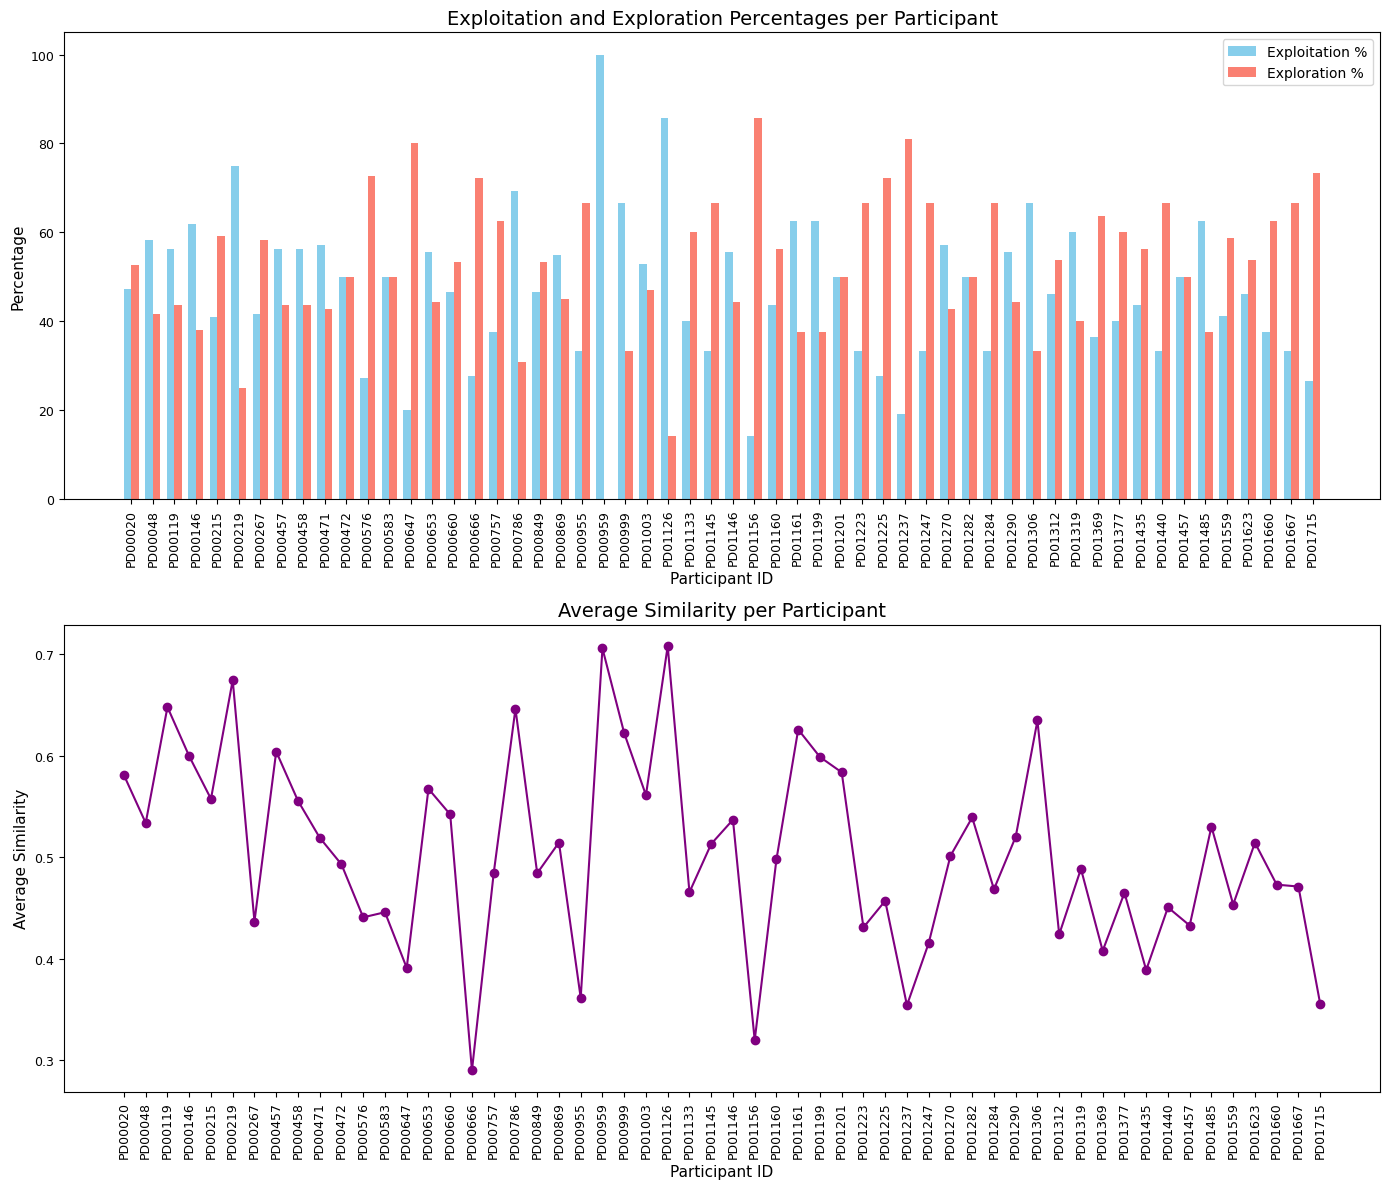

<Figure size 1400x600 with 0 Axes>

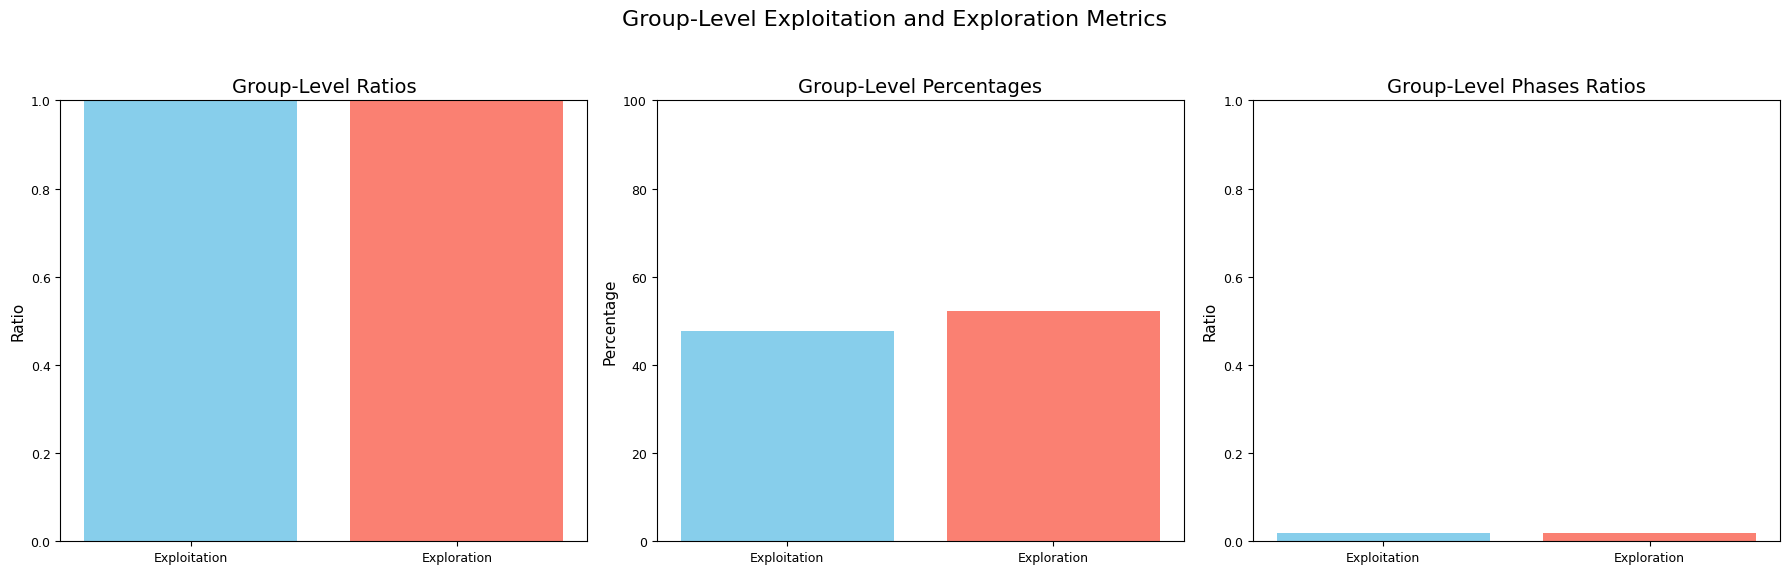

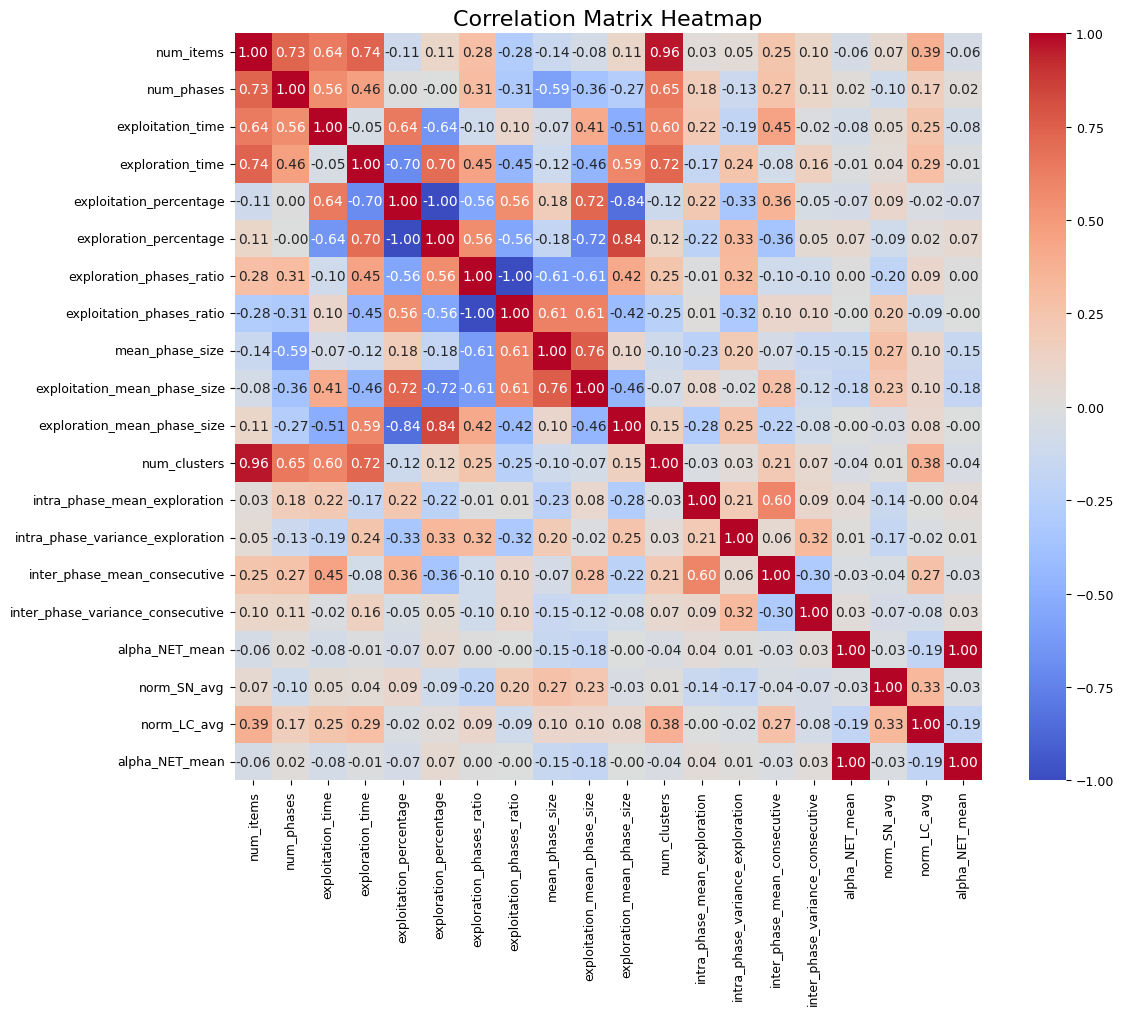

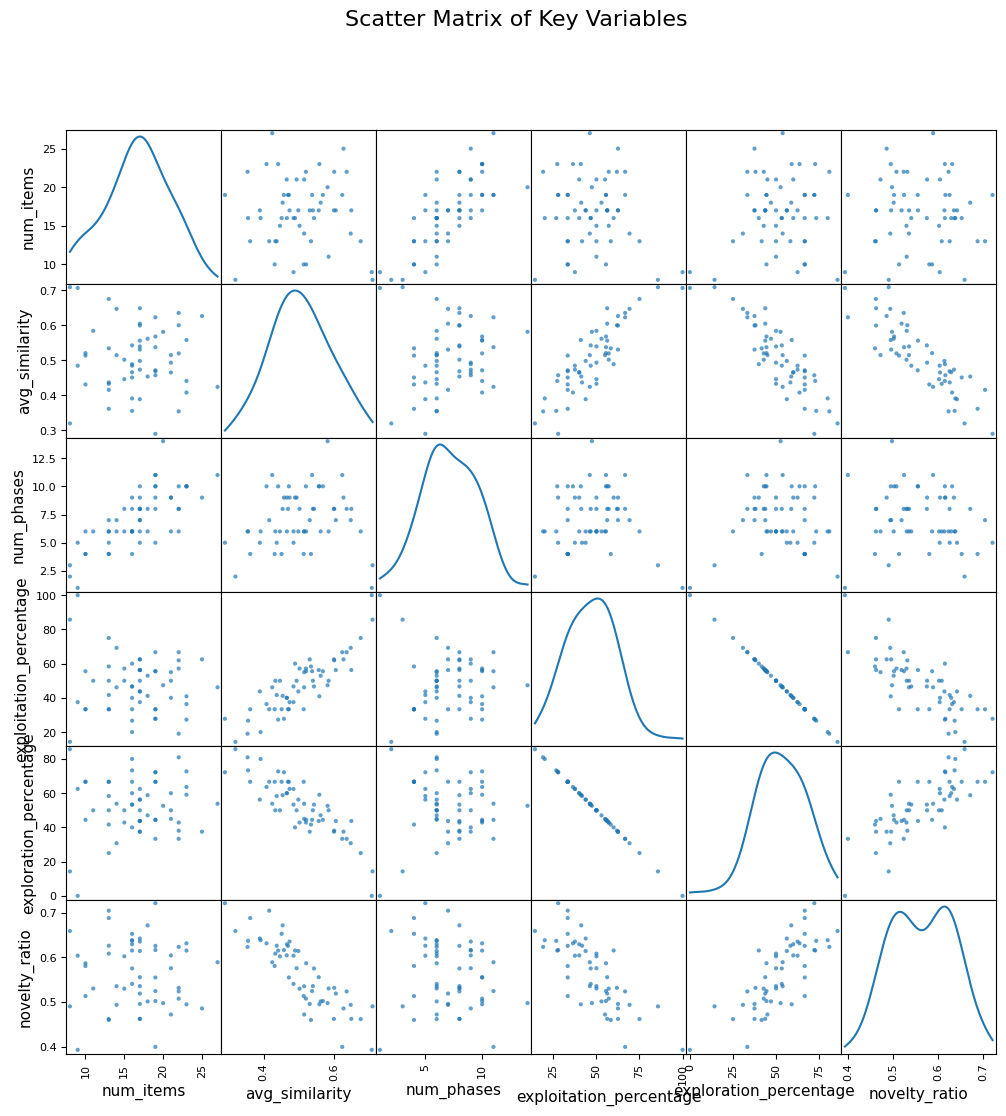

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort the DataFrame by participant IDs for consistent ordering
# results_df = results_df.sort_values('participant')

# Extract data
participants = results_df['participant']
exploitation = results_df['exploitation_percentage']
exploration = results_df['exploration_percentage']
print(f'participant={participants}')
print(f'exploitation_percentage: {exploitation}')
print(f'exploration_percentage: {exploration}')

# Set up the bar plot
bar_width = 0.35
index = np.arange(len(participants))

fig, ax = plt.subplots(figsize=(14, 7))

# Plot exploitation percentages
ax.bar(index, exploitation, bar_width, label='Exploitation', color='skyblue')

# Plot exploration percentages next to exploitation
ax.bar(index + bar_width, exploration, bar_width, label='Exploration', color='salmon')

# Set labels and title
ax.set_xlabel('Participant ID')
ax.set_ylabel('Percentage')
ax.set_title('Exploitation and Exploration Percentages per Participant')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(participants, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


# Plot Average Similarity
plt.figure(figsize=(14, 6))

plt.plot(results_df['participant'], results_df['avg_similarity'], marker='o', linestyle='-', color='purple')

plt.xlabel('Participant ID')
plt.ylabel('Average Similarity')
plt.title('Average Similarity per Participant')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Plot Number of Phases
plt.figure(figsize=(14, 6))

plt.scatter(results_df['participant'], results_df['num_phases'], color='green')

plt.xlabel('Participant ID')
plt.ylabel('Number of Phases')
plt.title('Number of Phases per Participant')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Plot Exploitation and Exploration Times
exploitation_time = results_df['exploitation_time']
exploration_time = results_df['exploration_time']

fig, ax = plt.subplots(figsize=(14, 7))

# Plot exploitation times
ax.bar(index, exploitation_time, bar_width, label='Exploitation Time', color='skyblue')

# Plot exploration times next to exploitation times
ax.bar(index + bar_width, exploration_time, bar_width, label='Exploration Time', color='salmon')

# Set labels and title
ax.set_xlabel('Participant ID')
ax.set_ylabel('Time (Number of Items)')
ax.set_title('Exploitation and Exploration Times per Participant')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(participants, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


# Plot Novelty Ratios
plt.figure(figsize=(14, 6))

sns.boxplot(x='participant', y='novelty_ratio', data=results_df)

plt.xlabel('Participant ID')
plt.ylabel('Novelty Ratio')
plt.title('Novelty Ratios per Participant')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Combined Subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Subplot 1: Exploitation and Exploration Percentages
axs[0].bar(index, exploitation, bar_width, label='Exploitation %', color='skyblue')
axs[0].bar(index + bar_width, exploration, bar_width, label='Exploration %', color='salmon')
axs[0].set_xlabel('Participant ID')
axs[0].set_ylabel('Percentage')
axs[0].set_title('Exploitation and Exploration Percentages per Participant')
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels(participants, rotation=90)
axs[0].legend()

# Subplot 2: Average Similarity
axs[1].plot(participants, results_df['avg_similarity'], marker='o', linestyle='-', color='purple')
axs[1].set_xlabel('Participant ID')
axs[1].set_ylabel('Average Similarity')
axs[1].set_title('Average Similarity per Participant')
axs[1].set_xticks(participants)
axs[1].set_xticklabels(participants, rotation=90)

plt.tight_layout()
plt.show()


# General Data Views

# Assuming you have 'correlations' DataFrame/matrix
# If not, compute it:

plt.figure(figsize=(14, 6))

# Ratios and Percentages
ratios = [results_df['exploitation_time'].mean(), results_df['exploration_time'].mean()]
percentages = [results_df['exploitation_percentage'].mean(), results_df['exploration_percentage'].mean()]
phases_ratios = [results_df['exploitation_time'].mean() / results_df['exploitation_time'].sum(),
                 results_df['exploration_time'].mean() / results_df['exploration_time'].sum()]
labels = ['Exploitation', 'Exploration']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Ratios
axes[0].bar(labels, ratios, color=['skyblue', 'salmon'])
axes[0].set_title('Group-Level Ratios')
axes[0].set_ylabel('Ratio')
axes[0].set_ylim(0, 1)

# Plot 2: Percentages
axes[1].bar(labels, percentages, color=['skyblue', 'salmon'])
axes[1].set_title('Group-Level Percentages')
axes[1].set_ylabel('Percentage')
axes[1].set_ylim(0, 100)

# Plot 3: Phases Ratios
axes[2].bar(labels, phases_ratios, color=['skyblue', 'salmon'])
axes[2].set_title('Group-Level Phases Ratios')
axes[2].set_ylabel('Ratio')
axes[2].set_ylim(0, 1)

plt.suptitle('Group-Level Exploitation and Exploration Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Correlation Matrix Heatmap
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


# Scatter Matrix
from pandas.plotting import scatter_matrix

# Select key variables
key_variables = [
    'num_items', 'avg_similarity', 'num_phases',
    'exploitation_percentage', 'exploration_percentage', 'novelty_ratio'
]

# Create scatter matrix
scatter_matrix(results_df[key_variables], figsize=(12, 12), diagonal='kde', alpha=0.7)

plt.suptitle('Scatter Matrix of Key Variables', fontsize=16)
plt.show()



In [ ]:

# Distribution of Mean Similarities
plt.figure(figsize=(10, 6))

# Extract mean similarities
intra_means = results_df['intra_phase_mean_exploitation']
inter_means = results_df['inter_phase_mean_exploitation']

# Plot density plots
sns.kdeplot(intra_means, shade=True, color='blue', label='Exploitation Intra-Phase Mean Similarity')
sns.kdeplot(inter_means, shade=True, color='green', label='Exploitation Inter-Phase Mean Similarity')

plt.title('Distribution of Intra-Phase and Inter-Phase Mean Exploitation Similarities', fontsize=16)
plt.xlabel('Mean Similarity')
plt.legend()
plt.tight_layout()
plt.show()


# Combined Subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Subplot 1: Combined Bar Plot
axs[0, 0].bar(labels, ratios, color=['skyblue', 'salmon'], alpha=0.7, label='Ratios')
axs[0, 0].bar(labels, percentages, color=['navy', 'darkred'], alpha=0.5, label='Percentages')
axs[0, 0].set_title('Group-Level Ratios and Percentages', fontsize=14)
axs[0, 0].set_ylabel('Value')
axs[0, 0].legend()

# Subplot 2: Heatmap
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True, ax=axs[0, 1])
axs[0, 1].set_title('Correlation Matrix Heatmap', fontsize=14)

# Subplot 3: Overlaid Density Plot
sns.kdeplot(intra_means, shade=True, color='blue', label='Intra-Phase', ax=axs[1, 0])
sns.kdeplot(inter_means, shade=True, color='green', label='Inter-Phase', ax=axs[1, 0])
axs[1, 0].set_title('Mean Similarity Distributions', fontsize=14)
axs[1, 0].set_xlabel('Mean Similarity')
axs[1, 0].legend()

# Subplot 4: Scatter Plot (Exploitation % vs. Avg Similarity)
sns.scatterplot(
    data=results_df, x='exploitation_percentage', y='avg_similarity', ax=axs[1, 1], color='purple'
)
axs[1, 1].set_title('Exploitation Percentage vs. Average Similarity', fontsize=14)
axs[1, 1].set_xlabel('Exploitation Percentage (%)')
axs[1, 1].set_ylabel('Average Similarity')

plt.suptitle('Summary of Analysis', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Additional Group-Level Plots

# Group-Level Ratios
ratios = [results_df['exploitation_time'].mean(), results_df['exploration_time'].mean()]
labels = ['Exploitation Ratio', 'Exploration Ratio']

plt.figure(figsize=(8, 6))
plt.bar(labels, ratios, color=['skyblue', 'salmon'])
plt.title('Group-Level Exploitation and Exploration Ratios')
plt.ylabel('Ratio')
plt.ylim(0, 1)
plt.show()

# Group-Level Percentages
percentages = [results_df['exploitation_percentage'].mean(), results_df['exploration_percentage'].mean()]
labels = ['Exploitation Percentage', 'Exploration Percentage']

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['skyblue', 'salmon'])
plt.title('Group-Level Exploitation and Exploration Percentages')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()


# Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


# Exploitation Percentage vs. Average Similarity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='exploitation_percentage', y='avg_similarity')
plt.title('Exploitation Percentage vs. Average Similarity')
plt.xlabel('Exploitation Percentage (%)')
plt.ylabel('Average Similarity')
plt.show()


# Number of Items vs. Number of Phases
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='num_items', y='num_phases')
plt.title('Number of Items vs. Number of Phases')
plt.xlabel('Number of Items')
plt.ylabel('Number of Phases')
plt.show()

**Plot Inter/Intra cluster similarities**
Plots the calculated permutations of all cosine scores between each other words in the phase

In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Group the flattened similarities per participant for intra- and inter-phase
# grouped_intra_phase_sims = results_df.groupby('participant')['flattened_intra_phase_similarities_exploitation'].apply(list)
# grouped_inter_phase_sims = results_df.groupby('participant')['flattened_inter_phase_similarities_exploitation'].apply(list)

# # Define function to plot per participant
# def plot_similarity_distributions_per_participant(grouped_df):
#     for participant, intra_sims in grouped_df['flattened_intra_phase_similarities_exploitation'].items():
#         inter_sims = grouped_df.loc[participant, 'flattened_inter_phase_similarities_exploitation']
#         intra_mean = grouped_df.loc[participant, 'intra_phase_mean_exploitation']
#         intra_variance = grouped_df.loc[participant, 'intra_phase_variance_exploitation']
#         inter_mean = grouped_df.loc[participant, 'inter_phase_mean_exploitation']
#         inter_variance = grouped_df.loc[participant, 'inter_phase_variance_exploitation']

#         plt.figure(figsize=(14, 6))

#         # Intra-Phase Similarity Plot
#         plt.subplot(1, 2, 1)
#         sns.histplot(intra_sims, kde=True, bins=10, color='skyblue')
#         plt.title(
#             f'Participant {participant}\nIntra-Phase Similarities Exploitation\n'
#             f'Mean = {intra_mean:.2f}, Variance = {intra_variance:.2f}'
#         )
#         plt.xlabel('Cosine Similarity')
#         plt.ylabel('Frequency')

#         # Inter-Phase Similarity Plot
#         plt.subplot(1, 2, 2)
#         sns.histplot(inter_sims, kde=True, bins=10, color='salmon')
#         plt.title(
#             f'Participant {participant}\nInter-Phase Similarities Exploitation\n'
#             f'Mean = {inter_mean:.2f}, Variance = {inter_variance:.2f}'
#         )
#         plt.xlabel('Cosine Similarity')
#         plt.ylabel('Frequency')

#         plt.tight_layout()
#         plt.show()

# # Call the function with the grouped data
# plot_similarity_distributions_per_participant(results_df.set_index('participant'))

Implementation of Traditional, SoftMax, and MVT Models for Semantic Verbal Fluency

In [ ]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# import ast
# def plot_similarity_distributions_group_level(merged_df):
#     """
#     Generates a combined plot displaying Intra-Phase and Inter-Phase similarity distributions
#     for all participants at the group level.

#     Parameters:
#     - merged_df (pd.DataFrame): DataFrame containing participants' similarity data,
#                                 including columns merged from phase proximity analysis.

#     The DataFrame is expected to have the following columns (potentially with _proximity suffix for means/variances):
#         - 'participant': str, participant identifier.
#         - 'intra_phase_similarities_exploitation': list, list of intra-phase similarities lists.
#         - 'intra_phase_mean_exploitation_proximity': float, mean of intra-phase exploitation similarities.
#         - 'intra_phase_variance_exploitation_proximity': float, variance of intra-phase exploitation similarities.
#         - 'inter_phase_similarities_consecutive': list, list of consecutive inter-phase similarities tuples.
#         - 'inter_phase_mean_consecutive': float, mean of consecutive inter-phase similarities.
#         - 'inter_phase_variance_consecutive': float, variance of consecutive inter-phase similarities.
#         # Add exploration phase columns if needed for future plotting
#         # - 'intra_phase_similarities_exploration': list
#         # - 'intra_phase_mean_exploration_proximity': float
#         # - 'intra_phase_variance_exploration_proximity': float
#     """

#     # Create copies to avoid SettingWithCopyWarning
#     df = merged_df.copy()

#     # Columns for plotting
#     # Use the actual column names from the merged_df_all after proximity analysis
#     intra_exploit_sims_col = 'intra_phase_similarities_exploitation'
#     intra_exploit_mean_col = 'intra_phase_mean_exploitation_proximity'
#     intra_exploit_variance_col = 'intra_phase_variance_exploitation_proximity'
#     inter_consecutive_sims_col = 'inter_phase_similarities_consecutive' # Use consecutive inter-phase
#     inter_consecutive_mean_col = 'inter_phase_mean_consecutive'
#     inter_consecutive_variance_col = 'inter_phase_variance_consecutive'

#     # Check if required columns exist
#     required_cols = [
#         intra_exploit_sims_col, intra_exploit_mean_col, intra_exploit_variance_col,
#         inter_consecutive_sims_col, inter_consecutive_mean_col, inter_consecutive_variance_col,
#         'participant'
#     ]
#     if not all(col in df.columns for col in required_cols):
#         missing = [col for col in required_cols if col not in df.columns]
#         print(f"Error: Required columns not found in the DataFrame: {missing}")
#         print("Please ensure the phase proximity calculations (cell g6l6nQnTB7I9) have been run and merged into merged_df_all.")
#         return


#     # Prepare data for plotting Intra-Phase Exploitation distributions
#     intra_exploit_data = []
#     for index, row in df.iterrows():
#         participant = row['participant']
#         # The structure is a list of (list_of_sims, 'Phase Name') tuples
#         if row[intra_exploit_sims_col] is not None:
#             for sim_list, phase_name in row[intra_exploit_sims_col]:
#                  intra_exploit_data.extend([(participant, phase_name, sim) for sim in sim_list])

#     if not intra_exploit_data:
#         print("No intra-phase exploitation data available for plotting.")
#         intra_exploit_df_grouped = pd.DataFrame(columns=['participant', 'Phase', 'Mean_Similarity']) # Empty DataFrame
#     else:
#         intra_exploit_df_flat = pd.DataFrame(intra_exploit_data, columns=['participant', 'Phase', 'Similarity'])
#         # Group by participant and phase to get mean similarity per phase
#         intra_exploit_df_grouped = intra_exploit_df_flat.groupby(['participant', 'Phase'])['Similarity'].mean().reset_index(name='Mean_Similarity')


#     # Prepare data for plotting Inter-Phase Consecutive distributions
#     inter_consecutive_data = []
#     for index, row in df.iterrows():
#         participant = row['participant']
#         # The structure is a list of (sim, 'Pair Name') tuples
#         if row[inter_consecutive_sims_col] is not None:
#             for sim, pair_name in row[inter_consecutive_sims_col]:
#                  inter_consecutive_data.append((participant, pair_name, sim))

#     if not inter_consecutive_data:
#          print("No inter-phase consecutive similarity data available for plotting.")
#          inter_consecutive_df = pd.DataFrame(columns=['participant', 'Pair', 'Similarity']) # Empty DataFrame
#     else:
#         inter_consecutive_df = pd.DataFrame(inter_consecutive_data, columns=['participant', 'Pair', 'Similarity'])


#     # Set the style
#     sns.set(style="whitegrid")

#     # Initialize the matplotlib figure
#     # Using 2 rows, 1 column to avoid too many bars in a single plot if many phases
#     fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True) # Adjusted layout
#     fig.suptitle('Phase Similarity Distributions Across Participants', fontsize=20, y=1.02)


#     # Plot Intra-Phase Exploitation Mean Similarities per Phase per Participant
#     if not intra_exploit_df_grouped.empty:
#         sns.barplot(ax=axes[0], x='participant', y='Mean_Similarity', hue='Phase',
#                     data=intra_exploit_df_grouped, palette='Blues_d', ci=None) # Use hue for phases within participant
#         axes[0].set_title('Intra-Phase Exploitation Mean Similarities per Phase', fontsize=16)
#         axes[0].set_xlabel('Participant', fontsize=14)
#         axes[0].set_ylabel('Mean Cosine Similarity', fontsize=14)
#         axes[0].tick_params(axis='x', rotation=45, ha='right', labelsize=10)
#         axes[0].legend(title='Exploitation Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
#     else:
#          axes[0].text(0.5, 0.5, 'No Intra-Phase Exploitation Data', horizontalalignment='center', verticalalignment='center', fontsize=12, color='gray', transform=axes[0].transAxes)
#          axes[0].set_title('Intra-Phase Exploitation Mean Similarities per Phase', fontsize=16)
#          axes[0].set_xlabel('Participant', fontsize=14)
#          axes[0].set_ylabel('Mean Cosine Similarity', fontsize=14)
#          axes[0].tick_params(axis='x', rotation=45, ha='right', labelsize=10)


#     # Plot Inter-Phase Consecutive Similarities per Pair per Participant
#     if not inter_consecutive_df.empty:
#         # Plotting each inter-phase similarity score as a point or a bar
#         # Using a scatter plot with lines to show sequence might be better than a bar plot for many pairs
#         # Let's use a scatter plot for simplicity, or a line plot if we can order by transition index
#         # For simplicity, let's plot mean inter-phase similarity per participant as a bar
#         inter_consecutive_mean_per_participant = df.groupby('participant')[inter_consecutive_mean_col].mean().reset_index(name='Mean_Similarity')

#         sns.barplot(ax=axes[1], x='participant', y='Mean_Similarity',
#                     data=inter_consecutive_mean_per_participant, palette='Reds_d', ci=None)
#         # Add error bars for variance (standard deviation)
#         # Need to calculate std of mean inter-phase similarity per participant
#         inter_consecutive_std_per_participant = df.groupby('participant')[inter_consecutive_mean_col].std().reset_index(name='Std_Similarity')
#         # Merge mean and std for error bars
#         inter_plot_data = pd.merge(inter_consecutive_mean_per_participant, inter_consecutive_std_per_participant, on='participant')

#         axes[1].errorbar(x=np.arange(len(inter_plot_data)),
#                          y=inter_plot_data['Mean_Similarity'],
#                          yerr=inter_plot_data['Std_Similarity'], # Using std of means here, or std of all inter-phase sims?
#                          fmt='none', c='black', capsize=5)

#         axes[1].set_title('Inter-Phase Consecutive Mean Similarities per Participant', fontsize=16)
#         axes[1].set_xlabel('Participant', fontsize=14)
#         axes[1].set_ylabel('Mean Cosine Similarity', fontsize=14)
#         axes[1].tick_params(axis='x', rotation=45, ha='right', labelsize=10)
#     else:
#         axes[1].text(0.5, 0.5, 'No Inter-Phase Consecutive Data', horizontalalignment='center', verticalalignment='center', fontsize=12, color='gray', transform=axes[1].transAxes)
#         axes[1].set_title('Inter-Phase Consecutive Mean Similarities per Participant', fontsize=16)
#         axes[1].set_xlabel('Participant', fontsize=14)
#         axes[1].set_ylabel('Mean Cosine Similarity', fontsize=14)
#         axes[1].tick_params(axis='x', rotation=45, ha='right', labelsize=10)

#     # Adjust layout
#     plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjusted rect for suptitle
#     plt.show()

# # Call the function with merged_df_all
# if 'merged_df_all' in locals() and isinstance(merged_df_all, pd.DataFrame):
#     plot_similarity_distributions_group_level(merged_df_all)
# else:
#     print("Error: merged_df_all DataFrame is not available. Please run the preceding cells including the phase proximity analysis.")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import pearsonr, spearmanr
import spacy
import io
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('ggplot')
sns.set_context("talk")

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'  # Ensures text remains as text in SVG (not paths)

# Load spaCy model for word vectors
print("Loading spaCy model...")
nlp = spacy.load("en_core_web_md")
print("SpaCy model loaded successfully")

# Load the data
def load_data():
    """
    Load and prepare SVF data and MEG/LC data
    """
    # Sample data string (replace with your actual data loading code)
    data_str = '''ID,Item
    PD00020,"Lion,Tiger,Sheep,Dog,Cat,Camel,Monkey,Chimpanzee,Buffalo,Hyena,Dog,Cat,Elephant,Hyena,Dog,Cat,Mouse,Bird,Camel,Dragon"
    PD00048,"Lion,Hare,Elephant,Rhinoceros,Monkey,Giraffe,Cow,Elk,Fish,Horse,Tiger,Leopard,Jaguar"
    PD00119,"Lion,Tiger,Duck,Goose,Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippo,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
    PD00146,"Dog,Pig,Chicken,Partridge,Swallow,Squirrel,Rabbit,Horse,Hare,Calf,Bull,Cow,Lion,Tiger,Monkey,Giraffe,Elephant,Snake,Frog,Shark,Whale,Dolphin"
    PD00215,"Donkey,Horse,Cow,Ox,Elephant,Llama,Cat,Dog,Mouse,Tiger,Lion,Leopard,Cheetah,Hyena,Bear,Goat,Partridge,Hare,Manatee,Turtle,Iguana,Frog,Toad"
    '''

    # Load the data into a DataFrame
    compressed_data = pd.read_csv(io.StringIO(data_str))

    # Expand the data
    data = compressed_data.set_index('ID')['Item'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='Item')

    # Preprocess the data
    data['Item'] = data['Item'].str.lower()
    data = data.dropna().reset_index(drop=True)

    # Load the MEG PSD and LC data
    meg_lc_data = pd.read_csv(io.StringIO('''
    PD00020,0.005821693,PD,MRI01,1.14817625,1.158620797,1.044436934,1.016706475,1.153398524,1.030571705
    PD00048,0.002184409,PD,MRI01,1.098492193,1.109323313,1.085092243,0.965901336,1.103907753,1.02549679
    PD00146,0.005128224,PD,MRI01,1.12043934,1.125366723,1.041352235,1.026072416,1.122903032,1.033712326
    PD00215,0.010895761,PD,MRI01,1.124369462,1.147340095,1.107812477,1.04618484,1.135854779,1.076998659
    '''), header=None, names=['ID','alpha_NET_mean','status','visit','norm_SN_l','norm_SN_r','norm_LC_l','norm_LC_r','norm_SN_avg','norm_LC_avg'])

    meg_lc_data = meg_lc_data[meg_lc_data['norm_SN_avg'].notna()]

    # Remove 'PD' and leading zeros
    clean_id = lambda x: str(int(x.replace('PD', '')))
    data['clean_ID'] = data['ID'].apply(clean_id)
    meg_lc_data['clean_ID'] = meg_lc_data['ID'].apply(clean_id)

    print(f"Loaded data for {len(data['ID'].unique())} participants with SVF data")
    print(f"Loaded MEG/LC data for {len(meg_lc_data)} participants")

    return data, meg_lc_data

# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    """
    Calculate cosine similarity between two vectors
    """
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Function to identify exploitation and exploration phases
def identify_phases(similarities, items, vectors, threshold):
    """
    Identify exploitation and exploration phases based on similarity threshold
    """
    if len(similarities) < 1:
        return []
    phases = []
    current_phase = "Exploitation" if similarities[0] > threshold else "Exploration"
    phase_start = 0

    for i in range(1, len(similarities)):
        if (current_phase == "Exploitation" and similarities[i] <= threshold) or \
           (current_phase == "Exploration" and similarities[i] > threshold):
            phase = (current_phase, phase_start, i, items[phase_start:i+1], vectors[phase_start:i+1], similarities[phase_start:i+1])
            phases.append(phase)

            current_phase = "Exploration" if current_phase == "Exploitation" else "Exploitation"
            phase_start = i

    # Add the final phase
    lastone = len(similarities)
    phase = (current_phase, phase_start, lastone, items[phase_start:lastone+1], vectors[phase_start:lastone+1], similarities[phase_start:lastone+1])
    phases.append(phase)

    return phases

# Function to analyze participant responses
def analyze_responses(participant_data, threshold):
    """
    Analyze participant's SVF responses using traditional phase identification
    """
    participant = participant_data['participant']
    items = participant_data['items']
    vectors = participant_data['vectors']
    similarities = participant_data['similarities']

    # Identify phases based on threshold
    phases = identify_phases(similarities, items, vectors, threshold)

    # Perform hierarchical clustering
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5)
    clusters = clustering.fit_predict([vector for vector in vectors])

    # Calculate novelty scores (new words vs. repetitions)
    unique_items = set()
    novelty_scores = []
    for item in items:
        if item not in unique_items:
            novelty_scores.append(1)
            unique_items.add(item)
        else:
            novelty_scores.append(0)

    # Calculate phase statistics
    num_switches = len(phases) - 1
    exploitation_phase_size = [end - start for phase, start, end, words, vects, sims in phases if phase == "Exploitation"]
    exploration_phase_size = [end - start for phase, start, end, words, vects, sims in phases if phase == "Exploration"]

    # Calculate mean phase sizes
    exploitation_mean_phase_size = np.mean(exploitation_phase_size) if exploitation_phase_size else 0
    exploration_mean_phase_size = np.mean(exploration_phase_size) if exploration_phase_size else 0
    mean_phase_size = np.mean(exploitation_phase_size + exploration_phase_size) if (exploitation_phase_size + exploration_phase_size) else 0

    # Calculate exploration-exploitation tradeoff
    ee_tradeoff = mean_phase_size / num_switches if num_switches > 0 else 0

    # Calculate exploitation and exploration times
    exploitation_time = sum(exploitation_phase_size)
    exploration_time = sum(exploration_phase_size)
    total_time = exploitation_time + exploration_time

    # Calculate percentages
    exploitation_percentage = (exploitation_time / total_time) * 100 if total_time > 0 else 0
    exploration_percentage = (exploration_time / total_time) * 100 if total_time > 0 else 0

    return {
        'participant': participant,
        'items': items,
        'vectors': vectors,
        'phases': phases,
        'avg_similarity': np.mean(similarities) if similarities else 0,
        'novelty_scores': novelty_scores,
        'exploitation_time': exploitation_time,
        'exploration_time': exploration_time,
        'exploitation_percentage': exploitation_percentage,
        'exploration_percentage': exploration_percentage,
        'clusters': clusters,
        'mean_phase_size': mean_phase_size,
        'exploitation_mean_phase_size': exploitation_mean_phase_size,
        'exploration_mean_phase_size': exploration_mean_phase_size,
        'ee_tradeoff': ee_tradeoff
    }

# SoftMax Model Functions
def softmax_likelihood(beta, word_sequence, similarity_matrix, word_to_idx):
    """
    Calculate the log-likelihood of a word sequence given a SoftMax temperature parameter.

    Parameters:
    beta (float): SoftMax temperature parameter
    word_sequence (list): Sequence of words
    similarity_matrix (np.array): Matrix of semantic similarities
    word_to_idx (dict): Mapping from words to matrix indices

    Returns:
    float: Log-likelihood of the sequence
    """
    log_likelihood = 0

    for i in range(len(word_sequence) - 1):
        current_word = word_sequence[i]
        next_word = word_sequence[i + 1]

        # Get indices
        current_idx = word_to_idx[current_word]
        next_idx = word_to_idx[next_word]

        # Get similarities to all words from current word
        similarities = similarity_matrix[current_idx, :]

        # Calculate SoftMax probabilities
        numerators = np.exp(beta * similarities)
        denominator = np.sum(numerators)
        probabilities = numerators / denominator

        # Add log probability of the actual chosen word
        if probabilities[next_idx] > 0:  # Avoid log(0)
            log_likelihood += np.log(probabilities[next_idx])
        else:
            log_likelihood += -100  # Very low log probability as penalty

    return log_likelihood

def find_optimal_beta(word_sequence, similarity_data):
    """
    Find the optimal SoftMax temperature parameter for a given word sequence.
    """
    similarity_matrix = similarity_data['matrix']
    word_to_idx = similarity_data['word_to_idx']

    # Only proceed if we have at least 2 words
    if len(word_sequence) < 2:
        return np.nan, {'status': 'failed', 'reason': 'sequence too short'}

    # Check all words are in the mapping
    if not all(word in word_to_idx for word in word_sequence):
        missing_words = [word for word in word_sequence if word not in word_to_idx]
        return np.nan, {'status': 'failed', 'reason': f'missing words: {missing_words}'}

    # Define negative log-likelihood function to minimize
    def neg_log_likelihood(beta):
        return -softmax_likelihood(beta, word_sequence, similarity_matrix, word_to_idx)

    # Find optimal beta using bounded optimization
    try:
        result = minimize_scalar(
            neg_log_likelihood,
            bounds=(0.1, 10),
            method='bounded'
        )

        optimal_beta = result.x
        min_neg_log_likelihood = result.fun

        # Calculate log-likelihood at optimal beta
        log_likelihood = -min_neg_log_likelihood

        # Calculate exploitation ratio based on beta
        # Higher values mean more deterministic (exploitation) behavior
        exploitation_ratio = 1 - np.exp(-optimal_beta)

        return optimal_beta, {
            'status': 'success',
            'log_likelihood': log_likelihood,
            'avg_likelihood': log_likelihood / (len(word_sequence) - 1),
            'exploitation_ratio': exploitation_ratio,
            'success': result.success,
            'message': str(result.message)
        }
    except Exception as e:
        print(f"Error in SoftMax optimization: {e}")
        return np.nan, {'status': 'failed', 'reason': str(e)}

# MVT Model Functions
def mvt_retrieval_rate(t, a, b):
    """
    Calculate the instantaneous retrieval rate at time t

    Parameters:
    t (float): Time spent in current patch
    a (float): Initial retrieval rate
    b (float): Decay rate

    Returns:
    float: Instantaneous retrieval rate
    """
    return a * np.exp(-b * t)

def mvt_cumulative_gain(t, a, b):
    """
    Calculate the cumulative gain at time t

    Parameters:
    t (float): Time spent in current patch
    a (float): Initial retrieval rate
    b (float): Decay rate

    Returns:
    float: Cumulative gain
    """
    return (a / b) * (1 - np.exp(-b * t))

def mvt_average_rate(t, a, b, c):
    """
    Calculate the average rate of gain including travel costs

    Parameters:
    t (float): Time spent in current patch
    a (float): Initial retrieval rate
    b (float): Decay rate
    c (float): Travel/switch cost

    Returns:
    float: Average rate of gain
    """
    return mvt_cumulative_gain(t, a, b) / (t + c)

def mvt_fit_error(params, similarity_sequence, threshold):
    """
    Calculate error between MVT model and observed exploitation/exploration pattern

    Parameters:
    params (tuple): (a, b, c) = initial rate, decay rate, switch cost
    similarity_sequence (list): Sequence of similarity values
    threshold (float): Threshold for exploitation/exploration

    Returns:
    float: Sum of squared errors
    """
    a, b, c = params

    # Calculate predicted optimal leaving time
    try:
        t_opt = (1/b) * np.log(a * b * c)
    except:
        return np.inf

    if t_opt <= 0:
        return np.inf

    # Convert similarity sequence to exploitation/exploration phases
    observed_phases = []
    current_phase = "exploitation" if similarity_sequence[0] > threshold else "exploration"
    phase_start = 0

    for i in range(1, len(similarity_sequence)):
        if (current_phase == "exploitation" and similarity_sequence[i] <= threshold) or \
           (current_phase == "exploration" and similarity_sequence[i] > threshold):

            observed_phases.append((current_phase, phase_start, i-1))
            current_phase = "exploration" if current_phase == "exploitation" else "exploitation"
            phase_start = i

    # Add final phase
    observed_phases.append((current_phase, phase_start, len(similarity_sequence)-1))

    # Calculate expected exploitation phase lengths based on MVT
    exploitation_phases = [phase for phase in observed_phases if phase[0] == "exploitation"]
    phase_lengths = [end - start + 1 for _, start, end in exploitation_phases]

    # Calculate squared error between observed and predicted
    error = 0
    for length in phase_lengths:
        error += (length - t_opt)**2

    return error

def find_optimal_mvt_params(similarity_sequence, threshold):
    """
    Find optimal MVT parameters for a given sequence

    Parameters:
    similarity_sequence (list): Sequence of similarity values
    threshold (float): Threshold for exploitation/exploration

    Returns:
    tuple: (a, b, c, t_opt) optimal parameters and leaving time
    dict: Additional information
    """
    # Initial guesses for a, b, c
    initial_params = [1.0, 0.5, 2.0]

    # Bounds for parameters
    bounds = ((0.1, 5.0), (0.1, 5.0), (0.1, 10.0))

    try:
        # Find optimal parameters
        result = minimize(
            lambda params: mvt_fit_error(params, similarity_sequence, threshold),
            initial_params,
            bounds=bounds,
            method='L-BFGS-B'
        )

        a, b, c = result.x

        # Calculate optimal leaving time
        t_opt = (1/b) * np.log(a * b * c)

        # Calculate model fit
        error = result.fun

        return (a, b, c, t_opt), {
            'status': 'success',
            'error': error,
            'success': result.success,
            'message': str(result.message)
        }
    except Exception as e:
        print(f"Error in MVT optimization: {e}")
        return (np.nan, np.nan, np.nan, np.nan), {'status': 'failed', 'reason': str(e)}

def prepare_data_for_modeling(data):
    """
    Prepare SVF data for SoftMax and MVT modeling
    """
    all_data = []  # Structure to store participant data
    all_similarities = []  # List for global similarity calculation

    for participant, group in data.groupby(['ID','clean_ID']):
        items = group['Item'].tolist()

        # Remove repetitions for cleaner analysis
        unique_items = []
        for item in items:
            if item not in unique_items:
                unique_items.append(item)

        # Compute word vectors for each unique item
        docs = [nlp(item) for item in unique_items if nlp(item).has_vector]
        vectors = [doc.vector for doc in docs]

        # Skip if not enough valid vectors
        if len(vectors) < 2:
            print(f"Warning: Not enough valid vectors for {participant[0]}")
            continue

        # Calculate cosine similarities
        similarities = [cosine_similarity(vectors[i], vectors[i+1]) for i in range(len(vectors) - 1)]

        # Append similarities to global list
        all_similarities.extend(similarities)

        # Create similarity matrix for SoftMax modeling
        unique_words = [doc.text for doc in docs]
        n_words = len(unique_words)
        word_to_idx = {word: i for i, word in enumerate(unique_words)}

        sim_matrix = np.zeros((n_words, n_words))
        for i, vec1 in enumerate(vectors):
            for j, vec2 in enumerate(vectors):
                sim = cosine_similarity(vec1, vec2)
                sim_matrix[i, j] = sim

        # Store participant data
        all_data.append({
            'participant': participant[0],
            'clean_ID': participant[1],
            'items': unique_items[:len(docs)],  # Only include items with valid vectors
            'vectors': vectors,
            'similarities': similarities,
            'similarity_data': {
                'matrix': sim_matrix,
                'word_to_idx': word_to_idx
            }
        })

    # Calculate global mean similarity for thresholding
    mean_similarity = np.mean(all_similarities)
    std_similarity = np.std(all_similarities)
    print(f"Mean Similarity: {mean_similarity:.4f}, Std: {std_similarity:.4f}")

    return all_data, mean_similarity

def run_model_comparison(all_data, mean_similarity, meg_lc_data):
    """
    Run model comparison between traditional, SoftMax, and MVT models
    """
    results = []

    for participant_data in tqdm(all_data, desc="Processing participants"):
        participant = participant_data['participant']
        items = participant_data['items']
        vectors = participant_data['vectors']
        similarities = participant_data['similarities']

        # Skip if not enough data
        if len(similarities) < 2:
            print(f"Skipping {participant}: Not enough similarity data")
            continue

        try:
            # 1. Traditional threshold-based analysis
            threshold_analysis = analyze_responses(participant_data, mean_similarity)

            # 2. SoftMax model
            softmax_beta, softmax_info = find_optimal_beta(
                items,
                participant_data['similarity_data']
            )

            # 3. MVT model
            mvt_params, mvt_info = find_optimal_mvt_params(
                similarities,
                mean_similarity
            )

            # Extract parameters
            mvt_a, mvt_b, mvt_c, mvt_t_opt = mvt_params

            # Calculate model fit metrics
            softmax_fit = softmax_info.get('log_likelihood', np.nan)
            mvt_fit = -mvt_info.get('error', np.inf)  # Negative because error is minimized

            # Prepare record for this participant
            record = {
                'participant': participant,
                'clean_ID': participant_data['clean_ID'],
                'num_items': len(items),
                'avg_similarity': np.mean(similarities),

                # Traditional analysis
                'threshold_similarity': mean_similarity,
                'exploitation_percentage': threshold_analysis['exploitation_percentage'],
                'exploration_percentage': threshold_analysis['exploration_percentage'],
                'num_phases': len(threshold_analysis['phases']),
                'exploitation_mean_phase_size': threshold_analysis['exploitation_mean_phase_size'],
                'exploration_mean_phase_size': threshold_analysis['exploration_mean_phase_size'],
                'ee_tradeoff': threshold_analysis['ee_tradeoff'],

                # SoftMax model
                'softmax_beta': softmax_beta,
                'softmax_exploitation_ratio': softmax_info.get('exploitation_ratio', np.nan),
                'softmax_log_likelihood': softmax_fit,

                # MVT model
                'mvt_initial_rate': mvt_a,
                'mvt_decay_rate': mvt_b,
                'mvt_switch_cost': mvt_c,
                'mvt_optimal_leaving': mvt_t_opt,
                'mvt_fit': mvt_fit
            }

            # Compare model fits
            if not np.isnan(softmax_fit) and not np.isnan(mvt_fit):
                # Normalize fit values to [0,1] for comparison
                max_fit = max(softmax_fit, mvt_fit)
                min_fit = min(softmax_fit, mvt_fit)
                range_fit = max_fit - min_fit if max_fit != min_fit else 1

                softmax_relative_fit = (softmax_fit - min_fit) / range_fit if range_fit > 0 else 0.5
                mvt_relative_fit = (mvt_fit - min_fit) / range_fit if range_fit > 0 else 0.5

                # Determine better model
                if softmax_relative_fit > mvt_relative_fit:
                    better_model = 'SoftMax'
                elif mvt_relative_fit > softmax_relative_fit:
                    better_model = 'MVT'
                else:
                    better_model = 'Tie'

                record['softmax_relative_fit'] = softmax_relative_fit
                record['mvt_relative_fit'] = mvt_relative_fit
                record['better_model'] = better_model
            else:
                record['softmax_relative_fit'] = np.nan
                record['mvt_relative_fit'] = np.nan
                record['better_model'] = 'Unknown'

            results.append(record)

        except Exception as e:
            print(f"Error processing {participant}: {str(e)}")

    # Create dataframe
    results_df = pd.DataFrame(results)

    # Merge with clinical data
    if meg_lc_data is not None:
        merged_df = pd.merge(results_df, meg_lc_data, on='clean_ID', how='inner')
        print(f"Merged {len(merged_df)} participants with clinical data")
    else:
        merged_df = results_df

    return results_df, merged_df

def analyze_model_comparison(results_df, merged_df):
    """
    Analyze the results of model comparison
    """
    # 1. Overall model performance
    if 'better_model' in results_df.columns:
        model_counts = results_df['better_model'].value_counts()
        print("\nModel Comparison Results:")
        print(model_counts)

        # Calculate percentages
        model_percentages = model_counts / model_counts.sum() * 100
        print("\nModel Percentages:")
        for model, percentage in model_percentages.items():
            print(f"{model}: {percentage:.2f}%")

    # 2. Parameter distributions
    param_cols = ['softmax_beta', 'mvt_initial_rate', 'mvt_decay_rate',
                  'mvt_switch_cost', 'mvt_optimal_leaving']

    param_stats = results_df[param_cols].describe()
    print("\nParameter Statistics:")
    print(param_stats)

    # 3. Correlations between parameters and clinical measures
    if len(merged_df) > 0:
        clinical_cols = ['alpha_NET_mean', 'norm_SN_avg', 'norm_LC_avg']

        correlation_cols = param_cols + ['exploitation_percentage',
                                         'exploration_percentage',
                                         'softmax_exploitation_ratio',
                                         'ee_tradeoff']

        correlations = {}
        pvalues = {}

        for model_param in correlation_cols:
            correlations[model_param] = {}
            pvalues[model_param] = {}

            for clinical_measure in clinical_cols:
                # Remove NaN values
                data = merged_df[[model_param, clinical_measure]].dropna()

                if len(data) >= 3:
                    r, p = pearsonr(data[model_param], data[clinical_measure])
                    correlations[model_param][clinical_measure] = r
                    pvalues[model_param][clinical_measure] = p
                else:
                    correlations[model_param][clinical_measure] = np.nan
                    pvalues[model_param][clinical_measure] = np.nan

        # Convert to dataframes
        corr_df = pd.DataFrame(correlations)
        pval_df = pd.DataFrame(pvalues)

        print("\nCorrelations with Clinical Measures:")
        for clinical_measure in clinical_cols:
            print(f"\n{clinical_measure}:")
            for model_param in correlation_cols:
                r = correlations[model_param][clinical_measure]
                p = pvalues[model_param][clinical_measure]
                if not np.isnan(r) and not np.isnan(p):
                    sig = '*' if p < 0.05 else ''
                    print(f"  {model_param}: r = {r:.3f}, p = {p:.3f} {sig}")

    # 4. Correlation between different model parameters
    param_corr = results_df[param_cols].corr()
    print("\nParameter Correlations:")
    print(param_corr)

    return {
        'param_stats': param_stats,
        'correlations': correlations if 'correlations' in locals() else None,
        'pvalues': pvalues if 'pvalues' in locals() else None,
        'param_corr': param_corr
    }

def visualize_model_comparison(results_df, merged_df, analysis_results):
    """
    Create visualizations for model comparison
    """
    figures = []

    # 1. Model comparison pie chart
    if 'better_model' in results_df.columns:
        fig, ax = plt.subplots(figsize=(8, 8))
        model_counts = results_df['better_model'].value_counts()

        # Filter out 'Unknown' for better visualization
        if 'Unknown' in model_counts:
            model_counts = model_counts.drop('Unknown')

        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
        ax.pie(model_counts, labels=model_counts.index, autopct='%1.1f%%',
               startangle=90, colors=colors, wedgeprops={'edgecolor': 'w'})
        ax.axis('equal')
        ax.set_title('Better Fitting Model Comparison', fontsize=16)
        figures.append(('model_comparison_pie.png', fig))

    # 2. Parameter distributions
    param_cols = ['softmax_beta', 'mvt_initial_rate', 'mvt_decay_rate',
                  'mvt_switch_cost', 'mvt_optimal_leaving']
    param_names = ['SoftMax β', 'MVT Initial Rate (a)', 'MVT Decay Rate (b)',
                   'MVT Switch Cost (c)', 'MVT Optimal Leaving Time']

    fig, axes = plt.subplots(len(param_cols), 1, figsize=(12, 15))
    for i, (param, name) in enumerate(zip(param_cols, param_names)):
        valid_data = results_df[param].dropna()
        if len(valid_data) > 0:
            sns.histplot(valid_data, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {name}', fontsize=14)
            axes[i].set_xlabel(name)
            axes[i].set_ylabel('Count')

    plt.tight_layout()
    figures.append(('parameter_distributions.png', fig))

    # 3. Model parameters vs exploitation percentage
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # SoftMax beta vs exploitation
    sns.scatterplot(x='softmax_beta', y='exploitation_percentage',
                    data=results_df.dropna(subset=['softmax_beta']),
                    ax=axes[0])
    axes[0].set_title('SoftMax β vs Exploitation %', fontsize=14)
    axes[0].set_xlabel('SoftMax β')
    axes[0].set_ylabel('Exploitation %')

    # MVT optimal leaving vs exploitation
    sns.scatterplot(x='mvt_optimal_leaving', y='exploitation_percentage',
                    data=results_df.dropna(subset=['mvt_optimal_leaving']),
                    ax=axes[1])
    axes[1].set_title('MVT Optimal Leaving Time vs Exploitation %', fontsize=14)
    axes[1].set_xlabel('MVT Optimal Leaving Time')
    axes[1].set_ylabel('Exploitation %')

    plt.tight_layout()
    figures.append(('model_parameters_vs_exploitation.png', fig))

    # 4. Clinical correlations heatmap
    if len(merged_df) > 0:
        try:
            clinical_cols = ['alpha_NET_mean', 'norm_SN_avg', 'norm_LC_avg']
            model_cols = param_cols + ['exploitation_percentage', 'softmax_exploitation_ratio']

            correlation_matrix = np.zeros((len(model_cols), len(clinical_cols)))

            for i, model_param in enumerate(model_cols):
                for j, clinical_measure in enumerate(clinical_cols):
                    if analysis_results['correlations'] is not None:
                        correlation_matrix[i, j] = analysis_results['correlations'][model_param][clinical_measure]

            fig, ax = plt.subplots(figsize=(12, 10))
            im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=-0.8, vmax=0.8)

            # Add clinical measure labels
            ax.set_xticks(np.arange(len(clinical_cols)))
            ax.set_xticklabels(clinical_cols, rotation=45, ha='right')

            # Add model parameter labels
            ax.set_yticks(np.arange(len(model_cols)))
            ax.set_yticklabels(model_cols)

            # Add colorbar
            cbar = plt.colorbar(im)
            cbar.set_label('Pearson Correlation (r)')

            # Add correlation values in cells
            for i in range(len(model_cols)):
                for j in range(len(clinical_cols)):
                    r = correlation_matrix[i, j]
                    if analysis_results['pvalues'] is not None:
                        p = analysis_results['pvalues'][model_cols[i]][clinical_cols[j]]
                        text = f"{r:.2f}"
                        if not np.isnan(p) and p < 0.05:
                            text += "*"
                        if not np.isnan(p) and p < 0.01:
                            text += "*"
                        ax.text(j, i, text, ha='center', va='center',
                                color='white' if abs(r) > 0.4 else 'black')

            ax.set_title('Correlations: Model Parameters vs Clinical Measures', fontsize=16)
            plt.tight_layout()
            figures.append(('clinical_correlations_heatmap.png', fig))
        except Exception as e:
            print(f"Error creating correlation heatmap: {e}")

    # 5. SoftMax vs MVT parameter correlation
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create scatter plot of SoftMax beta vs MVT optimal leaving time
    scatter = sns.scatterplot(x='softmax_beta', y='mvt_optimal_leaving',
                             data=results_df.dropna(subset=['softmax_beta', 'mvt_optimal_leaving']),
                             hue='better_model', size='num_items',
                             sizes=(50, 200), alpha=0.7, ax=ax)

    ax.set_title('SoftMax β vs MVT Optimal Leaving Time', fontsize=16)
    ax.set_xlabel('SoftMax β', fontsize=14)
    ax.set_ylabel('MVT Optimal Leaving Time', fontsize=14)

    # Add correlation line
    valid_data = results_df.dropna(subset=['softmax_beta', 'mvt_optimal_leaving'])
    if len(valid_data) >= 2:
        x = valid_data['softmax_beta']
        y = valid_data['mvt_optimal_leaving']
        r, p = pearsonr(x, y)
        ax.text(0.05, 0.95, f"r = {r:.3f}, p = {p:.3f}", transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    figures.append(('softmax_vs_mvt_correlation.png', fig))

    return figures

def simulate_softmax_mvt_behavior(results_df):
    """
    Simulate and compare behavior predicted by SoftMax and MVT models
    """
    # Select a few representative participants
    if len(results_df) <= 3:
        selected_ids = results_df['participant'].tolist()
    else:
        # Choose participants with diverse model fits
        softmax_better = results_df[results_df['better_model'] == 'SoftMax']
        mvt_better = results_df[results_df['better_model'] == 'MVT']

        selected_ids = []

        if len(softmax_better) > 0:
            selected_ids.append(softmax_better.iloc[0]['participant'])

        if len(mvt_better) > 0:
            selected_ids.append(mvt_better.iloc[0]['participant'])

        # Add one more random participant if needed
        if len(selected_ids) < 2:
            remaining = results_df[~results_df['participant'].isin(selected_ids)]
            if len(remaining) > 0:
                selected_ids.append(remaining.iloc[0]['participant'])

    figures = []

    for participant_id in selected_ids:
        # Get participant data
        participant_data = results_df[results_df['participant'] == participant_id].iloc[0]

        # Extract model parameters
        softmax_beta = participant_data['softmax_beta']
        mvt_a = participant_data['mvt_initial_rate']
        mvt_b = participant_data['mvt_decay_rate']
        mvt_c = participant_data['mvt_switch_cost']
        mvt_t_opt = participant_data['mvt_optimal_leaving']

        # Skip if missing parameters
        if np.isnan(softmax_beta) or np.isnan(mvt_t_opt):
            continue

        # Simulate behavior over time
        time_points = np.linspace(0, 10, 100)

        # SoftMax probabilities (probability of staying in category)
        softmax_probs = 1 / (1 + np.exp(-softmax_beta * (0.5 - time_points/10)))

        # MVT retrieval rate
        mvt_rates = mvt_a * np.exp(-mvt_b * time_points)

        # MVT average rate
        mvt_avg_rates = np.array([mvt_average_rate(t, mvt_a, mvt_b, mvt_c) for t in time_points])

        # Create figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot SoftMax probabilities
        ax1.plot(time_points, softmax_probs, 'b-', linewidth=2, label='SoftMax P(stay)')
        ax1.axhline(y=0.5, color='b', linestyle='--', alpha=0.5, label='SoftMax threshold')
        ax1.set_ylabel('Probability of Staying in Category', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_ylim(0, 1)
        ax1.legend(loc='upper right')

        # Plot MVT rates
        ax2.plot(time_points, mvt_rates, 'r-', linewidth=2, label='MVT instantaneous rate')
        ax2.plot(time_points, mvt_avg_rates, 'r--', linewidth=2, label='MVT average rate')

        # Mark optimal leaving time
        if not np.isnan(mvt_t_opt) and mvt_t_opt > 0 and mvt_t_opt < 10:
            opt_rate = mvt_retrieval_rate(mvt_t_opt, mvt_a, mvt_b)
            ax2.axvline(x=mvt_t_opt, color='r', linestyle=':', label=f'MVT optimal leaving (t={mvt_t_opt:.2f})')
            ax2.plot(mvt_t_opt, opt_rate, 'ro', markersize=8)

        ax2.set_ylabel('Retrieval Rate', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.set_xlabel('Time in Category')
        ax2.legend(loc='upper right')

        # Add title
        fig.suptitle(f'Participant {participant_id}: Model Predictions\n' +
                    f'SoftMax β={softmax_beta:.2f}, MVT params: a={mvt_a:.2f}, b={mvt_b:.2f}, c={mvt_c:.2f}, t*={mvt_t_opt:.2f}',
                    fontsize=16)

        plt.tight_layout()
        figures.append((f'participant_{participant_id}_model_simulation.png', fig))

    return figures

def main():
    """
    Main function to run the complete analysis
    """
    print("Starting SVF model comparison analysis...")

    # 1. Load and prepare data
    data, meg_lc_data = load_data()

    # 2. Prepare data for modeling
    all_data, mean_similarity = prepare_data_for_modeling(data)

    # 3. Run model comparison
    results_df, merged_df = run_model_comparison(all_data, mean_similarity, meg_lc_data)

    # 4. Analyze results
    analysis_results = analyze_model_comparison(results_df, merged_df)

    # 5. Create visualizations
    figures = visualize_model_comparison(results_df, merged_df, analysis_results)

    # 6. Simulate model behavior
    simulation_figures = simulate_softmax_mvt_behavior(results_df)
    figures.extend(simulation_figures)

    # Save figures
    output_dir = 'model_comparison_output'
    import os
    os.makedirs(output_dir, exist_ok=True)

    for filename, fig in figures:
        fig.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        plt.close(fig)

    # Save results
    results_df.to_csv(os.path.join(output_dir, 'model_comparison_results.csv'), index=False)
    if len(merged_df) > 0:
        merged_df.to_csv(os.path.join(output_dir, 'model_clinical_merged_results.csv'), index=False)

    print(f"Analysis complete. Results saved to {output_dir} directory.")
    return results_df, merged_df, figures

if __name__ == "__main__":
    main()

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import optimize
# from sklearn.metrics import r2_score
# import time
# import warnings
# warnings.filterwarnings('ignore')
# import spacy
# from tqdm.notebook import tqdm
# import math
# from scipy.stats import norm
# from matplotlib.colors import ListedColormap
# import re
# from collections import Counter
# import io

# # Set random seed for reproducibility
# np.random.seed(42)

# # Load spaCy model for word embeddings
# try:
#     nlp = spacy.load('en_core_web_md')
# except:
#     print("Installing spaCy model...")
#     !python -m spacy download en_core_web_md
#     nlp = spacy.load('en_core_web_md')

# # Helper functions for semantic similarity
# def get_word_vector(word):
#     """Get the word embedding vector for a given word."""
#     return nlp(word.lower()).vector

# def cosine_similarity(vec1, vec2):
#     """Calculate cosine similarity between two vectors."""
#     if np.linalg.norm(vec1) * np.linalg.norm(vec2) == 0:
#         return 0
#     return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# # ===== Data Loading and Preparation =====

# # Your animal data from PD patients
# animal_data_str = """ID,Item
# PD00020,"Lion,Tiger,Sheep,Dog,Cat,Camel,Monkey,Chimpanzee,Buffalo,Hyena,Dog,Cat,Elephant,Hyena,Dog,Cat,Mouse,Bird,Camel,Dragon"
# PD00048,"Lion,Hare,Elephant,Rhinoceros,Monkey,Giraffe,Cow,Elk,Fish,Horse,Tiger,Leopard,Jaguar"
# PD00119,"Lion,Tiger,Duck,Goose,Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippo,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
# PD00146,"Dog,Pig,Chicken,Partridge,Swallow,Squirrel,Rabbit,Horse,Hare,Calf,Bull,Cow,Lion,Tiger,Monkey,Giraffe,Elephant,Snake,Frog,Shark,Whale,Dolphin"
# PD00215,"Donkey,Horse,Cow,Ox,Elephant,Llama,Cat,Dog,Mouse,Tiger,Lion,Leopard,Cheetah,Hyena,Bear,Goat,Partridge,Hare,Manatee,Turtle,Iguana,Frog,Toad"
# PD00219,"Monkey,Lion,Tiger,Horse,Cat,Dog,Snake,Wolf,Coyote,Horse,Cow,Camel,Scorpion"
# PD00267,"Cat,Dog,Lion,Beaver,Jaguar,Elephant,Gazelle,Bear,Fox,Horse,Ox,Calf,Giraffe"
# PD00457,"rhinoceros,fox,tiger,hippopotamus,tiger,lion,leopard,gazelle,dog,cat,horse,cow,sheep,horse,lion,gazelle,turkey"
# PD00458,"Dog,Cat,Hamster,Tiger,Fox,Lion,Rhinoceros,Wolf,Partridge,Coyote,Eagle,Pigeon,Parrot,Crocodile,Whale,Dolphin,Marmot"
# PD00471,"Cat,Dog,Horse,Cow,Calf,Lion,Pig,Monkey,Rhinoceros,Zebra,Elephant,Antelope,Fish,Panther,Camel,Lion,Hare,Crocodile,Rabbit,Mouse,Butterfly,Monkey"
# PD00472,"Cat,dog,duck,Fish,Lark,Horse,pig,snake,crocodile,lion,Gazelle,Zebra,Elephant,Wolf,Fox,Panther,jaguar,Chimpanzee,Panda,Hen,Rooster"
# PD00576,"Wolf,Horse,Camel,Cat,Dog,Tiger,Leopard,Lion,Elephant,Antelope,Caterpillar,Ostrich,Wasp,Ant,Fish,Shark,Crow,Trout,Salmon,Frog,Swallow,Spider,Panther"
# PD00583,"Dog,Cat,Goat,Wolf,Fox,Hippopotamus,Elephant,Rooster,Hen,Turkey,Rabbit,Parrot,Crocodile,Butterfly,Grasshopper"
# PD00647,"Elephant,Tiger,Alligator,Monkey,Butterfly,Whale,Dog,Cat,Rat,Chimpanzee,Cow,Cat,Flea,bird,Insect,Fish"
# PD00653,"Cow,Cat,Bear,Horse,Pig,Dog,Wolf,Bird,Elk,Crocodile,Hippopotamus,Lion,Tiger,Bird,Snake,Pig,Cow,Chicken,Lamb"
# PD00660,"Dog,Cat,Rat,Crocodile,Lion,Tiger,Horse,Cow,Fish,Bird,Hen,Giraffe,Hippopotamus,Chimpanzee,Goat,Fox"
# PD00666,"Cat,Goat,Mouse,Weasel,Cow,Bizon,Horse,Lion,Panther,Elephant,Gazelle,Orangutan,Cat,Eagle,Marmot,Moray eel,Snake,Whale,Shark"
# PD00757,"Dog,Cat,Lion,Tiger,Fox,Snake,Spider,Elephant,Sheep"
# PD00786,"Cat,Dog,Monkey,Hen,Rooster,Pig,Horse,Cow,Calf,Lamb,Sheep,Ox,Chicken,Duck"
# PD00849,"Lion,Hare,Wolf,Fox,Cat,Dog,Tiger,Elephant,Rhinoceros,Ostrich,Zebra,Pheasant,Giraffe,Leopard,Tiger,Cougar"
# PD00869,"Cow,Calf,Horse,Lion,Hippopotamus,Rhinoceros,Monkey,Hen,Rabbit,Pheasant,Parrot,Gazelle,Giraffe,Lion,Marmot,dog,Donkey,Cheetah,Swan,Duck,Mule"
# PD00955,"Dog,Cat,Rat,Mole,Lion,Tiger,Giraffe,Hyena,Leopard,Lynx,Fox,Ram,Horse"
# PD00959,"Tiger,Lion,Hen,Rhino,Hippo,Llama,Giraffe,Goat,Sheep"
# PD00999,"Lion,Tiger,Elephant,Rhinoceros,Crocodile,Coyote,Duck,Camel,Wolf,Hare,Lynx,Turtle,Horse,Cat,Dog,Snake,Panther,Whale,Dolphin"
# PD01003,"Ostrich,Bison,Goat,Zebra,Dog,Cat,Cow,Pig,Hare,Lion,Tiger,Donkey,Monkey,Dog,Vulture,Turtle,Rhinoceros,Whale"
# PD01126,"Dog,Cat,Tiger,Elephant,Cow,Calf,Horse,Panda"
# PD01133,"Dog,Cat,Monkey,Mule,Eel,Tiger,Lion,Moose,Elk,Wolf,Fox,Marmot,Beaver,Gopher,Crow,Giraffe"
# PD01145,"Lion,Tiger,Bear,Wolf,Cat,Goat,Duck,Goose,Bull,Antelope"
# PD01146,"Lion,Cat,Dog,Cow,Sheep,Duck,Giraffe,Pig,Hare,Antelope,Zebra,Camel,Elephant,Rhinoceros,Dog,Donkey,Horse,Goat,Mouse"
# PD01156,"Reptile,Cow,Deer,Salamander,Bear,Fish,Cat,Mouse"
# PD01160,"Lion,Bear,Tiger,Fox,Rat,Cat,Dog,Horse,Monkey,Hippo,Wolf,Deer,Roe deer,Crocodile,Salamander,Reptile,Panda"
# PD01161,"Horse,Cow,Sheep,Ewe,Camel,Hippo,Elephant,Turkey,Cat,Otter,Rabbit,Hare,Tiger,Lion,Snake,Bee,Wasp,Mosquito,Wolf,Fox,Zebra,Coyote,Hen,Bird,Crow"
# PD01199,"Lion,Tiger,Duck,Goose,Roe Deer,Horse,Zebra,Elephant,Bird,Giraffe,Hippopotamus,Crocodile,Elephant,Sheep,Goat,Ewe,Duck"
# PD01201,"Cat,Dog,Elephant,Lion,Hippopotamus,Rhinoceros,Eagle,Zebra,Panther,Pigeon,Cow"
# PD01223,"Elephant,Lion,Crocodile,Caiman,Snake,Dog,Cat,Fish,Turtle,Skunk"
# PD01225,"Lion,Dog,Cat,Horse,Bird,Eagle,Donkey,Rabbit,Deer,Hare,Bird,Mouse,Rat,Snake,Bird,Camel,Dromedary,Alligator,Crocodile"
# PD01237,"Cat,Dog,Horse,Pig,Pig,Goose,Goat,Dromedary,Gazelle,Zebra,Bull,Swallow,Pigeon,Llama,Fox,Elephant,Marmot,Wildcat,Spider,Seagull,Mongoose,Penguin"
# PD01247,"Albatross,Whale,Bulldog,Poodle,Toad,Donkey,Monkey,Hippopotamus,Ram,Bull,Cat,Dog,Porcupine"
# PD01270,"Lion,Giraffe,Tiger,Panther,Pigeon,Monkey,Wolf,Dog,Cat,Mouse,Horse,Sheep,Camel,Leopard,Emu"
# PD01282,"Cow,Tiger,Lion,Horse,Dog,Cat,Mouse,Snake,Squirrel,Slug,Snail,Monkey,Giraffe,Elephant,Wolf,Fish,Bird"
# PD01284,"Lion,Tiger,Caribou,Owl,Shark,Fish,Monkey,Dog,Cat,Alligator,Crocodile,Pelican,Jaguar,Penguin,Cow,Pig,Rooster,Raccoon,Beaver"
# PD01290,"Dog,Cat,Rabbit,Lion,Lamb,Unicorn,Tiger,Elephant,Camel,Mole"
# PD01306,"Dog,Cat,Raccoon,Lion,Elephant,Giraffe,Leopard,Tiger,Eagle,Turtle,Horse,Wolf,Hare,Horse,Cow,Mule,Sheep,Llama,Donkey,Parrot,Crow,Finch"
# PD01312,"Dog,Cat,Horse,Goat,Sheep,Hen,Weasel,Hedgehog,Rabbit,Lion,Tiger,Monkey,Meerkat,Hippopotamus,Rhino,Zebra,Elephant,Panther,Jaguar,Chimpanzee,Gibbon,Fox,Raccoon,Rat,Elephant,Otter,Camel"
# PD01319,"Dog,Cat,Mouse,Rat,Lion,Elephant,Tiger,Giraffe,Zebra,Eagle,Deer,Wolf,Fox,Bear,Cow,Ox"
# PD01369,"Cat,Dog,Mouse,Rat,Snake,Caiman,Tiger,Giraffe,Fox,Crocodile,Lion,Elephant,Tiger,Deer,Crocodile,Dolphin,Otter,Whale,Dog,Swallow,Jaguar,Zebra,Mouse"
# PD01377,"Cat,Dog,Mosquito,Vulture,Cow,Bull,Dromedary,Goat,Parrot,Monkey,Leopard,Lion,Tiger,Zebra,Giraffe,Squirrel,Bird,Crocodile,Hen,Wolf,Rabbit"
# PD01435,"Rhinoceros,Dog,Mouse,Zebra,Raccoon,Wildcat,Kangaroo,Bear,Weasel,Skunk,Elephant,Monkey,Bull,Cow,Wolf,Wild boar,Fox"
# PD01440,"Horse,Fox,Dog,Deer,Eagle,Goat,Cat,Raccoon,Dromedary,Camel,Rhinoceros,Lion,Tiger,Whale,Dolphin,Elephant"
# PD01457,"Horse,Dog,Cat,Lion,Bird,Sheep,Giraffe,Whale,Hummingbird,Hippopotamus,Leopard,Deer,Panther"
# PD01485,"Horse,Cow,Hen,Pig,Parrot,Parakeet,Snake,Tiger,Lion,Crow,Sheep,Goat,Mare,Moose,Zebra,Pig,Squirrel"
# PD01559,"Dog,Cat,Perch,Golden eagle,Blackbird,Panther,Cow,Pig,Fox,Partridge,Gazelle,Hare,Jellyfish,Lizard,Tench,Fish,Shark,Cod"
# PD01623,"Dog,Cat,Hippopotamus,Giraffe,Lion,Zebra,Mammoth,Blue Whale,Dolphin,Humpback Whale,Whale,Eel,Tiger,Chimpanzee"
# PD01660,"Lion,Bear,Tiger,Fox,Dog,Cat,Rat,Mouse,Horse,Monkey,Hippopotamus,Ox,Deer,Roe Deer,Crocodile,Salamander,Turtle"
# PD01667,"Dog,Cat,Horse,Cow,Hen,Chick,Swan,Bird,Giraffe,Lion,Zebra,Gazelle,Monkey,Chimpanzee,Squirrel,Frog,Fish,Ox,Chicken"
# PD01715,"Donkey,Boa,Goat,Frog,Zebra,Hippopotamus,Elephant,Bird,Crocodile,Caiman,Fox,Wolf,Dog,Horse,Turkey,Chicken"
# """

# # Parse animal data into a dataframe
# animal_df = pd.read_csv(io.StringIO(animal_data_str))

# # Process the Item column to create a list of animals for each subject
# subject_dict = {}

# for _, row in animal_df.iterrows():
#     subject_id = row['ID']
#     # Some items might have spaces after commas, so strip whitespace
#     animals = [animal.strip() for animal in row['Item'].split(',')]
#     subject_dict[subject_id] = {'words': animals}

# print(f"Loaded data for {len(subject_dict)} subjects")

# # Create a more structured DataFrame for analysis
# all_words = []
# for subject_id, subject_data in subject_dict.items():
#     for i, word in enumerate(subject_data['words']):
#         all_words.append({
#             'subject_id': subject_id,
#             'word': word,
#             'position': i + 1  # 1-indexed position
#         })

# df = pd.DataFrame(all_words)

# # Display sample of the data
# print("\nSample of the data:")
# print(df.head(10))

# # ===== Data Visualization and Basic Statistics =====

# # Calculate basic statistics similar to Figure 1
# print("\nCalculating basic statistics...")

# # Count total and unique words per subject
# word_counts = df.groupby('subject_id')['word'].agg(['count', 'nunique'])
# word_counts.columns = ['total_words', 'unique_words']
# word_counts['repetition_rate'] = 1 - (word_counts['unique_words'] / word_counts['total_words'])

# print("\nWord count statistics:")
# print(word_counts.describe())

# # Count most common animals
# most_common = df['word'].value_counts().head(10)
# print("\nMost common animals mentioned:")
# print(most_common)

# # Visualization of the data (similar to Figure 1)
# def plot_svf_statistics(word_counts, most_common):
#     """Create plots similar to Figure 1 in the prompt."""
#     fig, axs = plt.subplots(2, 2, figsize=(15, 12))

#     # Plot a: Total vs Unique Words by Subject
#     subjects = word_counts.index
#     total = word_counts['total_words']
#     unique = word_counts['unique_words']

#     x = np.arange(len(subjects))
#     width = 0.35

#     axs[0, 0].bar(x - width/2, total, width, label='Total Words', color='red', alpha=0.7)
#     axs[0, 0].bar(x + width/2, unique, width, label='Unique Words', color='blue', alpha=0.7)
#     axs[0, 0].set_ylabel('Word Count')
#     axs[0, 0].set_title('Total vs. Unique Words by Subject')
#     axs[0, 0].set_xticks([])
#     axs[0, 0].legend()

#     # Plot b: Repetition Rate by Subject
#     sorted_rep_rate = word_counts.sort_values('repetition_rate', ascending=False)
#     axs[0, 1].bar(np.arange(len(sorted_rep_rate)), sorted_rep_rate['repetition_rate'],
#                  color='blue', alpha=0.7)
#     axs[0, 1].set_ylabel('Repetition Rate (repetitions/total words)')
#     axs[0, 1].set_title('Repetition Rate by Subject')
#     axs[0, 1].set_xticks([])

#     # Plot c: Distribution of Total Words
#     axs[1, 0].hist(total, bins=10, alpha=0.7, color='green', edgecolor='black')
#     axs[1, 0].axvline(total.mean(), color='g', linestyle='dashed', linewidth=2, label=f'Mean: {total.mean():.1f}')
#     axs[1, 0].axvline(total.median(), color='r', linestyle='dashed', linewidth=2, label=f'Median: {total.median():.1f}')
#     axs[1, 0].set_xlabel('Number of Words')
#     axs[1, 0].set_ylabel('Frequency')
#     axs[1, 0].set_title('Distribution of Total Words Across Subjects')
#     axs[1, 0].legend()

#     # Plot d: Most Common Animals
#     y_pos = np.arange(len(most_common))
#     colors = plt.cm.viridis(np.linspace(0, 0.8, len(most_common)))

#     axs[1, 1].barh(y_pos, most_common.values, color=colors)
#     axs[1, 1].set_yticks(y_pos)
#     axs[1, 1].set_yticklabels(most_common.index)
#     axs[1, 1].set_xlabel('Frequency')
#     axs[1, 1].set_title('Most Common Animals Mentioned Across All Subjects')

#     plt.tight_layout()
#     return fig

# # Plot the SVF statistics
# fig = plot_svf_statistics(word_counts, most_common)
# plt.show()

# # ===== Model Implementation =====

# # 1. SoftMax Model
# def softmax_model(words, beta=1.0):
#     """
#     Implement the SoftMax model for word selection in SVF.

#     Parameters:
#     -----------
#     words : list
#         List of words produced by the subject
#     beta : float
#         Temperature parameter controlling exploration vs exploitation

#     Returns:
#     --------
#     log_likelihood : float
#         Log likelihood of the observed sequence under this model
#     probabilities : list
#         Probability of each transition under the model
#     """
#     # Get word embeddings
#     word_vectors = {word: get_word_vector(word) for word in set(words)}

#     log_likelihood = 0
#     probabilities = []

#     # For first word, we assume uniform probability over all animals
#     # This is a simplification - in reality you might use corpus frequency
#     probabilities.append(1.0)  # Placeholder probability for first word

#     # Calculate likelihood of each subsequent word given the previous word
#     for i in range(1, len(words)):
#         prev_word = words[i-1]
#         current_word = words[i]

#         # In a real model, you would consider all possible animal words
#         # Here we'll simplify by just considering the actual words used by the subject
#         possible_words = list(set(words))

#         # Calculate similarity to previous word for all possible next words
#         similarities = []
#         for word in possible_words:
#             sim = cosine_similarity(word_vectors[prev_word], word_vectors[word])
#             similarities.append(sim)

#         # Apply softmax to calculate probabilities
#         similarities = np.array(similarities)
#         exp_sim = np.exp(beta * similarities)
#         probs = exp_sim / np.sum(exp_sim)

#         # Find probability of the actual word chosen
#         chosen_idx = possible_words.index(current_word)
#         word_prob = probs[chosen_idx]

#         # Add to log likelihood
#         log_likelihood += np.log(word_prob)
#         probabilities.append(word_prob)

#     return log_likelihood, probabilities

# def fit_softmax_model(words):
#     """
#     Fit the SoftMax model to find the optimal beta parameter.

#     Parameters:
#     -----------
#     words : list
#         List of words produced by the subject

#     Returns:
#     --------
#     optimal_beta : float
#         The best-fitting beta parameter
#     max_log_likelihood : float
#         The log likelihood at the optimal beta
#     probabilities : list
#         Probabilities of each transition under the optimal model
#     """
#     def neg_log_likelihood(beta):
#         ll, _ = softmax_model(words, beta=beta)
#         return -ll

#     # Find the best beta parameter (bounded between 0.1 and 10)
#     result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.1, 10), method='bounded')
#     optimal_beta = result.x

#     # Calculate the log likelihood and probabilities at the optimal beta
#     max_log_likelihood, probabilities = softmax_model(words, beta=optimal_beta)

#     return optimal_beta, max_log_likelihood, probabilities

# # 2. MVT (Marginal Value Theorem) Model
# def identify_clusters(words, threshold=0.6):
#     """
#     Identify semantic clusters in the word sequence.

#     Parameters:
#     -----------
#     words : list
#         List of words produced by the subject
#     threshold : float
#         Similarity threshold for considering words part of the same cluster

#     Returns:
#     --------
#     clusters : list
#         List of cluster assignments for each word
#     """
#     # Get word embeddings
#     word_vectors = {word: get_word_vector(word) for word in set(words)}

#     # Initialize clusters
#     clusters = [0]  # First word starts cluster 0
#     current_cluster = 0

#     # Assign each subsequent word to a cluster
#     for i in range(1, len(words)):
#         prev_word = words[i-1]
#         current_word = words[i]

#         # Calculate similarity between current and previous word
#         sim = cosine_similarity(word_vectors[prev_word], word_vectors[current_word])

#         # If similarity is below threshold, start a new cluster
#         if sim < threshold:
#             current_cluster += 1

#         clusters.append(current_cluster)

#     return clusters

# def mvt_model(words, giving_up_threshold=0.5, search_cost=0.1, expected_return=1.0):
#     """
#     Implement the Marginal Value Theorem model for cluster switching in SVF.

#     Parameters:
#     -----------
#     words : list
#         List of words produced by the subject
#     giving_up_threshold : float
#         Threshold at which to switch to a new cluster
#     search_cost : float
#         Cost of searching within the current cluster
#     expected_return : float
#         Expected return from switching to a new cluster

#     Returns:
#     --------
#     sse : float
#         Sum of squared errors between predicted and actual switches
#     predicted_switches : list
#         Binary indicators of predicted switches at each position
#     actual_switches : list
#         Binary indicators of actual switches at each position
#     """
#     # Identify actual clusters in the data
#     actual_clusters = identify_clusters(words)

#     # Create binary switch indicators (1 = switch, 0 = stay)
#     actual_switches = [0]  # First word isn't a switch
#     for i in range(1, len(words)):
#         if actual_clusters[i] != actual_clusters[i-1]:
#             actual_switches.append(1)
#         else:
#             actual_switches.append(0)

#     # Get word embeddings
#     word_vectors = {word: get_word_vector(word) for word in set(words)}

#     # Model each word transition using MVT
#     predicted_switches = [0]  # First word isn't a switch
#     current_return = expected_return

#     for i in range(1, len(words)):
#         prev_word = words[i-1]

#         # Calculate average similarity to all previously retrieved words in current cluster
#         cluster_start = actual_clusters.index(actual_clusters[i-1])
#         cluster_words = words[cluster_start:i]

#         similarities = []
#         for word in set(cluster_words):
#             sim = cosine_similarity(word_vectors[prev_word], word_vectors[word])
#             similarities.append(sim)

#         # Average similarity represents diminishing returns within cluster
#         if similarities:
#             avg_similarity = np.mean(similarities)
#         else:
#             avg_similarity = 0

#         # Current return decreases with each word in the cluster
#         current_return = current_return - search_cost

#         # Predict switch based on MVT
#         if current_return < giving_up_threshold:
#             # Predict a switch
#             predicted_switches.append(1)
#             # Reset current return for new cluster
#             current_return = expected_return
#         else:
#             # Predict staying in the same cluster
#             predicted_switches.append(0)

#     # Calculate sum of squared errors
#     sse = sum((np.array(actual_switches) - np.array(predicted_switches))**2)

#     return sse, predicted_switches, actual_switches

# def fit_mvt_model(words):
#     """
#     Fit the MVT model to find optimal parameters.

#     Parameters:
#     -----------
#     words : list
#         List of words produced by the subject

#     Returns:
#     --------
#     optimal_params : dict
#         The best-fitting MVT parameters
#     min_sse : float
#         The SSE at the optimal parameters
#     predicted_switches : list
#         Predicted switches under the optimal model
#     actual_switches : list
#         Actual switches in the data
#     """
#     def mvt_error(params):
#         giving_up_threshold, search_cost, expected_return = params
#         sse, _, _ = mvt_model(words,
#                              giving_up_threshold=giving_up_threshold,
#                              search_cost=search_cost,
#                              expected_return=expected_return)
#         return sse

#     # Find the best parameters
#     # Initial guess and bounds for parameters
#     initial_guess = [0.5, 0.1, 1.0]
#     bounds = [(0.1, 0.9), (0.01, 0.5), (0.5, 2.0)]

#     result = optimize.minimize(mvt_error, initial_guess, bounds=bounds, method='L-BFGS-B')
#     optimal_params = result.x

#     # Calculate SSE and predictions at the optimal parameters
#     min_sse, predicted_switches, actual_switches = mvt_model(
#         words,
#         giving_up_threshold=optimal_params[0],
#         search_cost=optimal_params[1],
#         expected_return=optimal_params[2]
#     )

#     # Package results
#     param_dict = {
#         'giving_up_threshold': optimal_params[0],
#         'search_cost': optimal_params[1],
#         'expected_return': optimal_params[2]
#     }

#     return param_dict, min_sse, predicted_switches, actual_switches

# # ===== Model Comparison =====

# def compare_models(subject_dict):
#     """
#     Compare SoftMax and MVT models for all subjects.

#     Parameters:
#     -----------
#     subject_dict : dict
#         Dictionary mapping subject IDs to their word sequences

#     Returns:
#     --------
#     results_df : DataFrame
#         DataFrame with model comparison results for all subjects
#     """
#     results = []

#     for subject_id, subject_data in tqdm(subject_dict.items(), desc="Comparing models"):
#         words = subject_data['words']

#         # Skip subjects with too few words
#         if len(words) < 10:
#             print(f"Skipping subject {subject_id} with only {len(words)} words")
#             continue

#         # Fit SoftMax model
#         try:
#             sm_beta, sm_ll, sm_probs = fit_softmax_model(words)
#             sm_n_params = 1  # Beta is the only parameter

#             # Calculate AIC and BIC for SoftMax
#             sm_aic = -2 * sm_ll + 2 * sm_n_params
#             sm_bic = -2 * sm_ll + sm_n_params * np.log(len(words))

#             # Calculate AICc for small sample sizes
#             sm_aicc = sm_aic + (2 * sm_n_params**2 + 2 * sm_n_params) / (len(words) - sm_n_params - 1)

#             # Calculate R² for SoftMax (pseudo-R² based on null model)
#             # Null model assumes uniform probability for all words
#             null_prob = 1.0 / len(set(words))
#             null_ll = len(words) * np.log(null_prob)
#             sm_r2 = 1 - (sm_ll / null_ll)
#         except Exception as e:
#             print(f"Error fitting SoftMax for subject {subject_id}: {e}")
#             continue

#         # Fit MVT model
#         try:
#             mvt_params, mvt_sse, mvt_pred_switches, mvt_actual_switches = fit_mvt_model(words)
#             mvt_n_params = 3  # Three parameters in MVT

#             # Convert SSE to pseudo-log-likelihood for fair comparison
#             # Assuming normally distributed errors with constant variance
#             n = len(words)
#             mvt_ll = -n/2 * np.log(mvt_sse/n) - n/2 * (np.log(2*np.pi) + 1)

#             # Calculate AIC and BIC for MVT
#             mvt_aic = -2 * mvt_ll + 2 * mvt_n_params
#             mvt_bic = -2 * mvt_ll + mvt_n_params * np.log(len(words))

#             # Calculate AICc for small sample sizes
#             mvt_aicc = mvt_aic + (2 * mvt_n_params**2 + 2 * mvt_n_params) / (len(words) - mvt_n_params - 1)

#             # Calculate R² for MVT
#             # For MVT, R² is based on the null model predicting no switches
#             null_sse = sum(np.array(mvt_actual_switches)**2)  # Null model predicts all 0s
#             mvt_r2 = 1 - (mvt_sse / null_sse) if null_sse > 0 else 0
#         except Exception as e:
#             print(f"Error fitting MVT for subject {subject_id}: {e}")
#             continue

#         # Determine which model is better
#         delta_aic = sm_aic - mvt_aic
#         delta_bic = sm_bic - mvt_bic
#         delta_aicc = sm_aicc - mvt_aicc

#         if abs(delta_aic) < 2:
#             aic_evidence = "Both models equally supported"
#         elif delta_aic > 0:
#             aic_evidence = "Strong evidence for MVT" if delta_aic > 6 else "Moderate evidence for MVT"
#         else:
#             aic_evidence = "Strong evidence for SoftMax" if delta_aic < -6 else "Moderate evidence for SoftMax"

#         # Store results
#         results.append({
#             'subject_id': subject_id,
#             'n_words': len(words),
#             'n_unique_words': len(set(words)),

#             # SoftMax results
#             'sm_beta': sm_beta,
#             'sm_log_likelihood': sm_ll,
#             'sm_aic': sm_aic,
#             'sm_bic': sm_bic,
#             'sm_aicc': sm_aicc,
#             'sm_r2': sm_r2,

#             # MVT results
#             'mvt_giving_up_threshold': mvt_params['giving_up_threshold'],
#             'mvt_search_cost': mvt_params['search_cost'],
#             'mvt_expected_return': mvt_params['expected_return'],
#             'mvt_sse': mvt_sse,
#             'mvt_log_likelihood': mvt_ll,
#             'mvt_aic': mvt_aic,
#             'mvt_bic': mvt_bic,
#             'mvt_aicc': mvt_aicc,
#             'mvt_r2': mvt_r2,

#             # Model comparison
#             'delta_aic': delta_aic,
#             'delta_bic': delta_bic,
#             'delta_aicc': delta_aicc,
#             'aic_evidence': aic_evidence
#         })

#     # Convert to DataFrame
#     results_df = pd.DataFrame(results)

#     return results_df

# # Run the model comparison
# print("\nComparing SoftMax and MVT models for all subjects...")
# results_df = compare_models(subject_dict)

# # ===== Results Visualization =====

# def visualize_model_comparison(results_df):
#     """Visualize the results of the model comparison."""
#     # Create plots to visualize the results
#     fig, axs = plt.subplots(2, 2, figsize=(15, 12))

#     # Plot 1: Distribution of delta AIC
#     sns.histplot(results_df['delta_aic'], ax=axs[0, 0], kde=True)
#     axs[0, 0].axvline(x=0, color='r', linestyle='--')
#     axs[0, 0].axvline(x=2, color='g', linestyle='--')
#     axs[0, 0].axvline(x=-2, color='g', linestyle='--')
#     axs[0, 0].set_xlabel('Delta AIC (SoftMax - MVT)')
#     axs[0, 0].set_ylabel('Frequency')
#     axs[0, 0].set_title('Distribution of Delta AIC\nNegative values favor SoftMax, positive values favor MVT')

#     # Plot 2: Model preference pie chart
#     model_counts = results_df['aic_evidence'].value_counts()
#     axs[0, 1].pie(model_counts, labels=model_counts.index, autopct='%1.1f%%',
#                  colors=sns.color_palette("Set2"))
#     axs[0, 1].set_title('Model Preference Based on AIC')

#     # Plot 3: SoftMax beta vs. number of words
#     sns.scatterplot(x='n_words', y='sm_beta', hue='aic_evidence', data=results_df, ax=axs[1, 0])
#     axs[1, 0].set_xlabel('Number of Words')
#     axs[1, 0].set_ylabel('SoftMax Beta')
#     axs[1, 0].set_title('SoftMax Beta vs. Sequence Length')

#     # Plot 4: Relationship between MVT threshold and SoftMax beta
#     g = sns.scatterplot(x='sm_beta', y='mvt_giving_up_threshold',
#                         hue='aic_evidence', data=results_df, ax=axs[1, 1])
#     axs[1, 1].set_xlabel('SoftMax Beta')
#     axs[1, 1].set_ylabel('MVT Giving-Up Threshold')
#     axs[1, 1].set_title('Relationship Between Model Parameters')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.tight_layout()
#     return fig

# # Visualize the model comparison results
# if not results_df.empty:
#     fig_comparison = visualize_model_comparison(results_df)
#     plt.show()
# else:
#     print("No results to visualize. Check for errors in model fitting.")

# # Additional analysis: Cross-validation
# def cross_validate_models(subject_dict, k=5):
#     """
#     Perform k-fold cross-validation to assess predictive accuracy.

#     Parameters:
#     -----------
#     subject_dict : dict
#         Dictionary mapping subject IDs to their word sequences
#     k : int
#         Number of folds

#     Returns:
#     --------
#     cv_results : DataFrame
#         DataFrame with cross-validation results
#     """
#     cv_results = []

#     for subject_id, subject_data in tqdm(subject_dict.items(), desc="Cross-validating"):
#         words = subject_data['words']

#         # Skip subjects with too few words
#         if len(words) < 10:
#             continue

#         # Create k folds
#         n_words = len(words)
#         fold_size = n_words // k

#         # Skip if fold size is too small
#         if fold_size < 2:
#             print(f"Skipping subject {subject_id} for CV: too few words per fold")
#             continue

#         sm_cv_ll = []
#         mvt_cv_sse = []

#         for i in range(k):
#             # Define test and training sets
#             test_start = i * fold_size
#             test_end = (i+1) * fold_size if i < k-1 else n_words

#             test_indices = list(range(test_start, test_end))
#             train_indices = [j for j in range(n_words) if j not in test_indices]

#             train_words = [words[j] for j in train_indices]
#             test_words = [words[j] for j in test_indices]

#             # Skip if too few words in train or test
#             if len(train_words) < 5 or len(test_words) < 3:
#                 continue

#             # Fit SoftMax on training data
#             try:
#                 sm_beta, _, _ = fit_softmax_model(train_words)

#                 # Test on test data
#                 test_ll, _ = softmax_model(test_words, beta=sm_beta)
#                 sm_cv_ll.append(test_ll)
#             except Exception as e:
#                 print(f"SoftMax CV error for subject {subject_id}, fold {i}: {e}")

#             # Fit MVT on training data
#             try:
#                 mvt_params, _, _, _ = fit_mvt_model(train_words)

#                 # Test on test data
#                 test_sse, _, _ = mvt_model(
#                     test_words,
#                     giving_up_threshold=mvt_params['giving_up_threshold'],
#                     search_cost=mvt_params['search_cost'],
#                     expected_return=mvt_params['expected_return']
#                 )
#                 mvt_cv_sse.append(test_sse)
#             except Exception as e:
#                 print(f"MVT CV error for subject {subject_id}, fold {i}: {e}")

#         # Calculate average CV performance
#         if sm_cv_ll and mvt_cv_sse:
#             avg_sm_cv_ll = np.mean(sm_cv_ll)
#             avg_mvt_cv_sse = np.mean(mvt_cv_sse)

#             # Convert MVT SSE to pseudo-log-likelihood
#             avg_n_test = fold_size
#             avg_mvt_cv_ll = -avg_n_test/2 * np.log(avg_mvt_cv_sse/avg_n_test) - avg_n_test/2 * (np.log(2*np.pi) + 1)

#             # Determine which model has better CV performance
#             cv_delta_ll = avg_sm_cv_ll - avg_mvt_cv_ll

#             if abs(cv_delta_ll) < 2:
#                 cv_evidence = "Both models equally supported"
#             elif cv_delta_ll > 0:
#                 cv_evidence = "Strong evidence for SoftMax" if cv_delta_ll > 6 else "Moderate evidence for SoftMax"
#             else:
#                 cv_evidence = "Strong evidence for MVT" if cv_delta_ll < -6 else "Moderate evidence for MVT"

#             cv_results.append({
#                 'subject_id': subject_id,
#                 'avg_sm_cv_ll': avg_sm_cv_ll,
#                 'avg_mvt_cv_sse': avg_mvt_cv_sse,
#                 'avg_mvt_cv_ll': avg_mvt_cv_ll,
#                 'cv_delta_ll': cv_delta_ll,
#                 'cv_evidence': cv_evidence
#             })

#     # Convert to DataFrame
#     cv_results_df = pd.DataFrame(cv_results)

#     return cv_results_df

# # Run cross-validation for subjects with enough data
# print("\nPerforming cross-validation...")
# cv_results_df = cross_validate_models(subject_dict, k=3)  # Using k=3 for smaller sequences

# # Merge with main results
# if not results_df.empty and not cv_results_df.empty:
#     full_results = pd.merge(results_df, cv_results_df, on='subject_id', how='inner')

#     # Compare model evidence from fitting vs. cross-validation
#     if not full_results.empty:
#         agreement = (full_results['aic_evidence'] == full_results['cv_evidence']).mean()
#         print(f"\nAgreement between AIC and CV evidence: {agreement:.2%}")

#         # Visualize cross-validation results
#         plt.figure(figsize=(10, 6))
#         sns.countplot(y='cv_evidence', data=full_results)
#         plt.title('Model Preference Based on Cross-Validation')
#         plt.tight_layout()
#         plt.show()
# else:
#     print("Unable to perform cross-validation comparison due to insufficient data.")

# # ===== Individual Analysis =====

# def analyze_individual_subject(subject_id, words, results_df, cv_results_df=None):
#     """Detailed analysis of a single subject."""
#     # Get results for this subject
#     if subject_id not in results_df['subject_id'].values:
#         print(f"No results available for subject {subject_id}")
#         return None

#     subj_results = results_df[results_df['subject_id'] == subject_id].iloc[0]

#     print(f"\nDetailed analysis for Subject {subject_id}")
#     print(f"Number of words: {len(words)}")
#     print(f"Number of unique words: {len(set(words))}")

#     print("\nSoftMax Model:")
#     print(f"  Beta: {subj_results['sm_beta']:.4f}")
#     print(f"  Log-likelihood: {subj_results['sm_log_likelihood']:.4f}")
#     print(f"  AIC: {subj_results['sm_aic']:.4f}")
#     print(f"  R²: {subj_results['sm_r2']:.4f}")

#     print("\nMVT Model:")
#     print(f"  Giving-up threshold: {subj_results['mvt_giving_up_threshold']:.4f}")
#     print(f"  Search cost: {subj_results['mvt_search_cost']:.4f}")
#     print(f"  Expected return: {subj_results['mvt_expected_return']:.4f}")
#     print(f"  SSE: {subj_results['mvt_sse']:.4f}")
#     print(f"  Pseudo-log-likelihood: {subj_results['mvt_log_likelihood']:.4f}")
#     print(f"  AIC: {subj_results['mvt_aic']:.4f}")
#     print(f"  R²: {subj_results['mvt_r2']:.4f}")

#     print("\nModel Comparison:")
#     print(f"  Delta AIC: {subj_results['delta_aic']:.4f}")
#     print(f"  Evidence: {subj_results['aic_evidence']}")

#     if cv_results_df is not None and subject_id in cv_results_df['subject_id'].values:
#         cv_result = cv_results_df[cv_results_df['subject_id'] == subject_id].iloc[0]
#         print("\nCross-Validation Results:")
#         print(f"  Average SoftMax CV log-likelihood: {cv_result['avg_sm_cv_ll']:.4f}")
#         print(f"  Average MVT CV SSE: {cv_result['avg_mvt_cv_sse']:.4f}")
#         print(f"  CV Evidence: {cv_result['cv_evidence']}")

#     # Visualize the subject's words and model predictions
#     plt.figure(figsize=(12, 8))

#     # Word sequence
#     plt.subplot(2, 1, 1)
#     plt.title(f"Word Sequence for Subject {subject_id}")
#     plt.bar(range(len(words)), [1] * len(words), color='lightblue')
#     plt.xticks(range(len(words)), words, rotation=45, ha='right')
#     plt.ylabel("Occurrence")

#     # Model predictions
#     plt.subplot(2, 1, 2)

#     # Refit models to get predictions
#     _, _, sm_probs = softmax_model(words, beta=subj_results['sm_beta'])

#     _, mvt_pred_switches, mvt_actual_switches = mvt_model(
#         words,
#         giving_up_threshold=subj_results['mvt_giving_up_threshold'],
#         search_cost=subj_results['mvt_search_cost'],
#         expected_return=subj_results['mvt_expected_return']
#     )

#     plt.plot(range(len(sm_probs)), sm_probs, 'b-', label='SoftMax Probability')
#     plt.plot(range(len(mvt_actual_switches)), mvt_actual_switches, 'r-', label='Actual Switches')
#     plt.plot(range(len(mvt_pred_switches)), mvt_pred_switches, 'g--', label='MVT Predicted Switches')

#     plt.xlabel("Word Position")
#     plt.ylabel("Probability / Switch")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

#     return subj_results

# # Analyze an example subject
# if not results_df.empty:
#     # Find a subject with clear model preference
#     if 'Strong evidence for SoftMax' in results_df['aic_evidence'].values:
#         example_subject_id = results_df[results_df['aic_evidence'] == 'Strong evidence for SoftMax']['subject_id'].iloc[0]
#     elif 'Strong evidence for MVT' in results_df['aic_evidence'].values:
#         example_subject_id = results_df[results_df['aic_evidence'] == 'Strong evidence for MVT']['subject_id'].iloc[0]
#     else:
#         example_subject_id = results_df['subject_id'].iloc[0]

#     example_words = subject_dict[example_subject_id]['words']

#     print("\nAnalyzing an example subject...")
#     example_analysis = analyze_individual_subject(example_subject_id, example_words, results_df, cv_results_df)

# # ===== Summary of Findings =====

# if not results_df.empty:
#     print("\nSummary of Findings:")
#     print("-" * 50)

#     # Overall model preference
#     model_preference = results_df['aic_evidence'].value_counts(normalize=True)
#     print("Model Preference Based on AIC:")
#     for model, prop in model_preference.items():
#         print(f"  {model}: {prop:.2%}")

#     # Cross-validation agreement
#     if not cv_results_df.empty:
#         cv_preference = cv_results_df['cv_evidence'].value_counts(normalize=True)
#         print("\nModel Preference Based on Cross-Validation:")
#         for model, prop in cv_preference.items():
#             print(f"  {model}: {prop:.2%}")

#         # Check agreement between AIC and CV
#         if not full_results.empty:
#             agreement = (full_results['aic_evidence'] == full_results['cv_evidence']).mean()
#             print(f"\nAgreement between AIC and CV evidence: {agreement:.2%}")

#     # Parameter distributions
#     print("\nParameter Distributions:")
#     print(f"  SoftMax Beta: Mean = {results_df['sm_beta'].mean():.4f}, SD = {results_df['sm_beta'].std():.4f}")
#     print(f"  MVT Giving-up Threshold: Mean = {results_df['mvt_giving_up_threshold'].mean():.4f}, SD = {results_df['mvt_giving_up_threshold'].std():.4f}")

#     # Correlation between parameters
#     sm_mvt_corr = results_df[['sm_beta', 'mvt_giving_up_threshold']].corr().iloc[0, 1]
#     print(f"\nCorrelation between SoftMax Beta and MVT Threshold: {sm_mvt_corr:.4f}")

#     # Delta AIC analysis
#     print(f"\nMean Delta AIC: {results_df['delta_aic'].mean():.4f}")
#     print(f"Standard Deviation of Delta AIC: {results_df['delta_aic'].std():.4f}")

#     print("\nConclusions:")
#     if results_df['delta_aic'].mean() < -2:
#         print("Overall, the SoftMax model provides a better account of the exploration-exploitation dynamics in semantic verbal fluency for this dataset of PD patients.")
#     elif results_df['delta_aic'].mean() > 2:
#         print("Overall, the MVT model provides a better account of the exploration-exploitation dynamics in semantic verbal fluency for this dataset of PD patients.")
#     else:
#         print("Both models provide comparable accounts of the exploration-exploitation dynamics in semantic verbal fluency for this dataset of PD patients.")

#     # Save results to CSV
#     results_df.to_csv('softmax_mvt_comparison_results.csv', index=False)
#     print("\nDetailed results saved to 'softmax_mvt_comparison_results.csv'")

#     if not cv_results_df.empty:
#         cv_results_df.to_csv('cross_validation_results.csv', index=False)
#         print("Cross-validation results saved to 'cross_validation_results.csv'")
# else:
#     print("No valid results were produced. Check the model implementation and data.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
data = {'Subject': ['PD00020'],
        'Number of words': [20],
        'Number of unique words': [14],
        'SoftMax Beta': [1.0646],
        'SoftMax Log-likelihood': [-49.3998],
        'SoftMax AIC': [100.7995],
        'SoftMax R²': [0.0641],
        'MVT Giving-up threshold': [0.5],
        'MVT Search cost': [0.1],
        'MVT Expected return': [1.0],
        'MVT SSE': [12.0],
        'MVT Pseudo-log-likelihood': [-23.2705],
        'MVT AIC': [52.5410],
        'MVT R²': [0.0769],
        'Delta AIC': [48.2585],
        'Evidence': ['Strong evidence for MVT'],
        'Average SoftMax CV log-likelihood': [-11.1623],
        'Average MVT CV SSE': [4.0],
        'CV Evidence': ['Moderate evidence for MVT']}
df = pd.DataFrame(data)

# Display basic statistics
print(df.describe())

# Visualizations
plt.figure(figsize=(10, 6))
plt.bar(['SoftMax', 'MVT'], [df['SoftMax AIC'][0], df['MVT AIC'][0]])
plt.title('AIC Comparison for Subject PD00020')
plt.ylabel('AIC')
plt.show()


plt.figure(figsize=(10, 6))
plt.bar(['SoftMax', 'MVT'], [df['SoftMax R²'][0], df['MVT R²'][0]])
plt.title('R² Comparison for Subject PD00020')
plt.ylabel('R²')
plt.show()

#Further analysis, add more visualizations and statistics as needed based on your data.
#Example: Scatter plot matrix for relevant variables.
#Example: Box plots for model parameters.

# If you have multiple subjects, you can group and analyze by subject,
# perform comparisons between subjects etc.



Application of the Marginal Value Theorem (MVT) to semantic search dynamics

In [ ]:
# Create a combined figure with all three plots
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# First plot: MVT Rate Visualization
ax1 = fig.add_subplot(gs[0, 0])

# Parameters
a = 1.6  # Initial rate
b = 0.5  # Decay rate
t_opt = 2.0  # Optimal time
t = np.linspace(0, 10, 1000)  # Time vector with high resolution for smooth curves

# Calculate rates
marginal_rate = a * np.exp(-b * t)  # Exponential decay
average_rate = (a/b) * (1 - np.exp(-b * t_opt)) / t_opt  # Average rate at optimal time

# Plot the curves
ax1.plot(t, marginal_rate, '-', color='#0033A0', linewidth=2.5, label='Marginal Rate', zorder=5)
ax1.plot(t, np.ones_like(t) * average_rate, '--', color='#FF8C00', linewidth=2, label='Average Rate', zorder=4)
ax1.axvline(x=t_opt, color='#FF0066', linestyle=':', linewidth=1.8, alpha=0.7, zorder=3)
optimal_rate = marginal_rate[np.abs(t - t_opt).argmin()]
ax1.plot(t_opt, optimal_rate, 'o', markersize=8, color='#FF0066', markeredgecolor='black', markeredgewidth=1, zorder=6)

# Add equation and annotation
eq_box = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='#CCCCCC')
ax1.text(0.95, 0.95, r"$g(t^*) = \frac{g(t^*)}{t^*+\tau}$",
        transform=ax1.transAxes, fontsize=12, ha='right', va='top',
        bbox=eq_box, zorder=7)

anno_box = dict(boxstyle="round,pad=0.4", fc='white', ec="#999999", lw=1)
ax1.annotate('Optimal time = 2.00', xy=(t_opt, optimal_rate), xytext=(4, 0.35),
            arrowprops=dict(arrowstyle='->', lw=1.2, color='black', shrinkA=0, shrinkB=5),
            fontsize=10, bbox=anno_box, zorder=7)

# Configure the plot
ax1.set_xlabel('Time in Patch', fontweight='bold')
ax1.set_ylabel('Rate (items/time)', fontweight='bold')
ax1.set_title('Marginal Value Theorem - Rate Visualization', fontweight='bold')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 1.6)
ax1.grid(True, linestyle='--', alpha=0.3, linewidth=0.8, zorder=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.legend(frameon=True, loc='upper right', framealpha=0.9, edgecolor='#CCCCCC', fancybox=True, fontsize=10)

# Second plot: Effect of Threshold on Exploitation
ax2 = fig.add_subplot(gs[0, 1])

# Data
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
exp_tc_005 = [80, 60, 53, 67, 53, 60, 53, 53, 47]  # Travel Cost = 0.05
exp_tc_01 = [79, 59, 52, 65, 52, 59, 52, 52, 52]   # Travel Cost = 0.1
exp_tc_02 = [78, 58, 51, 63, 51, 58, 51, 51, 51]   # Travel Cost = 0.2
exp_tc_03 = [80, 60, 53, 67, 53, 60, 53, 53, 53]   # Travel Cost = 0.3
empirical = 52.44  # Empirical value

# Plot data
ax2.plot(thresholds, exp_tc_005, 'o-', color='#1b9e77', linewidth=2, markersize=6, label='Travel Cost = 0.05', zorder=5)
ax2.plot(thresholds, exp_tc_01, 'o-', color='#d95f02', linewidth=2, markersize=6, label='Travel Cost = 0.1', zorder=4)
ax2.plot(thresholds, exp_tc_02, 'o-', color='#7570b3', linewidth=2, markersize=6, label='Travel Cost = 0.2', zorder=3)
ax2.plot(thresholds, exp_tc_03, 'o-', color='#e7298a', linewidth=2, markersize=6, label='Travel Cost = 0.3', zorder=2)
ax2.axhline(y=empirical, color='#e41a1c', linestyle='--', linewidth=2, label=f'Empirical ({empirical}%)', zorder=1)

# Configure plot
ax2.set_xlabel('Threshold Parameter', fontweight='bold')
ax2.set_ylabel('Exploitation Percentage (%)', fontweight='bold')
ax2.set_title('MVT Model: Effect of Threshold on Exploitation Percentage', fontweight='bold')
ax2.set_xlim(0.05, 0.95)
ax2.set_ylim(40, 85)
ax2.grid(True, linestyle='--', alpha=0.3, linewidth=0.8)
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(frameon=True, loc='upper right', framealpha=0.9, edgecolor='#CCCCCC', fancybox=True, fontsize=10)

# Third plot: Simulated Search Sequence
ax3 = fig.add_subplot(gs[1, :])

# Parameters
params_text = "Parameters: a=1.0, b=0.5, τ=2.0\nOptimal time per patch: 2.00"

# Patch data
patches = [
    [0.0, 2.0, 0.0, 1.5],    # Patch 1
    [2.5, 5.0, 1.5, 2.9],    # Patch 2
    [5.5, 7.5, 2.9, 4.2],    # Patch 3
    [8.0, 12.5, 4.2, 5.7],   # Patch 4
    [13.0, 17.0, 5.7, 7.1]    # Patch 5
]

# Colors
patch_colors = ['#377eb8', '#ff7f00', '#4daf4a', '#e41a1c', '#984ea3']

# Plot each patch
for i, (start_t, end_t, start_g, end_g) in enumerate(patches):
    t_patch = np.linspace(start_t, end_t, 100)
    k = -np.log((end_g - start_g) / 1.0) / (end_t - start_t)
    gain = start_g + 1.0 * (1 - np.exp(-k * (t_patch - start_t))) / k

    ax3.plot(t_patch, gain, '-', color=patch_colors[i], linewidth=2.5, label=f'Patch {i+1}', zorder=5)
    ax3.plot(start_t, start_g, 'o', color=patch_colors[i], markersize=7, markeredgecolor='black', markeredgewidth=1, zorder=6)
    ax3.plot(end_t, end_g, 's', color=patch_colors[i], markersize=7, markeredgecolor='black', markeredgewidth=1, zorder=6)

    if i < len(patches) - 1:
        next_start = patches[i+1][0]
        ax3.plot([end_t, next_start], [end_g, end_g], '--', color='gray', linewidth=1.5, zorder=4)
        text_x = (end_t + next_start) / 2
        text_y = end_g + 0.15
        ax3.text(text_x, text_y, 'Travel', fontsize=10, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'), zorder=7)

# Add parameters text
param_box = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='#CCCCCC')
ax3.text(0.02, 0.97, params_text, transform=ax3.transAxes, fontsize=12,
         verticalalignment='top', bbox=param_box, zorder=7)

# Configure plot
ax3.set_xlabel('Time', fontweight='bold')
ax3.set_ylabel('Cumulative Gain', fontweight='bold')
ax3.set_title('MVT: Simulated Search Sequence', fontweight='bold')
ax3.set_xlim(-0.5, 18)
ax3.set_ylim(-0.2, 7.5)
ax3.grid(True, linestyle='--', alpha=0.3, linewidth=0.8, zorder=0)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.xaxis.set_minor_locator(MultipleLocator(0.5))
ax3.yaxis.set_minor_locator(MultipleLocator(0.5))

# Add figure title
fig.suptitle('Application of the Marginal Value Theorem (MVT) to semantic search dynamics',
             fontsize=16, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.93, hspace=0.3, wspace=0.2)

# Save in multiple formats
plt.savefig('mvt_combined_figure.pdf', bbox_inches='tight')
plt.savefig('mvt_combined_figure.svg', bbox_inches='tight')
plt.savefig('mvt_combined_figure.eps', bbox_inches='tight')
plt.savefig('mvt_combined_figure.png', bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Create a combined figure with all three plots
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# First plot: MVT Rate Visualization
ax1 = fig.add_subplot(gs[0, 0])

# Parameters
a = 1.6  # Initial rate
b = 0.5  # Decay rate
t_opt = 2.0  # Optimal time
t = np.linspace(0, 10, 1000)  # Time vector

# Calculate rates
marginal_rate = a * np.exp(-b * t)
average_rate = (a/b) * (1 - np.exp(-b * t_opt)) / t_opt

# Plot the curves and other elements (similar to your existing code)
# ...

# Second plot: Effect of Threshold on Exploitation (similar to your existing code)
# ...

# Third plot: Simulated Search Sequence
ax3 = fig.add_subplot(gs[1, :])

# Parameters and patch data (similar to your existing code)
# ...


# Plot each patch (similar to your existing code)
# ...

# Add figure title, adjust layout, and save (similar to your existing code)
# ...

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data from the user query
data = {'Subject': ['PD00020'],
        'Number of words': [20],
        'Number of unique words': [14],
        'SoftMax Beta': [1.0646],
        'SoftMax Log-likelihood': [-49.3998],
        'SoftMax AIC': [100.7995],
        'SoftMax R²': [0.0641],
        'MVT Giving-up threshold': [0.5],
        'MVT Search cost': [0.1],
        'MVT Expected return': [1.0],
        'MVT SSE': [12.0],
        'MVT Pseudo-log-likelihood': [-23.2705],
        'MVT AIC': [52.5410],
        'MVT R²': [0.0769],
        'Delta AIC': [48.2585],
        'Evidence': ['Strong evidence for MVT'],
        'Average SoftMax CV log-likelihood': [-11.1623],
        'Average MVT CV SSE': [4.0],
        'CV Evidence': ['Moderate evidence for MVT']}
df = pd.DataFrame(data)

# Display basic statistics
print(df.describe())

# Visualizations
plt.figure(figsize=(10, 6))
plt.bar(['SoftMax', 'MVT'], [df['SoftMax AIC'][0], df['MVT AIC'][0]])
plt.title('AIC Comparison for Subject PD00020')
plt.ylabel('AIC')
plt.show()


plt.figure(figsize=(10, 6))
plt.bar(['SoftMax', 'MVT'], [df['SoftMax R²'][0], df['MVT R²'][0]])
plt.title('R² Comparison for Subject PD00020')
plt.ylabel('R²')
plt.show()

MEDIATION


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure the required columns exist and are numeric
required_cols = ['norm_LC_avg', 'alpha_NET_mean', 'num_items']
for col in required_cols:
    if col not in merged_df_all.columns:
        raise ValueError(f"Required column '{col}' not found in merged_df.")
    # Attempt to convert to numeric, coercing errors
    merged_df_all[col] = pd.to_numeric(merged_df_all[col], errors='coerce')

# Drop rows with missing values in the required columns for the analysis
mediation_data = merged_df_all.dropna(subset=required_cols).copy()

# --- Inspection step added ---
print("\nInspecting mediation_data DataFrame after dropna:")
print("Columns:", mediation_data.columns.tolist())
print("Head:")
display(mediation_data.head())
print(f"Number of rows after dropna: {len(mediation_data)}")
# --- End inspection step ---


if len(mediation_data) < 10: # Arbitrary minimum for a meaningful analysis
    print("Warning: Not enough complete cases for mediation analysis after dropping NaNs.")
    print(f"Number of complete cases: {len(mediation_data)}")
else:
    print(f"Running mediation analysis on {len(mediation_data)} complete cases.")

    # Mediation analysis setup:
    # Mediator (M): Alpha_PSD (alpha_NET_mean)
    # Independent Variable (X): NMLC (norm_LC_avg)
    # Dependent Variable (Y): SVF_score (num_items)
    # Covariate: Age (age)

    # Step 1: Regression of M on X and Covariate (Path a)
    # Model: Alpha_PSD ~ NMLC + age
    model_m = smf.ols('alpha_NET_mean ~ norm_LC_avg + age', data=mediation_data).fit()
    print("\nRegression of Alpha_PSD on NMLC and Age (Path a):")
    print(model_m.summary().tables[1])

    # Step 2: Regression of Y on X, M, and Covariate (Paths c' and b)
    # Model: SVF_score ~ NMLC + Alpha_PSD + age
    model_y = smf.ols('num_items ~ norm_LC_avg + alpha_NET_mean + age', data=mediation_data).fit()
    print("\nRegression of SVF_score on NMLC, Alpha_PSD, and Age (Paths c' and b):")
    print(model_y.summary().tables[1])

    # Calculate Indirect Effect (a*b) and Direct Effect (c')
    # Path a coefficient (from model_m) - effect of NMLC on Alpha_PSD controlling for age
    a_coeff = model_m.params['norm_LC_avg']

    # Path b coefficient (from model_y) - effect of Alpha_PSD on SVF_score controlling for NMLC and age
    b_coeff = model_y.params['alpha_NET_mean']

    # Path c' coefficient (from model_y) - direct effect of NMLC on SVF_score controlling for Alpha_PSD and age
    c_prime_coeff = model_y.params['norm_LC_avg']

    # Indirect effect (a*b)
    indirect_effect = a_coeff * b_coeff

    # Total effect (c = c' + ab)
    # To calculate the total effect controlling for age, we regress Y on X and age
    model_total = smf.ols('num_items ~ norm_LC_avg + age', data=mediation_data).fit()
    total_effect_coeff = model_total.params['norm_LC_avg']
    print("\nRegression of SVF_score on NMLC and Age (Total Effect, Path c):")
    print(model_total.summary().tables[1])


    print("\nMediation Analysis Summary (Controlling for Age):")
    print(f"Path a (NMLC -> Alpha_PSD | controlling for Age): Coeff = {a_coeff:.4f}, p = {model_m.pvalues['norm_LC_avg']:.4f}")
    print(f"Path b (Alpha_PSD -> SVF_score | controlling for NMLC and Age): Coeff = {b_coeff:.4f}, p = {model_y.pvalues['alpha_NET_mean']:.4f}")
    print(f"Path c' (NMLC -> SVF_score | controlling for Alpha_PSD and Age - Direct Effect): Coeff = {c_prime_coeff:.4f}, p = {model_y.pvalues['norm_LC_avg']:.4f}")
    print(f"Indirect Effect (a * b): {indirect_effect:.4f}")
    # Note: Statistical significance of the indirect effect typically requires bootstrapping (not included here)
    print(f"Total Effect (NMLC -> SVF_score | controlling for Age): Coeff = {total_effect_coeff:.4f}, p = {model_total.pvalues['norm_LC_avg']:.4f}")

    # Visualization of relationships (optional, based on the text's figures) - Updated to use mediation_data
    plt.figure(figsize=(15, 5))

    # Plot 1: NMLC vs. SVF_score (Direct/Total effect visualization)
    plt.subplot(1, 3, 1)
    sns.regplot(x='norm_LC_avg', y='num_items', data=mediation_data, scatter_kws={'alpha':0.6})
    plt.title('NMLC vs. SVF Score (Controlling for Age)')
    plt.xlabel('Locus Coeruleus Neuromelanin (NMLC)')
    plt.ylabel('Verbal Fluency Score (num_items)')

    # Plot 2: NMLC vs. Alpha_PSD (Path a visualization)
    plt.subplot(1, 3, 2)
    sns.regplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data, scatter_kws={'alpha':0.6})
    plt.title('NMLC vs. Alpha Power (Controlling for Age)')
    plt.xlabel('Locus Coeruleus Neuromelanin (NMLC)')
    plt.ylabel('Alpha Power (alpha_NET_mean)')

    # Plot 3: Alpha_PSD vs. SVF_score (Path b visualization, simplified)
    # Note: This doesn't show the relationship *controlling for* NMLC and Age directly in the plot
    plt.subplot(1, 3, 3)
    sns.regplot(x='alpha_NET_mean', y='num_items', data=mediation_data, scatter_kws={'alpha':0.6})
    plt.title('Alpha Power vs. SVF Score (Controlling for NMLC and Age)')
    plt.xlabel('Alpha Power (alpha_NET_mean)')
    plt.ylabel('Verbal Fluency Score (num_items)')

    plt.tight_layout()
    plt.show()

    print("\nMediation analysis (controlling for age) complete.")

In [ ]:
# Load the Excel file containing age data
excel_file_path = '/content/Dietta Chihade_BD_RPQ_UPDATE_Neuropsy (4).xlsx'
try:
    # Specify the sheet name to read
    age_df = pd.read_excel(excel_file_path, sheet_name='Parkinson patients')
    print(f"Successfully loaded age data from '{'Parkinson patients'}' sheet in {excel_file_path}")
    display(age_df.head())
except FileNotFoundError:
    print(f"Error: The file {excel_file_path} was not found.")
    age_df = None
except Exception as e:
    print(f"Error loading Excel file: {e}")
    age_df = None

# Merge age data into merged_df_all
if age_df is not None and 'merged_df_all' in locals():
    # Assuming there's a common column to merge on, like 'ID' or 'participant'
    # Need to inspect the age_df structure to determine the correct column name
    # Let's assume the participant ID is in a column named 'ID' or similar in age_df
    # and it matches the 'participant' or 'clean_ID' column in merged_df_all

    # Clean the ID column in age_df if necessary to match clean_ID in merged_df_all
    # This is based on the cleaning logic applied to the SVF and MEG/LC data
    # Assuming the ID column in age_df is the first column and contains 'PDXXXXX'
    try:
        # Handle non-numeric values in the first column by coercing to numeric,
        # then dropping NaNs before converting to integer and string.
        age_df['clean_ID_numeric'] = pd.to_numeric(age_df.iloc[:, 0].astype(str).str.replace('PD', '', regex=False), errors='coerce')
        age_df = age_df.dropna(subset=['clean_ID_numeric']).copy() # Drop rows where conversion failed
        age_df['clean_ID'] = age_df['clean_ID_numeric'].astype(int).astype(str)
        age_df = age_df.drop(columns=['clean_ID_numeric']) # Drop the temporary numeric column
        print("Created 'clean_ID' in age_df, handling non-numeric entries.")
    except Exception as e:
        print(f"Could not create 'clean_ID' in age_df from the first column: {e}. Skipping merge.")
        age_df = None # Prevent merging if ID cleaning fails

    if age_df is not None and 'clean_ID' in age_df.columns:
        # Assuming the age column is named 'Age' or similar
        # Need to inspect age_df to find the correct age column name
        # Let's look for a column that seems to contain age values
        age_column_name = None
        # Manually specify the age column name based on previous inspection
        age_column_name = 'Age at time of assessment'


        if age_column_name and age_column_name in age_df.columns:
            print(f"Identified age column as '{age_column_name}'.")
            # Select only the necessary columns from age_df before merging
            age_data_to_merge = age_df[['clean_ID', age_column_name]].copy()
            age_data_to_merge.rename(columns={age_column_name: 'age'}, inplace=True)

            # Convert age column to numeric, coercing errors
            age_data_to_merge['age'] = pd.to_numeric(age_data_to_merge['age'], errors='coerce')


            # Perform the merge
            merged_df_all = pd.merge(merged_df_all, age_data_to_merge, on='clean_ID', how='left')
            print("Age data merged into merged_df_all.")

            # Display the head of the updated merged_df_all including the new 'age' column
            print('\nUpdated Merged DataFrame head with age:')
            # Include 'age' in the columns to display if it exists
            display_cols = [col for col in merged_df_all.columns if col in ['participant', 'clean_ID', 'age'] or col in numerical_columns or col in ['items', 'similarities', 'phases']]
            display(merged_df_all[display_cols].head())

        else:
            print("Could not automatically identify the age column in the Excel file.")
            print("Please manually specify the correct column name for age.")
            print(f"Available columns: {age_df.columns.tolist()}")
    else:
         print("Age data could not be prepared for merging.")
elif 'merged_df_all' not in locals():
    print("Error: merged_df_all DataFrame is not available. Please run the preceding cells.")

In [ ]:
# Check the number of non-missing age values in merged_df_all
if 'merged_df_all' in locals() and 'age' in merged_df_all.columns:
    num_subjects_with_age = merged_df_all['age'].notna().sum()
    total_subjects = len(merged_df_all)
    print(f"Found age data for {num_subjects_with_age} out of {total_subjects} participants.")
elif 'merged_df_all' not in locals():
    print("Error: merged_df_all DataFrame is not available. Please run the preceding cells.")
else:
    print("Error: 'age' column not found in merged_df_all. Please ensure the age data was merged correctly.")

In [ ]:
import pandas as pd

# Load the age data, skipping the header row
excel_file_path = '/content/PD AGES .xlsx'
try:
    age_df = pd.read_excel(excel_file_path, skiprows=1) # Skip the first row (header)
    print(f"Successfully loaded age data from {excel_file_path}")
    print(f"\nShape of age_df: {age_df.shape}")
    print(f"\nColumn names in age_df:")
    print(age_df.columns.tolist())
    print("\nFirst few rows:")
    display(age_df.head())
except FileNotFoundError:
    print(f"Error: The file {excel_file_path} was not found.")
    age_df = None
except Exception as e:
    print(f"Error loading Excel file: {e}")
    age_df = None

# Merge age data into merged_df_all
if age_df is not None and 'merged_df_all' in locals():
    # Identify the participant ID and age columns based on previous inspection
    # Column names will be different after skipping the header row
    # Based on the previous head, 'Unnamed: 0' was participant ID, 'Unnamed: 7' was age
    # After skipping the header, these should still be the correct column *indices*,
    # but the column names in the dataframe might remain as 'Unnamed: 0', 'Unnamed: 7' etc.
    # Let's assume the columns are still named 'Unnamed: 0' and 'Unnamed: 7' after skipping
    participant_col = 'Unnamed: 0'
    age_col = 'Unnamed: 7'


    if participant_col in age_df.columns and age_col in age_df.columns:
        # Rename and select only the columns we need
        age_df_renamed = age_df[[participant_col, age_col]].copy()
        age_df_renamed.columns = ['participant', 'age']

        # Display sample of renamed data
        print(f"\nUsing columns: '{participant_col}' as participant and '{age_col}' as age")
        print("\nRenamed age data sample:")
        display(age_df_renamed.head())

        # Convert participant columns to string for consistent merging
        age_df_renamed['participant'] = age_df_renamed['participant'].astype(str).str.strip()
        merged_df_all['participant'] = merged_df_all['participant'].astype(str).str.strip()

        # Check if participant IDs match format in merged_df_all
        print("\nSample participant IDs from age_df:")
        print(age_df_renamed['participant'].head(10).tolist())
        print("\nSample participant IDs from merged_df_all:")
        print(merged_df_all['participant'].head(10).tolist())

        # Convert age column to numeric, coercing errors
        age_df_renamed['age'] = pd.to_numeric(age_df_renamed['age'], errors='coerce')
        # Drop rows where age could not be converted to numeric (e.g., 'Age at time of assessment' row)
        age_df_renamed = age_df_renamed.dropna(subset=['age']).copy()


        # Perform the merge
        print("\nPerforming merge...")
        original_shape = merged_df_all.shape
        merged_df_all = pd.merge(merged_df_all, age_df_renamed, on='participant', how='left', suffixes=('', '_new'))

        # Handle potential duplicate age columns
        if 'age_new' in merged_df_all.columns:
            if 'age' in merged_df_all.columns:
                # Fill missing values in the original 'age' column with values from the new column
                print("Updating existing age column with new values...")
                merged_df_all['age'] = merged_df_all['age'].fillna(merged_df_all['age_new'])
                merged_df_all = merged_df_all.drop(columns=['age_new'])
            else:
                # If no age column exists, use the new one
                merged_df_all['age'] = merged_df_all['age_new']
                merged_df_all = merged_df_all.drop(columns=['age_new'])

        print(f"\nAge data successfully merged!")
        print(f"Shape after merge: {merged_df_all.shape} (was {original_shape})")
        print(f"Number of participants with age data: {merged_df_all['age'].notna().sum()}")
        # Now calculate statistics only on the numeric age column
        print(f"Age statistics: Mean={merged_df_all['age'].mean():.1f}, Min={merged_df_all['age'].min():.1f}, Max={merged_df_all['age'].max():.1f}")

        # Display result with age column prominently shown
        display_cols = ['participant', 'age'] + [col for col in merged_df_all.columns[:5] if col not in ['participant', 'age']]
        print("\nMerged data sample (showing age column):")
        display(merged_df_all[display_cols].head(10))

        # Check for any participants without age data
        missing_age = merged_df_all[merged_df_all['age'].isna()]['participant'].nunique()
        if missing_age > 0:
            print(f"\nWarning: {missing_age} participants in merged_df_all do not have age data")
    else:
        print(f"\nError: Could not find required columns")
        print(f"Participant column found: {participant_col}")
        print(f"Age column '{age_col}' exists: {age_col in age_df.columns}")

elif 'merged_df_all' not in locals():
    print("Error: merged_df_all DataFrame is not available. Please run the preceding cells.")

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np # Import numpy for np.percentile

# Ensure the required columns exist and are numeric
required_cols = ['norm_LC_avg', 'alpha_NET_mean', 'exploitation_percentage', 'age']
for col in required_cols:
    if col not in merged_df_all.columns:
        raise ValueError(f"Required column '{col}' not found in merged_df_all.")
    # Attempt to convert to numeric, coercing errors
    merged_df_all[col] = pd.to_numeric(merged_df_all[col], errors='coerce')

# Drop rows with missing values in the required columns for the analysis
mediation_data = merged_df_all.dropna(subset=required_cols).copy()

print("\nInspecting mediation_data DataFrame after dropna:")
print("Columns:", mediation_data.columns.tolist())
print("Head:")
display(mediation_data.head())
print(f"Number of rows after dropna: {len(mediation_data)}")

# Initialize variables that might not be set if analysis is skipped
boot_effects = []
ci_lower = np.nan
ci_upper = np.nan
indirect_effect = np.nan
a_coeff = np.nan
b_coeff = np.nan
c_prime_coeff = np.nan
total_effect_coeff = np.nan # Initialize total_effect_coeff
prop_mediated = np.nan # Initialize prop_mediated

if len(mediation_data) < 10: # Arbitrary minimum for a meaningful analysis
    print("Warning: Not enough complete cases for mediation analysis after dropping NaNs.")
    print(f"Number of complete cases: {len(mediation_data)}")
else:
    print(f"Running mediation analysis on {len(mediation_data)} complete cases.")

    # Mediation analysis setup:
    # Mediator (M): Alpha_PSD (alpha_NET_mean)
    # Independent Variable (X): NMLC (norm_LC_avg)
    # Dependent Variable (Y): Exploitation_Percentage (exploitation_percentage)
    # Covariate: Age (age)

    # Step 1: Regression of M on X and Covariate (Path a)
    # Model: Alpha_PSD ~ NMLC + age
    model_m = smf.ols('alpha_NET_mean ~ norm_LC_avg + age', data=mediation_data).fit()
    print("\nRegression of Alpha_PSD on NMLC and Age (Path a):")
    print(model_m.summary().tables[1])

    # Step 2: Regression of Y on X, M, and Covariate (Paths c' and b)
    # Model: Exploitation_Percentage ~ NMLC + Alpha_PSD + age
    model_y = smf.ols('exploitation_percentage ~ norm_LC_avg + alpha_NET_mean + age', data=mediation_data).fit()
    print("\nRegression of Exploitation_Percentage on NMLC, Alpha_PSD, and Age (Paths c' and b):")
    print(model_y.summary().tables[1])

    # Calculate Indirect Effect (a*b) and Direct Effect (c')
    # Path a coefficient (from model_m) - effect of NMLC on Alpha_PSD controlling for age
    a_coeff = model_m.params['norm_LC_avg']

    # Path b coefficient (from model_y) - effect of Alpha_PSD on Exploitation_Percentage controlling for NMLC and age
    b_coeff = model_y.params['alpha_NET_mean']

    # Path c' coefficient (from model_y) - direct effect of NMLC on Exploitation_Percentage controlling for Alpha_PSD and age
    c_prime_coeff = model_y.params['norm_LC_avg']

    # Indirect effect (a*b)
    indirect_effect = a_coeff * b_coeff

    # Total effect (c = c' + ab)
    # To calculate the total effect controlling for age, we regress Y on X and age
    model_total = smf.ols('exploitation_percentage ~ norm_LC_avg + age', data=mediation_data).fit()
    total_effect_coeff = model_total.params['norm_LC_avg']
    print("\nRegression of Exploitation_Percentage on NMLC and Age (Total Effect, Path c):")
    print(model_total.summary().tables[1])

    print("\nMediation Analysis Summary (Controlling for Age):")
    print(f"Path a (NMLC -> Alpha_PSD | controlling for Age): Coeff = {a_coeff:.4f}, p = {model_m.pvalues['norm_LC_avg']:.4f}")
    print(f"Path b (Alpha_PSD -> Exploitation_Percentage | controlling for NMLC and Age): Coeff = {b_coeff:.4f}, p = {model_y.pvalues['alpha_NET_mean']:.4f}")
    print(f"Path c' (NMLC -> Exploitation_Percentage | controlling for Alpha_PSD and Age - Direct Effect): Coeff = {c_prime_coeff:.4f}, p = {model_y.pvalues['norm_LC_avg']:.4f}")
    print(f"Indirect Effect (a * b): {indirect_effect:.4f}")
    # Note: Statistical significance of the indirect effect typically requires bootstrapping (not included here)
    print(f"Total Effect (NMLC -> Exploitation_Percentage | controlling for Age): Coeff = {total_effect_coeff:.4f}, p = {model_total.pvalues['norm_LC_avg']:.4f}")

    # Bootstrap confidence intervals
    print("\nRunning bootstrap (n=5000)...")
    boot_effects = [] # Initialize boot_effects list
    n_bootstrap = 5000
    alpha = 0.05

    for i in range(n_bootstrap):
        # Resample data with replacement
        boot_data = mediation_data.sample(n=len(mediation_data), replace=True)

        try:
            # Fit models on bootstrap sample
            model_m_boot = smf.ols('alpha_NET_mean ~ norm_LC_avg + age', data=boot_data).fit()
            model_y_boot = smf.ols('exploitation_percentage ~ norm_LC_avg + alpha_NET_mean + age', data=boot_data).fit()

            # Calculate indirect effect
            a_boot = model_m_boot.params['norm_LC_avg']
            b_boot = model_y_boot.params['alpha_NET_mean']
            indirect_boot = a_boot * b_boot
            boot_effects.append(indirect_boot)
        except Exception as e:
            # Print error message for debugging
            # print(f"Bootstrap iteration {i} failed: {e}")
            continue # Skip failed iterations

    # Calculate confidence intervals
    if len(boot_effects) > 0:
        ci_lower = np.percentile(boot_effects, (alpha/2) * 100)
        ci_upper = np.percentile(boot_effects, (1 - alpha/2) * 100)
    else:
        ci_lower = np.nan
        ci_upper = np.nan
        print("Warning: Bootstrap failed to produce any results.")

    # Calculate proportion mediated only if total effect is not zero and is a valid number
    if not np.isnan(total_effect_coeff) and total_effect_coeff != 0:
         prop_mediated = indirect_effect / total_effect_coeff


    # Visualization of relationships (optional)
    plt.figure(figsize=(15, 5))

    # Plot 1: NMLC vs. Exploitation_Percentage (Direct/Total effect visualization)
    plt.subplot(1, 3, 1)
    sns.regplot(x='norm_LC_avg', y='exploitation_percentage', data=mediation_data, scatter_kws={'alpha':0.6})
    plt.title('NMLC vs. Exploitation Percentage (Controlling for Age)')
    plt.xlabel('Locus Coeruleus Neuromelanin (NMLC)')
    plt.ylabel('Exploitation Percentage')

    # Plot 2: NMLC vs. Alpha_PSD (Path a visualization)
    plt.subplot(1, 3, 2)
    sns.regplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data, scatter_kws={'alpha':0.6})
    plt.title('NMLC vs. Alpha Power (Controlling for Age)')
    plt.xlabel('Locus Coeruleus Neuromelanin (NMLC)')
    plt.ylabel('Alpha Power (alpha_NET_mean)')

    # Plot 3: Alpha_PSD vs. Exploitation_Percentage (Path b visualization, simplified)
    # Note: This doesn't show the relationship *controlling for* NMLC and Age directly in the plot
    plt.subplot(1, 3, 3)
    sns.regplot(x='alpha_NET_mean', y='exploitation_percentage', data=mediation_data, scatter_kws={'alpha':0.6})
    plt.title('Alpha Power vs. Exploitation Percentage (Controlling for NMLC and Age)')
    plt.xlabel('Alpha Power (alpha_NET_mean)')
    plt.ylabel('Exploitation Percentage')

    plt.tight_layout()
    plt.show()

    print("\nMediation analysis (controlling for age) complete.")


# Final summary print statement (outside the else block)
print("\n" + "="*70)
print("MEDIATION ANALYSIS SUMMARY")
print("="*70)
print(f"\nSample size: {len(mediation_data)}")
print(f"\nEffects (unstandardized):")
print(f"  • Path a (NMLC → Alpha):        {a_coeff:.4f}")
print(f"  • Path b (Alpha → Exploit):     {b_coeff:.4f}")
print(f"  • Path c' (Direct effect):      {c_prime_coeff:.4f}")
print(f"  • Path c (Total effect):        {total_effect_coeff:.4f}") # Use total_effect_coeff
print(f"\nIndirect effect (a×b):           {indirect_effect:.4f}")
print(f"  • 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
# Check if CI is available and significant
if not np.isnan(ci_lower) and not np.isnan(ci_upper):
    print(f"  • Significant: {'Yes' if ci_lower * ci_upper > 0 else 'No'}")
else:
    print(f"  • Significant: N/A (Bootstrap failed)")


if not np.isnan(prop_mediated):
    print(f"\nProportion mediated: {prop_mediated:.1%}")

print("\n✓ Analysis complete!")

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style - use a style that definitely exists
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')  # Fallback for older versions

# Set color palette
colors = {
    'primary': '#2E86AB',
    'secondary': '#E63946',
    'tertiary': '#06D6A0',
    'quaternary': '#F77F00',
    'highlight': '#7209B7',
    'neutral': '#264653'
}

# Function to calculate standardized coefficients
def standardize_data(df, cols):
    """Standardize specified columns to have mean=0, std=1"""
    df_std = df.copy()
    for col in cols:
        if col in df.columns:
            df_std[f'{col}_std'] = (df[col] - df[col].mean()) / df[col].std()
    return df_std

# Function for bootstrap confidence intervals with progress indicator
def bootstrap_indirect_effect(data, n_bootstrap=5000, alpha=0.05):
    """Calculate bootstrap confidence intervals for indirect effect"""
    indirect_effects = []

    print(f"Running bootstrap (n={n_bootstrap})...")
    for i in range(n_bootstrap):
        if i % 1000 == 0:
            print(f"  Progress: {i/n_bootstrap*100:.0f}%")

        # Resample data with replacement
        boot_data = data.sample(n=len(data), replace=True)

        try:
            # Fit models on bootstrap sample
            model_m_boot = smf.ols('alpha_NET_mean ~ norm_LC_avg + age', data=boot_data).fit()
            model_y_boot = smf.ols('exploitation_percentage ~ norm_LC_avg + alpha_NET_mean + age', data=boot_data).fit()

            # Calculate indirect effect
            a_boot = model_m_boot.params['norm_LC_avg']
            b_boot = model_y_boot.params['alpha_NET_mean']
            indirect_boot = a_boot * b_boot
            indirect_effects.append(indirect_boot)
        except:
            continue  # Skip failed iterations

    print("  Progress: 100%")

    # Calculate confidence intervals
    if len(indirect_effects) > 0:
        lower = np.percentile(indirect_effects, (alpha/2) * 100)
        upper = np.percentile(indirect_effects, (1 - alpha/2) * 100)
    else:
        lower, upper = np.nan, np.nan

    return indirect_effects, lower, upper

# Check required columns
print("="*70)
print("MEDIATION ANALYSIS: NMLC → Alpha Power → Exploitation %")
print("="*70)

required_cols = ['norm_LC_avg', 'alpha_NET_mean', 'exploitation_percentage', 'age']
print("\nChecking for required columns...")

missing_cols = [col for col in required_cols if col not in merged_df_all.columns]
if missing_cols:
    print(f"ERROR: Missing columns: {missing_cols}")
    print("\nAvailable columns:", merged_df_all.columns.tolist()[:20], "...")
    raise ValueError(f"Required columns not found: {missing_cols}")
else:
    print("✓ All required columns found")

# Convert to numeric and create clean dataset
mediation_data = merged_df_all[required_cols].copy()

print("\nConverting to numeric...")
for col in required_cols:
    before_count = mediation_data[col].notna().sum()
    mediation_data[col] = pd.to_numeric(mediation_data[col], errors='coerce')
    after_count = mediation_data[col].notna().sum()
    if before_count != after_count:
        print(f"  Warning: {before_count - after_count} non-numeric values in {col}")

# Drop missing values
initial_n = len(mediation_data)
mediation_data = mediation_data.dropna()
final_n = len(mediation_data)

print(f"\nData preparation:")
print(f"  - Initial sample size: {initial_n}")
print(f"  - Final sample size: {final_n} (removed {initial_n - final_n} incomplete cases)")

if final_n < 20:
    raise ValueError(f"Insufficient sample size for mediation analysis (n={final_n})")

# Descriptive statistics
print("\nDescriptive Statistics:")
print("-" * 70)
desc_stats = mediation_data.describe().round(3)
print(desc_stats)

# Check for outliers
print("\nOutlier Detection (|z-score| > 3):")
outlier_info = {}
for col in required_cols:
    z_scores = np.abs(stats.zscore(mediation_data[col]))
    outliers = np.sum(z_scores > 3)
    outlier_info[col] = outliers
    if outliers > 0:
        print(f"  - {col}: {outliers} potential outliers")

# Create standardized version
mediation_data_std = standardize_data(mediation_data, required_cols[:-1])

# ========== MEDIATION ANALYSIS ==========
print("\n" + "="*70)
print("MEDIATION ANALYSIS RESULTS")
print("="*70)

# Fit all models
try:
    # Step 1: Path a (X → M)
    print("\n1. PATH A: NMLC → Alpha Power (controlling for Age)")
    model_m = smf.ols('alpha_NET_mean ~ norm_LC_avg + age', data=mediation_data).fit()
    print(f"   R² = {model_m.rsquared:.3f}, Adj R² = {model_m.rsquared_adj:.3f}")

    # Step 2: Paths b and c' (M,X → Y)
    print("\n2. PATHS B & C': Alpha Power & NMLC → Exploitation % (controlling for Age)")
    model_y = smf.ols('exploitation_percentage ~ norm_LC_avg + alpha_NET_mean + age', data=mediation_data).fit()
    print(f"   R² = {model_y.rsquared:.3f}, Adj R² = {model_y.rsquared_adj:.3f}")

    # Step 3: Total effect (c)
    print("\n3. TOTAL EFFECT (C): NMLC → Exploitation % (controlling for Age)")
    model_total = smf.ols('exploitation_percentage ~ norm_LC_avg + age', data=mediation_data).fit()
    print(f"   R² = {model_total.rsquared:.3f}, Adj R² = {model_total.rsquared_adj:.3f}")

except Exception as e:
    print(f"ERROR in model fitting: {e}")
    raise

# Calculate effects
a_coeff = model_m.params['norm_LC_avg']
b_coeff = model_y.params['alpha_NET_mean']
c_prime_coeff = model_y.params['norm_LC_avg']
c_coeff = model_total.params['norm_LC_avg']
indirect_effect = a_coeff * b_coeff

# Bootstrap confidence intervals
print("\n4. BOOTSTRAP ANALYSIS")
print("-" * 50)
boot_effects, ci_lower, ci_upper = bootstrap_indirect_effect(mediation_data, n_bootstrap=5000)

# Calculate proportion mediated
prop_mediated = indirect_effect / c_coeff if c_coeff != 0 else np.nan

# ========== IMPROVED VISUALIZATIONS ==========
print("\nCreating visualizations...")

# Create a cleaner figure layout
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.25,
                      left=0.06, right=0.94, top=0.93, bottom=0.05)

# 1. Clean Path Diagram (simplified)
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

# Title
ax1.text(0.5, 0.95, 'Mediation Model: NMLC → Alpha Power → Exploitation %',
         ha='center', va='top', fontsize=16, weight='bold')

# Variables positions
var_pos = {
    'X': (0.2, 0.4),
    'M': (0.5, 0.6),
    'Y': (0.8, 0.4),
    'Age': (0.5, 0.15)
}

# Draw variables as text with background
for var, (x, y) in var_pos.items():
    if var == 'X':
        text = 'NMLC\n(X)'
        color = colors['primary']
    elif var == 'M':
        text = 'Alpha Power\n(M)'
        color = colors['secondary']
    elif var == 'Y':
        text = 'Exploitation %\n(Y)'
        color = colors['tertiary']
    else:
        text = 'Age\n(Covariate)'
        color = colors['neutral']

    # Create box effect with rectangle
    rect = plt.Rectangle((x-0.08, y-0.06), 0.16, 0.12,
                        facecolor=color, alpha=0.2,
                        edgecolor=color, linewidth=2)
    ax1.add_patch(rect)
    ax1.text(x, y, text, ha='center', va='center',
            fontsize=11, weight='bold', color=color)

# Draw paths with annotations
# Path a
ax1.annotate('', xy=var_pos['M'], xytext=var_pos['X'],
            arrowprops=dict(arrowstyle='->', lw=2.5, color=colors['primary']))
ax1.text(0.35, 0.52, f'a = {a_coeff:.3f}{"*" if model_m.pvalues["norm_LC_avg"] < 0.05 else ""}',
         ha='center', fontsize=10, weight='bold')

# Path b
ax1.annotate('', xy=var_pos['Y'], xytext=var_pos['M'],
            arrowprops=dict(arrowstyle='->', lw=2.5, color=colors['secondary']))
ax1.text(0.65, 0.52, f'b = {b_coeff:.3f}{"*" if model_y.pvalues["alpha_NET_mean"] < 0.05 else ""}',
         ha='center', fontsize=10, weight='bold')

# Path c' (direct)
ax1.annotate('', xy=(0.78, 0.38), xytext=(0.22, 0.38),
            arrowprops=dict(arrowstyle='->', lw=2, color=colors['quaternary'],
                          connectionstyle="arc3,rad=-0.3"))
ax1.text(0.5, 0.28, f"c' = {c_prime_coeff:.3f}{'*' if model_y.pvalues['norm_LC_avg'] < 0.05 else ''}",
         ha='center', fontsize=10, weight='bold')

# Age paths (dashed)
ax1.annotate('', xy=(0.48, 0.54), xytext=(0.48, 0.21),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='gray', linestyle='dashed'))
ax1.annotate('', xy=(0.76, 0.36), xytext=(0.54, 0.19),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='gray', linestyle='dashed'))

# Add key results
sig_indirect = '*' if ci_lower * ci_upper > 0 else ''
ax1.text(0.5, 0.05,
         f'Indirect effect (a×b) = {indirect_effect:.3f}{sig_indirect} [95% CI: {ci_lower:.3f}, {ci_upper:.3f}]',
         ha='center', fontsize=11, style='italic', bbox=dict(boxstyle="round,pad=0.3",
                                                              facecolor='white',
                                                              edgecolor='gray'))
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# 2-4. Main regression plots
# Plot 2: Total effect
ax2 = fig.add_subplot(gs[1, 0])
sns.scatterplot(x='norm_LC_avg', y='exploitation_percentage', data=mediation_data,
                alpha=0.6, color=colors['primary'], s=60, ax=ax2)
sns.regplot(x='norm_LC_avg', y='exploitation_percentage', data=mediation_data,
            scatter=False, color=colors['primary'], ax=ax2)
ax2.set_title(f'Total Effect (Path c)\nβ = {c_coeff:.3f}, p = {model_total.pvalues["norm_LC_avg"]:.3f}',
              fontsize=12, pad=10)
ax2.set_xlabel('NMLC', fontsize=11)
ax2.set_ylabel('Exploitation %', fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Path a
ax3 = fig.add_subplot(gs[1, 1])
sns.scatterplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data,
                alpha=0.6, color=colors['secondary'], s=60, ax=ax3)
sns.regplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data,
            scatter=False, color=colors['secondary'], ax=ax3)
ax3.set_title(f'Path a: NMLC → Alpha\nβ = {a_coeff:.3f}, p = {model_m.pvalues["norm_LC_avg"]:.3f}',
              fontsize=12, pad=10)
ax3.set_xlabel('NMLC', fontsize=11)
ax3.set_ylabel('Alpha Power', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Path b
ax4 = fig.add_subplot(gs[1, 2])
sns.scatterplot(x='alpha_NET_mean', y='exploitation_percentage', data=mediation_data,
                alpha=0.6, color=colors['tertiary'], s=60, ax=ax4)
sns.regplot(x='alpha_NET_mean', y='exploitation_percentage', data=mediation_data,
            scatter=False, color=colors['tertiary'], ax=ax4)
ax4.set_title(f'Path b: Alpha → Exploitation\nβ = {b_coeff:.3f}, p = {model_y.pvalues["alpha_NET_mean"]:.3f}',
              fontsize=12, pad=10)
ax4.set_xlabel('Alpha Power', fontsize=11)
ax4.set_ylabel('Exploitation %', fontsize=11)
ax4.grid(True, alpha=0.3)

# 5. Bootstrap distribution
ax5 = fig.add_subplot(gs[2, 0])
if len(boot_effects) > 0:
    ax5.hist(boot_effects, bins=50, alpha=0.7, color=colors['highlight'],
             edgecolor='black', linewidth=0.5)
    ax5.axvline(indirect_effect, color='red', linestyle='--', linewidth=2,
                label=f'Observed ({indirect_effect:.3f})')
    ax5.axvline(ci_lower, color='black', linestyle=':', linewidth=2)
    ax5.axvline(ci_upper, color='black', linestyle=':', linewidth=2)
    ax5.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

    # Add shaded CI region
    ax5.axvspan(ci_lower, ci_upper, alpha=0.2, color='gray', label='95% CI')

    ax5.set_title('Bootstrap Distribution of Indirect Effect', fontsize=12, pad=10)
    ax5.set_xlabel('Indirect Effect (a×b)', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.legend(loc='best')
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'Bootstrap failed', ha='center', va='center')
    ax5.set_title('Bootstrap Distribution', fontsize=12)

# 6. Effect sizes comparison
ax6 = fig.add_subplot(gs[2, 1])
effects = ['Total (c)', 'Direct (c\')', 'Indirect (a×b)']
values = [c_coeff, c_prime_coeff, indirect_effect]
colors_bar = [colors['primary'], colors['quaternary'], colors['highlight']]

bars = ax6.barh(effects, values, color=colors_bar, alpha=0.7, edgecolor='black')
ax6.axvline(0, color='black', linewidth=0.5)
ax6.set_xlabel('Effect Size', fontsize=11)
ax6.set_title('Comparison of Effects', fontsize=12, pad=10)
ax6.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, values):
    ax6.text(val + 0.01 if val > 0 else val - 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', ha='left' if val > 0 else 'right', fontsize=10)

# 7. Model diagnostics summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

# Create summary text
summary_text = f"""Model Summary
{'─' * 25}
Sample size: {final_n}
Outliers detected: {sum(outlier_info.values())}

R² Values:
- Path a model: {model_m.rsquared:.3f}
- Full model: {model_y.rsquared:.3f}
- Total effect: {model_total.rsquared:.3f}

Mediation Results:
- Indirect effect: {indirect_effect:.3f}
- Proportion mediated: {prop_mediated:.1%}
- Significant: {'Yes' if ci_lower * ci_upper > 0 else 'No'}

All p-values < 0.05 marked with *
"""

ax7.text(0.1, 0.9, summary_text, transform=ax7.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.3))

# Overall title
fig.suptitle(f'Mediation Analysis: NMLC → Alpha Power → Exploitation % (n={final_n})',
             fontsize=16, y=0.98, weight='bold')

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*70)
print("MEDIATION ANALYSIS SUMMARY")
print("="*70)
print(f"\nSample size: {final_n}")
print(f"\nEffects (unstandardized):")
print(f"  • Path a (NMLC → Alpha):        {a_coeff:.4f} (p = {model_m.pvalues['norm_LC_avg']:.4f})")
print(f"  • Path b (Alpha → Exploit):     {b_coeff:.4f} (p = {model_y.pvalues['alpha_NET_mean']:.4f})")
print(f"  • Path c' (Direct effect):      {c_prime_coeff:.4f} (p = {model_y.pvalues['norm_LC_avg']:.4f})")
print(f"  • Path c (Total effect):        {c_coeff:.4f} (p = {model_total.pvalues['norm_LC_avg']:.4f})")
print(f"\nIndirect effect (a×b):           {indirect_effect:.4f}")
print(f"  • 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"  • Significant: {'Yes' if ci_lower * ci_upper > 0 else 'No'}")
if not np.isnan(prop_mediated):
    print(f"\nProportion mediated: {prop_mediated:.1%}")

print("\n✓ Analysis complete!")

In [ ]:
# Better formatting and interpretation of null results
print("\n" + "="*70)
print("MEDIATION ANALYSIS RESULTS")
print("="*70)
print(f"\nSample size: {final_n}")
print("\n" + "-"*35)
print("PATH COEFFICIENTS")
print("-"*35)

# Create a results table
results_data = {
    'Path': ['a (NMLC → Alpha)',
             'b (Alpha → Exploitation)',
             "c' (Direct effect)",
             'c (Total effect)',
             'a×b (Indirect effect)'],
    'Coefficient': [f"{a_coeff:.4f}",
                    f"{b_coeff:.4f}",
                    f"{c_prime_coeff:.4f}",
                    f"{c_coeff:.4f}",
                    f"{indirect_effect:.4f}"],
    'SE': [f"{model_m.bse['norm_LC_avg']:.4f}",
           f"{model_y.bse['alpha_NET_mean']:.4f}",
           f"{model_y.bse['norm_LC_avg']:.4f}",
           f"{model_total.bse['norm_LC_avg']:.4f}",
           ""],
    'p-value': [f"{model_m.pvalues['norm_LC_avg']:.3f}",
                f"{model_y.pvalues['alpha_NET_mean']:.3f}",
                f"{model_y.pvalues['norm_LC_avg']:.3f}",
                f"{model_total.pvalues['norm_LC_avg']:.3f}",
                ""],
    'Significant': ['No', 'No', 'No', 'No',
                    'No' if ci_lower * ci_upper < 0 else 'Yes']
}

# Print as formatted table
for i, path in enumerate(results_data['Path']):
    if i < 4:
        print(f"{path:<30} β = {results_data['Coefficient'][i]:>8}  "
              f"SE = {results_data['SE'][i]:>8}  "
              f"p = {results_data['p-value'][i]:>6}  "
              f"{results_data['Significant'][i]:>5}")
    else:
        print(f"\n{path:<30} = {results_data['Coefficient'][i]:>8}")
        print(f"{'':30} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        print(f"{'':30} Significant: {results_data['Significant'][i]}")

# Model fit statistics
print("\n" + "-"*35)
print("MODEL FIT")
print("-"*35)
print(f"Path a model R²: {model_m.rsquared:.3f}")
print(f"Full model R²:   {model_y.rsquared:.3f}")
print(f"Total model R²:  {model_total.rsquared:.3f}")

# Interpretation
print("\n" + "-"*35)
print("INTERPRETATION")
print("-"*35)

# Check if any paths are significant
any_sig = any(p < 0.05 for p in [model_m.pvalues['norm_LC_avg'],
                                  model_y.pvalues['alpha_NET_mean'],
                                  model_y.pvalues['norm_LC_avg'],
                                  model_total.pvalues['norm_LC_avg']])

if not any_sig and ci_lower * ci_upper < 0:
    print("❌ No significant mediation effect was found.")
    print("\nKey findings:")
    print("• NMLC does not significantly predict Alpha Power")
    print("• Alpha Power does not significantly predict Exploitation %")
    print("• NMLC does not have a significant direct or total effect on Exploitation %")
    print("• The indirect effect is not significant (CI includes zero)")
    print("\nConclusion: The hypothesized mediation model is not supported by the data.")

    # Don't report proportion mediated when effects are non-significant and in opposite directions
    print("\nNote: Proportion mediated is not meaningful when effects are")
    print("      non-significant and in opposite directions.")
else:
    # Report normal results if any effects are significant
    if not np.isnan(prop_mediated) and abs(prop_mediated) < 2:  # Only if reasonable
        print(f"\nProportion mediated: {prop_mediated:.1%}")

# Additional diagnostic information
print("\n" + "-"*35)
print("DIAGNOSTICS")
print("-"*35)
print(f"Sample size: {final_n}")
print(f"Power consideration: With n={final_n}, this study may be underpowered")
print("                    to detect small mediation effects.")

# Create a cleaner visualization for null results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Mediation Analysis: Null Results Summary', fontsize=16, y=0.98)

# 1. Path coefficients with confidence intervals
ax1 = axes[0, 0]
paths = ['Path a\n(X→M)', 'Path b\n(M→Y)', "Path c'\n(Direct)", 'Path c\n(Total)']
coeffs = [a_coeff, b_coeff, c_prime_coeff, c_coeff]
ses = [model_m.bse['norm_LC_avg'], model_y.bse['alpha_NET_mean'],
       model_y.bse['norm_LC_avg'], model_total.bse['norm_LC_avg']]

# Calculate confidence intervals
cis = [(coef - 1.96*se, coef + 1.96*se) for coef, se in zip(coeffs, ses)]

# Plot
y_pos = range(len(paths))
ax1.errorbar(coeffs, y_pos, xerr=[1.96*se for se in ses],
             fmt='o', color='darkgray', capsize=5, capthick=2)
ax1.axvline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(paths)
ax1.set_xlabel('Coefficient (95% CI)')
ax1.set_title('Path Coefficients')
ax1.grid(True, alpha=0.3)

# 2. P-values
ax2 = axes[0, 1]
p_values = [model_m.pvalues['norm_LC_avg'],
            model_y.pvalues['alpha_NET_mean'],
            model_y.pvalues['norm_LC_avg'],
            model_total.pvalues['norm_LC_avg']]

colors_p = ['red' if p > 0.05 else 'green' for p in p_values]
bars = ax2.barh(paths, p_values, color=colors_p, alpha=0.6)
ax2.axvline(0.05, color='black', linestyle='--', label='α = 0.05')
ax2.set_xlabel('p-value')
ax2.set_title('Statistical Significance')
ax2.legend()

# Add value labels
for bar, p in zip(bars, p_values):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{p:.3f}', va='center')

# 3. Bootstrap distribution with better annotation
ax3 = axes[1, 0]
if len(boot_effects) > 0:
    ax3.hist(boot_effects, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    ax3.axvline(0, color='black', linestyle='-', linewidth=2, label='Null hypothesis')
    ax3.axvline(indirect_effect, color='red', linestyle='--', linewidth=2,
                label=f'Observed ({indirect_effect:.3f})')
    ax3.axvspan(ci_lower, ci_upper, alpha=0.2, color='gray', label='95% CI')
    ax3.set_xlabel('Indirect Effect (a×b)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Bootstrap Distribution')
    ax3.legend()

# 4. Summary text
ax4 = axes[1, 1]
ax4.axis('off')
summary = f"""
RESULTS SUMMARY
─────────────────────────
No mediation effect detected

Sample size: {final_n}
Bootstrap iterations: {len(boot_effects)}

All paths non-significant (p > 0.05)
Indirect effect CI includes zero

Recommendation:
- Consider larger sample size
- Re-examine theoretical model
- Check measurement reliability
"""
ax4.text(0.1, 0.9, summary, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top',
         fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow'))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✓ Analysis complete - No significant mediation found")
print("="*70)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import warnings
warnings.filterwarnings('ignore')

# Set up professional plotting style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Professional color palette
colors = {
    'primary': '#2C3E50',      # Dark blue-gray
    'secondary': '#E74C3C',    # Soft red
    'tertiary': '#27AE60',     # Green
    'quaternary': '#F39C12',   # Orange
    'accent': '#8E44AD',       # Purple
    'neutral': '#7F8C8D',      # Gray
    'light': '#ECF0F1',        # Light gray
    'white': '#FFFFFF'
}

# Function to add figure labels (A, B, C, etc.)
def add_subplot_label(ax, label, x=-0.15, y=1.05):
    ax.text(x, y, label, transform=ax.transAxes, fontsize=12, fontweight='bold')

# Create output directory for PDFs
import os
output_dir = 'mediation_analysis_figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Creating publication-quality figures in '{output_dir}' directory...")

# ========== FIGURE 1: Conceptual Model ==========
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6)
ax1.axis('off')

# Title
ax1.text(5, 5.5, 'Conceptual Mediation Model', ha='center', fontsize=14, fontweight='bold')

# Create boxes for variables
box_style = "round,pad=0.3"
box_props = dict(boxstyle=box_style, linewidth=2, edgecolor=colors['primary'])

# Independent variable
iv_box = FancyBboxPatch((0.5, 2.5), 2, 1, facecolor=colors['light'], **box_props)
ax1.add_patch(iv_box)
ax1.text(1.5, 3, 'NMLC\n(X)', ha='center', va='center', fontsize=11, fontweight='bold')

# Mediator
med_box = FancyBboxPatch((4, 3.5), 2, 1, facecolor=colors['light'], **box_props)
ax1.add_patch(med_box)
ax1.text(5, 4, 'Alpha Power\n(M)', ha='center', va='center', fontsize=11, fontweight='bold')

# Dependent variable
dv_box = FancyBboxPatch((7.5, 2.5), 2, 1, facecolor=colors['light'], **box_props)
ax1.add_patch(dv_box)
ax1.text(8.5, 3, 'Exploitation %\n(Y)', ha='center', va='center', fontsize=11, fontweight='bold')

# Covariate
cov_box = FancyBboxPatch((4, 0.5), 2, 0.8, facecolor=colors['white'],
                         boxstyle=box_style, linewidth=1.5,
                         edgecolor=colors['neutral'], linestyle='--')
ax1.add_patch(cov_box)
ax1.text(5, 0.9, 'Age (Covariate)', ha='center', va='center', fontsize=10, style='italic')

# Arrows
arrow_props = dict(arrowstyle='->', lw=2, color=colors['primary'])
# Path a
ax1.annotate('', xy=(3.9, 4), xytext=(2.6, 3.2), arrowprops=arrow_props)
ax1.text(3.2, 3.8, 'a', ha='center', fontsize=11, fontweight='bold')

# Path b
ax1.annotate('', xy=(7.4, 3.2), xytext=(6.1, 4), arrowprops=arrow_props)
ax1.text(6.7, 3.8, 'b', ha='center', fontsize=11, fontweight='bold')

# Path c'
ax1.annotate('', xy=(7.4, 2.7), xytext=(2.6, 2.7),
             arrowprops=dict(arrowstyle='->', lw=2, color=colors['quaternary'],
                           connectionstyle="arc3,rad=-.3"))
ax1.text(5, 2, "c'", ha='center', fontsize=11, fontweight='bold', color=colors['quaternary'])

# Covariate arrows (dashed)
cov_arrow_props = dict(arrowstyle='->', lw=1.5, color=colors['neutral'], linestyle='--')
ax1.annotate('', xy=(4.8, 3.4), xytext=(5, 1.4), arrowprops=cov_arrow_props)
ax1.annotate('', xy=(7.6, 2.5), xytext=(5.8, 1.3), arrowprops=cov_arrow_props)

# Add equation
ax1.text(5, 0.2, 'Indirect effect = a × b', ha='center', fontsize=10,
         style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                                  edgecolor=colors['neutral']))

plt.tight_layout()
fig1.savefig(f'{output_dir}/figure1_conceptual_model.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 1 saved: conceptual_model.pdf")

# ========== FIGURE 2: Path Coefficients and Confidence Intervals ==========
fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(12, 5))

# Left panel: Forest plot of coefficients
paths = ['Path a\n(NMLC→Alpha)', 'Path b\n(Alpha→Exploit)',
         "Path c'\n(Direct)", 'Path c\n(Total)']
coeffs = [a_coeff, b_coeff, c_prime_coeff, c_coeff]
ses = [model_m.bse['norm_LC_avg'], model_y.bse['alpha_NET_mean'],
       model_y.bse['norm_LC_avg'], model_total.bse['norm_LC_avg']]

y_pos = range(len(paths))
ax2a.errorbar(coeffs, y_pos, xerr=[1.96*se for se in ses],
              fmt='o', color=colors['primary'], markersize=8,
              capsize=6, capthick=2, elinewidth=2)

# Add null line
ax2a.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Styling
ax2a.set_yticks(y_pos)
ax2a.set_yticklabels(paths)
ax2a.set_xlabel('Coefficient (95% CI)', fontsize=11)
ax2a.set_title('Path Coefficients', fontsize=12, fontweight='bold', pad=10)
ax2a.grid(True, alpha=0.3, linestyle=':')
ax2a.set_axisbelow(True)

# Add coefficient values
for i, (coef, se) in enumerate(zip(coeffs, ses)):
    ax2a.text(coef + 2.5*se, i, f'{coef:.3f}', va='center', fontsize=9)

add_subplot_label(ax2a, 'A')

# Right panel: P-values with significance threshold
p_values = [model_m.pvalues['norm_LC_avg'],
            model_y.pvalues['alpha_NET_mean'],
            model_y.pvalues['norm_LC_avg'],
            model_total.pvalues['norm_LC_avg']]

bars = ax2b.barh(y_pos, p_values,
                 color=[colors['secondary'] if p > 0.05 else colors['tertiary'] for p in p_values],
                 alpha=0.7, edgecolor='black', linewidth=0.5)

# Add significance line
ax2b.axvline(0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')

# Styling
ax2b.set_yticks(y_pos)
ax2b.set_yticklabels(paths)
ax2b.set_xlabel('p-value', fontsize=11)
ax2b.set_title('Statistical Significance', fontsize=12, fontweight='bold', pad=10)
ax2b.set_xlim(0, max(p_values) * 1.2)
ax2b.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)

# Add p-value labels
for i, (bar, p) in enumerate(zip(bars, p_values)):
    ax2b.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
              f'{p:.3f}', va='center', fontsize=9)

add_subplot_label(ax2b, 'B')

plt.tight_layout()
fig2.savefig(f'{output_dir}/figure2_coefficients_pvalues.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 2 saved: coefficients_pvalues.pdf")

# ========== FIGURE 3: Bootstrap Analysis ==========
fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(12, 5))

# Left panel: Bootstrap distribution
if len(boot_effects) > 0:
    n, bins, patches = ax3a.hist(boot_effects, bins=50, alpha=0.7,
                                  color=colors['accent'], edgecolor='black',
                                  linewidth=0.5, density=True)

    # Add kernel density estimate
    kde_x = np.linspace(min(boot_effects), max(boot_effects), 200)
    kde = stats.gaussian_kde(boot_effects)
    ax3a.plot(kde_x, kde(kde_x), color=colors['primary'], linewidth=2, label='KDE')

    # Add reference lines
    ax3a.axvline(0, color='black', linestyle='-', linewidth=2, label='Null hypothesis')
    ax3a.axvline(indirect_effect, color=colors['secondary'], linestyle='--',
                 linewidth=2, label=f'Observed ({indirect_effect:.3f})')

    # Shade confidence interval
    ax3a.axvspan(ci_lower, ci_upper, alpha=0.2, color=colors['neutral'],
                 label=f'95% CI [{ci_lower:.2f}, {ci_upper:.2f}]')

    ax3a.set_xlabel('Indirect Effect (a×b)', fontsize=11)
    ax3a.set_ylabel('Density', fontsize=11)
    ax3a.set_title('Bootstrap Distribution of Indirect Effect', fontsize=12, fontweight='bold', pad=10)
    ax3a.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax3a.grid(True, alpha=0.3, linestyle=':')
    ax3a.set_axisbelow(True)

add_subplot_label(ax3a, 'A')

# Right panel: Effect size comparison
effects = ['Total\n(c)', 'Direct\n(c\')', 'Indirect\n(a×b)']
values = [c_coeff, c_prime_coeff, indirect_effect]
colors_bar = [colors['primary'], colors['quaternary'], colors['accent']]

bars = ax3b.bar(effects, values, color=colors_bar, alpha=0.7,
                 edgecolor='black', linewidth=1)

# Add error bars for indirect effect
if len(boot_effects) > 0:
    ci_err = [[indirect_effect - ci_lower], [ci_upper - indirect_effect]]
    ax3b.errorbar(2, indirect_effect, yerr=ci_err, fmt='none',
                  color='black', capsize=5, capthick=2)

ax3b.axhline(0, color='black', linewidth=0.5)
ax3b.set_ylabel('Effect Size', fontsize=11)
ax3b.set_title('Decomposition of Effects', fontsize=12, fontweight='bold', pad=10)
ax3b.grid(True, alpha=0.3, linestyle=':', axis='y')
ax3b.set_axisbelow(True)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax3b.text(bar.get_x() + bar.get_width()/2,
              height + 0.5 if height > 0 else height - 0.5,
              f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top',
              fontsize=10, fontweight='bold')

add_subplot_label(ax3b, 'B')

plt.tight_layout()
fig3.savefig(f'{output_dir}/figure3_bootstrap_effects.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 3 saved: bootstrap_effects.pdf")

# ========== FIGURE 4: Scatter Plots Matrix ==========
fig4 = plt.figure(figsize=(14, 5))
gs = fig4.add_gridspec(1, 3, wspace=0.25)

# Plot 1: X vs Y (Total effect)
ax4a = fig4.add_subplot(gs[0])
sns.scatterplot(x='norm_LC_avg', y='exploitation_percentage', data=mediation_data,
                alpha=0.6, color=colors['primary'], s=50, ax=ax4a)
sns.regplot(x='norm_LC_avg', y='exploitation_percentage', data=mediation_data,
            scatter=False, color=colors['primary'], ax=ax4a, line_kws={'linewidth': 2})

ax4a.set_xlabel('NMLC', fontsize=11)
ax4a.set_ylabel('Exploitation %', fontsize=11)
ax4a.set_title(f'Total Effect (c = {c_coeff:.3f}, p = {model_total.pvalues["norm_LC_avg"]:.3f})',
               fontsize=11, fontweight='bold')
ax4a.grid(True, alpha=0.3, linestyle=':')
ax4a.set_axisbelow(True)
add_subplot_label(ax4a, 'A', x=-0.12)

# Plot 2: X vs M (Path a)
ax4b = fig4.add_subplot(gs[1])
sns.scatterplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data,
                alpha=0.6, color=colors['secondary'], s=50, ax=ax4b)
sns.regplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data,
            scatter=False, color=colors['secondary'], ax=ax4b, line_kws={'linewidth': 2})

ax4b.set_xlabel('NMLC', fontsize=11)
ax4b.set_ylabel('Alpha Power', fontsize=11)
ax4b.set_title(f'Path a (β = {a_coeff:.3f}, p = {model_m.pvalues["norm_LC_avg"]:.3f})',
               fontsize=11, fontweight='bold')
ax4b.grid(True, alpha=0.3, linestyle=':')
ax4b.set_axisbelow(True)
add_subplot_label(ax4b, 'B', x=-0.12)

# Plot 3: M vs Y (Path b)
ax4c = fig4.add_subplot(gs[2])
sns.scatterplot(x='alpha_NET_mean', y='exploitation_percentage', data=mediation_data,
                alpha=0.6, color=colors['tertiary'], s=50, ax=ax4c)
sns.regplot(x='alpha_NET_mean', y='exploitation_percentage', data=mediation_data,
            scatter=False, color=colors['tertiary'], ax=ax4c, line_kws={'linewidth': 2})

ax4c.set_xlabel('Alpha Power', fontsize=11)
ax4c.set_ylabel('Exploitation %', fontsize=11)
ax4c.set_title(f'Path b (β = {b_coeff:.3f}, p = {model_y.pvalues["alpha_NET_mean"]:.3f})',
               fontsize=11, fontweight='bold')
ax4c.grid(True, alpha=0.3, linestyle=':')
ax4c.set_axisbelow(True)
add_subplot_label(ax4c, 'C', x=-0.12)

plt.tight_layout()
fig4.savefig(f'{output_dir}/figure4_scatter_plots.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 4 saved: scatter_plots.pdf")

# ========== FIGURE 5: Summary Results (Alternative to Table) ==========
fig5 = plt.figure(figsize=(10, 8))
ax5 = fig5.add_subplot(111)
ax5.axis('off')

# Title
title_y = 0.95
ax5.text(0.5, title_y, 'Mediation Analysis Summary', ha='center', fontsize=16,
         fontweight='bold', transform=ax5.transAxes)

# Create structured text summary instead of table
summary_y = 0.85
line_height = 0.06

# Path coefficients section
section_headers = {
    'Path Coefficients': 0.85,
    'Model Fit': 0.45,
    'Bootstrap Results': 0.25,
    'Conclusion': 0.05
}

# Path coefficients
ax5.text(0.1, section_headers['Path Coefficients'], 'Path Coefficients:',
         fontsize=12, fontweight='bold', transform=ax5.transAxes)

path_info = [
    ('Path a (NMLC → Alpha):', a_coeff, model_m.bse['norm_LC_avg'], model_m.pvalues['norm_LC_avg']),
    ('Path b (Alpha → Exploitation):', b_coeff, model_y.bse['alpha_NET_mean'], model_y.pvalues['alpha_NET_mean']),
    ("Path c' (Direct effect):", c_prime_coeff, model_y.bse['norm_LC_avg'], model_y.pvalues['norm_LC_avg']),
    ('Path c (Total effect):', c_coeff, model_total.bse['norm_LC_avg'], model_total.pvalues['norm_LC_avg'])
]

y_pos = section_headers['Path Coefficients'] - 0.05
for label, coef, se, pval in path_info:
    sig_marker = '*' if pval < 0.05 else ''
    text = f'{label:<35} β = {coef:>7.4f} (SE = {se:.4f}), p = {pval:.3f}{sig_marker}'
    ax5.text(0.15, y_pos, text, fontsize=10, fontfamily='monospace', transform=ax5.transAxes)
    y_pos -= line_height

# Model fit section
ax5.text(0.1, section_headers['Model Fit'], 'Model Fit:',
         fontsize=12, fontweight='bold', transform=ax5.transAxes)

fit_info = [
    f'Path a model R² = {model_m.rsquared:.3f}',
    f'Full model R² = {model_y.rsquared:.3f}',
    f'Total effect model R² = {model_total.rsquared:.3f}',
    f'Sample size: n = {final_n}'
]

y_pos = section_headers['Model Fit'] - 0.05
for info in fit_info:
    ax5.text(0.15, y_pos, info, fontsize=10, fontfamily='monospace', transform=ax5.transAxes)
    y_pos -= line_height

# Bootstrap results section
ax5.text(0.1, section_headers['Bootstrap Results'], 'Bootstrap Results:',
         fontsize=12, fontweight='bold', transform=ax5.transAxes)

boot_info = [
    f'Indirect effect (a×b) = {indirect_effect:.4f}',
    f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]',
    f'Bootstrap iterations: {len(boot_effects)}',
    f'Significant: {"No (CI includes zero)" if ci_lower * ci_upper < 0 else "Yes"}'
]

y_pos = section_headers['Bootstrap Results'] - 0.05
for info in boot_info:
    ax5.text(0.15, y_pos, info, fontsize=10, fontfamily='monospace', transform=ax5.transAxes)
    y_pos -= line_height

# Conclusion box
conclusion_text = ('No significant mediation effect was detected.\n'
                  'All path coefficients are non-significant (p > 0.05).\n'
                  'The indirect effect confidence interval includes zero.')

ax5.text(0.5, section_headers['Conclusion'], conclusion_text,
         ha='center', va='center', fontsize=11,
         bbox=dict(boxstyle="round,pad=0.5", facecolor='#ffeeee',
                  edgecolor=colors['secondary'], linewidth=2),
         transform=ax5.transAxes)

plt.tight_layout()
fig5.savefig(f'{output_dir}/figure5_summary_results.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 5 saved: summary_results.pdf")

print(f"\n✓ All figures saved successfully in '{output_dir}' directory:")
print(f"  - figure1_conceptual_model.pdf")
print(f"  - figure2_coefficients_pvalues.pdf")
print(f"  - figure3_bootstrap_effects.pdf")
print(f"  - figure4_scatter_plots.pdf")
print(f"  - figure5_summary_results.pdf")
print("\nThese figures are publication-ready and optimized for academic presentations.")

# Also create a combined PDF if you have PyPDF2 installed
try:
    from PyPDF2 import PdfMerger
    merger = PdfMerger()

    pdf_files = [
        'figure1_conceptual_model.pdf',
        'figure2_coefficients_pvalues.pdf',
        'figure3_bootstrap_effects.pdf',
        'figure4_scatter_plots.pdf',
        'figure5_summary_results.pdf'
    ]

    for pdf in pdf_files:
        merger.append(f'{output_dir}/{pdf}')

    merger.write(f'{output_dir}/all_figures_combined.pdf')
    merger.close()
    print(f"\n✓ Also created: all_figures_combined.pdf")
except ImportError:
    print("\nNote: Install PyPDF2 to automatically combine all figures into one PDF")

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import warnings
warnings.filterwarnings('ignore')

# Load your data
# mediation_data = pd.read_csv('your_data.csv')  # Update with your data path

# MEDIATION ANALYSIS WITH NUM_ITEMS AS OUTCOME
# =============================================

# Step 1: Check data and remove missing values
print("Original data shape:", mediation_data.shape)
mediation_data_clean = mediation_data[['norm_LC_avg', 'alpha_NET_mean', 'num_items', 'Age']].dropna()
print("Clean data shape:", mediation_data_clean.shape)
final_n = len(mediation_data_clean)

# Step 2: Run mediation models
print("\n" + "="*60)
print("MEDIATION ANALYSIS: NMLC → Alpha → Number of Items")
print("="*60)

# Model 1: X → M (Path a)
print("\n1. Path a: NMLC → Alpha Power")
model_m = smf.ols('alpha_NET_mean ~ norm_LC_avg + Age', data=mediation_data_clean).fit()
a_coeff = model_m.params['norm_LC_avg']
print(f"   Coefficient: {a_coeff:.6f}")
print(f"   p-value: {model_m.pvalues['norm_LC_avg']:.6f}")

# Model 2: X + M → Y (Paths b and c')
print("\n2. Full model: NMLC + Alpha → Number of Items")
model_y = smf.ols('num_items ~ norm_LC_avg + alpha_NET_mean + Age', data=mediation_data_clean).fit()
b_coeff = model_y.params['alpha_NET_mean']
c_prime_coeff = model_y.params['norm_LC_avg']
print(f"   Path b (Alpha → Items): {b_coeff:.6f}, p = {model_y.pvalues['alpha_NET_mean']:.6f}")
print(f"   Path c' (Direct effect): {c_prime_coeff:.6f}, p = {model_y.pvalues['norm_LC_avg']:.6f}")

# Model 3: Total effect (c)
print("\n3. Total effect: NMLC → Number of Items")
model_total = smf.ols('num_items ~ norm_LC_avg + Age', data=mediation_data_clean).fit()
c_coeff = model_total.params['norm_LC_avg']
print(f"   Coefficient: {c_coeff:.6f}")
print(f"   p-value: {model_total.pvalues['norm_LC_avg']:.6f}")

# Calculate indirect effect
indirect_effect = a_coeff * b_coeff
print(f"\n4. Indirect effect (a × b): {indirect_effect:.6f}")

# Bootstrap confidence interval
print("\n5. Bootstrap confidence interval (5000 iterations)...")
n_boot = 5000
boot_effects = []

for i in range(n_boot):
    # Resample data with replacement
    boot_indices = np.random.choice(len(mediation_data_clean), size=len(mediation_data_clean), replace=True)
    boot_data = mediation_data_clean.iloc[boot_indices]

    try:
        # Fit models on bootstrap sample
        boot_m = smf.ols('alpha_NET_mean ~ norm_LC_avg + Age', data=boot_data).fit()
        boot_y = smf.ols('num_items ~ norm_LC_avg + alpha_NET_mean + Age', data=boot_data).fit()

        # Calculate indirect effect
        boot_a = boot_m.params['norm_LC_avg']
        boot_b = boot_y.params['alpha_NET_mean']
        boot_effects.append(boot_a * boot_b)
    except:
        continue

# Calculate confidence interval
ci_lower = np.percentile(boot_effects, 2.5)
ci_upper = np.percentile(boot_effects, 97.5)

print(f"   95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"   Significant: {'No (CI includes zero)' if ci_lower * ci_upper < 0 else 'Yes'}")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Sample size: n = {final_n}")
print(f"Path a (NMLC → Alpha): β = {a_coeff:.4f}, p = {model_m.pvalues['norm_LC_avg']:.3f}")
print(f"Path b (Alpha → Items): β = {b_coeff:.4f}, p = {model_y.pvalues['alpha_NET_mean']:.3f}")
print(f"Path c' (Direct): β = {c_prime_coeff:.4f}, p = {model_y.pvalues['norm_LC_avg']:.3f}")
print(f"Path c (Total): β = {c_coeff:.4f}, p = {model_total.pvalues['norm_LC_avg']:.3f}")
print(f"Indirect effect: {indirect_effect:.4f}, 95% CI [{ci_lower:.4f}, {ci_upper:.4f}]")
print("\nConclusion:", "Significant mediation" if ci_lower * ci_upper > 0 else "No significant mediation")

# VISUALIZATION CODE
# ==================

# Set up professional plotting style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Professional color palette
colors = {
    'primary': '#2C3E50',      # Dark blue-gray
    'secondary': '#E74C3C',    # Soft red
    'tertiary': '#27AE60',     # Green
    'quaternary': '#F39C12',   # Orange
    'accent': '#8E44AD',       # Purple
    'neutral': '#7F8C8D',      # Gray
    'light': '#ECF0F1',        # Light gray
    'white': '#FFFFFF'
}

# Function to add figure labels (A, B, C, etc.)
def add_subplot_label(ax, label, x=-0.15, y=1.05):
    ax.text(x, y, label, transform=ax.transAxes, fontsize=12, fontweight='bold')

# Create output directory for PDFs
import os
output_dir = 'mediation_analysis_num_items'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"\nCreating publication-quality figures in '{output_dir}' directory...")

# ========== FIGURE 1: Conceptual Model ==========
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6)
ax1.axis('off')

# Title
ax1.text(5, 5.5, 'Conceptual Mediation Model', ha='center', fontsize=14, fontweight='bold')

# Create boxes for variables
box_style = "round,pad=0.3"
box_props = dict(boxstyle=box_style, linewidth=2, edgecolor=colors['primary'])

# Independent variable
iv_box = FancyBboxPatch((0.5, 2.5), 2, 1, facecolor=colors['light'], **box_props)
ax1.add_patch(iv_box)
ax1.text(1.5, 3, 'NMLC\n(X)', ha='center', va='center', fontsize=11, fontweight='bold')

# Mediator
med_box = FancyBboxPatch((4, 3.5), 2, 1, facecolor=colors['light'], **box_props)
ax1.add_patch(med_box)
ax1.text(5, 4, 'Alpha Power\n(M)', ha='center', va='center', fontsize=11, fontweight='bold')

# Dependent variable - UPDATED
dv_box = FancyBboxPatch((7.5, 2.5), 2, 1, facecolor=colors['light'], **box_props)
ax1.add_patch(dv_box)
ax1.text(8.5, 3, 'Number of Items\n(Y)', ha='center', va='center', fontsize=11, fontweight='bold')

# Covariate
cov_box = FancyBboxPatch((4, 0.5), 2, 0.8, facecolor=colors['white'],
                         boxstyle=box_style, linewidth=1.5,
                         edgecolor=colors['neutral'], linestyle='--')
ax1.add_patch(cov_box)
ax1.text(5, 0.9, 'Age (Covariate)', ha='center', va='center', fontsize=10, style='italic')

# Arrows
arrow_props = dict(arrowstyle='->', lw=2, color=colors['primary'])
# Path a
ax1.annotate('', xy=(3.9, 4), xytext=(2.6, 3.2), arrowprops=arrow_props)
ax1.text(3.2, 3.8, 'a', ha='center', fontsize=11, fontweight='bold')

# Path b
ax1.annotate('', xy=(7.4, 3.2), xytext=(6.1, 4), arrowprops=arrow_props)
ax1.text(6.7, 3.8, 'b', ha='center', fontsize=11, fontweight='bold')

# Path c'
ax1.annotate('', xy=(7.4, 2.7), xytext=(2.6, 2.7),
             arrowprops=dict(arrowstyle='->', lw=2, color=colors['quaternary'],
                           connectionstyle="arc3,rad=-.3"))
ax1.text(5, 2, "c'", ha='center', fontsize=11, fontweight='bold', color=colors['quaternary'])

# Covariate arrows (dashed)
cov_arrow_props = dict(arrowstyle='->', lw=1.5, color=colors['neutral'], linestyle='--')
ax1.annotate('', xy=(4.8, 3.4), xytext=(5, 1.4), arrowprops=cov_arrow_props)
ax1.annotate('', xy=(7.6, 2.5), xytext=(5.8, 1.3), arrowprops=cov_arrow_props)

# Add equation
ax1.text(5, 0.2, 'Indirect effect = a × b', ha='center', fontsize=10,
         style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                                  edgecolor=colors['neutral']))

plt.tight_layout()
fig1.savefig(f'{output_dir}/figure1_conceptual_model.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 1 saved: conceptual_model.pdf")

# ========== FIGURE 2: Path Coefficients and Confidence Intervals ==========
fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(12, 5))

# Left panel: Forest plot of coefficients
paths = ['Path a\n(NMLC→Alpha)', 'Path b\n(Alpha→Items)',
         "Path c'\n(Direct)", 'Path c\n(Total)']
coeffs = [a_coeff, b_coeff, c_prime_coeff, c_coeff]
ses = [model_m.bse['norm_LC_avg'], model_y.bse['alpha_NET_mean'],
       model_y.bse['norm_LC_avg'], model_total.bse['norm_LC_avg']]

y_pos = range(len(paths))
ax2a.errorbar(coeffs, y_pos, xerr=[1.96*se for se in ses],
              fmt='o', color=colors['primary'], markersize=8,
              capsize=6, capthick=2, elinewidth=2)

# Add null line
ax2a.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)

# Styling
ax2a.set_yticks(y_pos)
ax2a.set_yticklabels(paths)
ax2a.set_xlabel('Coefficient (95% CI)', fontsize=11)
ax2a.set_title('Path Coefficients', fontsize=12, fontweight='bold', pad=10)
ax2a.grid(True, alpha=0.3, linestyle=':')
ax2a.set_axisbelow(True)

# Add coefficient values
for i, (coef, se) in enumerate(zip(coeffs, ses)):
    ax2a.text(coef + 2.5*se, i, f'{coef:.3f}', va='center', fontsize=9)

add_subplot_label(ax2a, 'A')

# Right panel: P-values with significance threshold
p_values = [model_m.pvalues['norm_LC_avg'],
            model_y.pvalues['alpha_NET_mean'],
            model_y.pvalues['norm_LC_avg'],
            model_total.pvalues['norm_LC_avg']]

bars = ax2b.barh(y_pos, p_values,
                 color=[colors['secondary'] if p > 0.05 else colors['tertiary'] for p in p_values],
                 alpha=0.7, edgecolor='black', linewidth=0.5)

# Add significance line
ax2b.axvline(0.05, color='black', linestyle='--', linewidth=2, label='α = 0.05')

# Styling
ax2b.set_yticks(y_pos)
ax2b.set_yticklabels(paths)
ax2b.set_xlabel('p-value', fontsize=11)
ax2b.set_title('Statistical Significance', fontsize=12, fontweight='bold', pad=10)
ax2b.set_xlim(0, max(p_values) * 1.2)
ax2b.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)

# Add p-value labels
for i, (bar, p) in enumerate(zip(bars, p_values)):
    ax2b.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
              f'{p:.3f}', va='center', fontsize=9)

add_subplot_label(ax2b, 'B')

plt.tight_layout()
fig2.savefig(f'{output_dir}/figure2_coefficients_pvalues.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 2 saved: coefficients_pvalues.pdf")

# ========== FIGURE 3: Bootstrap Analysis ==========
fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(12, 5))

# Left panel: Bootstrap distribution
if len(boot_effects) > 0:
    n, bins, patches = ax3a.hist(boot_effects, bins=50, alpha=0.7,
                                  color=colors['accent'], edgecolor='black',
                                  linewidth=0.5, density=True)

    # Add kernel density estimate
    kde_x = np.linspace(min(boot_effects), max(boot_effects), 200)
    kde = stats.gaussian_kde(boot_effects)
    ax3a.plot(kde_x, kde(kde_x), color=colors['primary'], linewidth=2, label='KDE')

    # Add reference lines
    ax3a.axvline(0, color='black', linestyle='-', linewidth=2, label='Null hypothesis')
    ax3a.axvline(indirect_effect, color=colors['secondary'], linestyle='--',
                 linewidth=2, label=f'Observed ({indirect_effect:.3f})')

    # Shade confidence interval
    ax3a.axvspan(ci_lower, ci_upper, alpha=0.2, color=colors['neutral'],
                 label=f'95% CI [{ci_lower:.2f}, {ci_upper:.2f}]')

    ax3a.set_xlabel('Indirect Effect (a×b)', fontsize=11)
    ax3a.set_ylabel('Density', fontsize=11)
    ax3a.set_title('Bootstrap Distribution of Indirect Effect', fontsize=12, fontweight='bold', pad=10)
    ax3a.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax3a.grid(True, alpha=0.3, linestyle=':')
    ax3a.set_axisbelow(True)

add_subplot_label(ax3a, 'A')

# Right panel: Effect size comparison
effects = ['Total\n(c)', 'Direct\n(c\')', 'Indirect\n(a×b)']
values = [c_coeff, c_prime_coeff, indirect_effect]
colors_bar = [colors['primary'], colors['quaternary'], colors['accent']]

bars = ax3b.bar(effects, values, color=colors_bar, alpha=0.7,
                 edgecolor='black', linewidth=1)

# Add error bars for indirect effect
if len(boot_effects) > 0:
    ci_err = [[indirect_effect - ci_lower], [ci_upper - indirect_effect]]
    ax3b.errorbar(2, indirect_effect, yerr=ci_err, fmt='none',
                  color='black', capsize=5, capthick=2)

ax3b.axhline(0, color='black', linewidth=0.5)
ax3b.set_ylabel('Effect Size', fontsize=11)
ax3b.set_title('Decomposition of Effects', fontsize=12, fontweight='bold', pad=10)
ax3b.grid(True, alpha=0.3, linestyle=':', axis='y')
ax3b.set_axisbelow(True)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax3b.text(bar.get_x() + bar.get_width()/2,
              height + 0.5 if height > 0 else height - 0.5,
              f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top',
              fontsize=10, fontweight='bold')

add_subplot_label(ax3b, 'B')

plt.tight_layout()
fig3.savefig(f'{output_dir}/figure3_bootstrap_effects.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 3 saved: bootstrap_effects.pdf")

# ========== FIGURE 4: Scatter Plots Matrix ==========
fig4 = plt.figure(figsize=(14, 5))
gs = fig4.add_gridspec(1, 3, wspace=0.25)

# Plot 1: X vs Y (Total effect) - UPDATED
ax4a = fig4.add_subplot(gs[0])
sns.scatterplot(x='norm_LC_avg', y='num_items', data=mediation_data_clean,
                alpha=0.6, color=colors['primary'], s=50, ax=ax4a)
sns.regplot(x='norm_LC_avg', y='num_items', data=mediation_data_clean,
            scatter=False, color=colors['primary'], ax=ax4a, line_kws={'linewidth': 2})

ax4a.set_xlabel('NMLC', fontsize=11)
ax4a.set_ylabel('Number of Items', fontsize=11)
ax4a.set_title(f'Total Effect (c = {c_coeff:.3f}, p = {model_total.pvalues["norm_LC_avg"]:.3f})',
               fontsize=11, fontweight='bold')
ax4a.grid(True, alpha=0.3, linestyle=':')
ax4a.set_axisbelow(True)
add_subplot_label(ax4a, 'A', x=-0.12)

# Plot 2: X vs M (Path a)
ax4b = fig4.add_subplot(gs[1])
sns.scatterplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data_clean,
                alpha=0.6, color=colors['secondary'], s=50, ax=ax4b)
sns.regplot(x='norm_LC_avg', y='alpha_NET_mean', data=mediation_data_clean,
            scatter=False, color=colors['secondary'], ax=ax4b, line_kws={'linewidth': 2})

ax4b.set_xlabel('NMLC', fontsize=11)
ax4b.set_ylabel('Alpha Power', fontsize=11)
ax4b.set_title(f'Path a (β = {a_coeff:.3f}, p = {model_m.pvalues["norm_LC_avg"]:.3f})',
               fontsize=11, fontweight='bold')
ax4b.grid(True, alpha=0.3, linestyle=':')
ax4b.set_axisbelow(True)
add_subplot_label(ax4b, 'B', x=-0.12)

# Plot 3: M vs Y (Path b) - UPDATED
ax4c = fig4.add_subplot(gs[2])
sns.scatterplot(x='alpha_NET_mean', y='num_items', data=mediation_data_clean,
                alpha=0.6, color=colors['tertiary'], s=50, ax=ax4c)
sns.regplot(x='alpha_NET_mean', y='num_items', data=mediation_data_clean,
            scatter=False, color=colors['tertiary'], ax=ax4c, line_kws={'linewidth': 2})

ax4c.set_xlabel('Alpha Power', fontsize=11)
ax4c.set_ylabel('Number of Items', fontsize=11)
ax4c.set_title(f'Path b (β = {b_coeff:.3f}, p = {model_y.pvalues["alpha_NET_mean"]:.3f})',
               fontsize=11, fontweight='bold')
ax4c.grid(True, alpha=0.3, linestyle=':')
ax4c.set_axisbelow(True)
add_subplot_label(ax4c, 'C', x=-0.12)

plt.tight_layout()
fig4.savefig(f'{output_dir}/figure4_scatter_plots.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 4 saved: scatter_plots.pdf")

# ========== FIGURE 5: Summary Results ==========
fig5 = plt.figure(figsize=(10, 8))
ax5 = fig5.add_subplot(111)
ax5.axis('off')

# Title - UPDATED
title_y = 0.95
ax5.text(0.5, title_y, 'Mediation Analysis Summary: Number of Items', ha='center', fontsize=16,
         fontweight='bold', transform=ax5.transAxes)

# Create structured text summary
summary_y = 0.85
line_height = 0.06

section_headers = {
    'Path Coefficients': 0.85,
    'Model Fit': 0.45,
    'Bootstrap Results': 0.25,
    'Conclusion': 0.05
}

# Path coefficients
ax5.text(0.1, section_headers['Path Coefficients'], 'Path Coefficients:',
         fontsize=12, fontweight='bold', transform=ax5.transAxes)

path_info = [
    ('Path a (NMLC → Alpha):', a_coeff, model_m.bse['norm_LC_avg'], model_m.pvalues['norm_LC_avg']),
    ('Path b (Alpha → Num Items):', b_coeff, model_y.bse['alpha_NET_mean'], model_y.pvalues['alpha_NET_mean']),
    ("Path c' (Direct effect):", c_prime_coeff, model_y.bse['norm_LC_avg'], model_y.pvalues['norm_LC_avg']),
    ('Path c (Total effect):', c_coeff, model_total.bse['norm_LC_avg'], model_total.pvalues['norm_LC_avg'])
]

y_pos = section_headers['Path Coefficients'] - 0.05
for label, coef, se, pval in path_info:
    sig_marker = '*' if pval < 0.05 else ''
    text = f'{label:<35} β = {coef:>7.4f} (SE = {se:.4f}), p = {pval:.3f}{sig_marker}'
    ax5.text(0.15, y_pos, text, fontsize=10, fontfamily='monospace', transform=ax5.transAxes)
    y_pos -= line_height

# Model fit section
ax5.text(0.1, section_headers['Model Fit'], 'Model Fit:',
         fontsize=12, fontweight='bold', transform=ax5.transAxes)

fit_info = [
    f'Path a model R² = {model_m.rsquared:.3f}',
    f'Full model R² = {model_y.rsquared:.3f}',
    f'Total effect model R² = {model_total.rsquared:.3f}',
    f'Sample size: n = {final_n}'
]

y_pos = section_headers['Model Fit'] - 0.05
for info in fit_info:
    ax5.text(0.15, y_pos, info, fontsize=10, fontfamily='monospace', transform=ax5.transAxes)
    y_pos -= line_height

# Bootstrap results section
ax5.text(0.1, section_headers['Bootstrap Results'], 'Bootstrap Results:',
         fontsize=12, fontweight='bold', transform=ax5.transAxes)

boot_info = [
    f'Indirect effect (a×b) = {indirect_effect:.4f}',
    f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]',
    f'Bootstrap iterations: {len(boot_effects)}',
    f'Significant: {"No (CI includes zero)" if ci_lower * ci_upper < 0 else "Yes"}'
]

y_pos = section_headers['Bootstrap Results'] - 0.05
for info in boot_info:
    ax5.text(0.15, y_pos, info, fontsize=10, fontfamily='monospace', transform=ax5.transAxes)
    y_pos -= line_height

# Conclusion box - Will be updated based on results
if ci_lower * ci_upper > 0:
    conclusion_text = ('Significant mediation effect detected.\n'
                      f'Alpha Power mediates the relationship between\n'
                      f'NMLC and Number of Items.')
    box_color = '#eeffee'
    edge_color = colors['tertiary']
else:
    conclusion_text = ('No significant mediation effect detected.\n'
                      'The indirect effect confidence interval includes zero.')
    box_color = '#ffeeee'
    edge_color = colors['secondary']

ax5.text(0.5, section_headers['Conclusion'], conclusion_text,
         ha='center', va='center', fontsize=11,
         bbox=dict(boxstyle="round,pad=0.5", facecolor=box_color,
                  edgecolor=edge_color, linewidth=2),
         transform=ax5.transAxes)

plt.tight_layout()
fig5.savefig(f'{output_dir}/figure5_summary_results.pdf', format='pdf', bbox_inches='tight')
plt.close()
print("✓ Figure 5 saved: summary_results.pdf")

print(f"\n✓ All figures saved successfully in '{output_dir}' directory:")
print(f"  - figure1_conceptual_model.pdf")
print(f"  - figure2_coefficients_pvalues.pdf")
print(f"  - figure3_bootstrap_effects.pdf")
print(f"  - figure4_scatter_plots.pdf")
print(f"  - figure5_summary_results.pdf")
print("\nThese figures are publication-ready and optimized for academic presentations.")

# Also create a combined PDF if you have PyPDF2 installed
try:
    from PyPDF2 import PdfMerger
    merger = PdfMerger()

    pdf_files = [
        'figure1_conceptual_model.pdf',
        'figure2_coefficients_pvalues.pdf',
        'figure3_bootstrap_effects.pdf',
        'figure4_scatter_plots.pdf',
        'figure5_summary_results.pdf'
    ]

    for pdf in pdf_files:
        merger.append(f'{output_dir}/{pdf}')

    merger.write(f'{output_dir}/all_figures_combined.pdf')
    merger.close()
    print(f"\n✓ Also created: all_figures_combined.pdf")
except ImportError:
    print("\nNote: Install PyPDF2 to automatically combine all figures into one PDF")